# <font color='blue'>Data Science Academy - Deep Learning II</font>

# Generative Adversarial Networks 

## Construindo uma Rede Neural que aprende a gerar dígitos manuscritos

## Introdução

De acordo com Yann LeCun, "Adversarial training is the coolest thing since sliced bread.". O pão cortado certamente nunca criou essa excitação dentro da comunidade de aprendizado profundo. As redes adversárias generativas - ou os GANs - afiaram dramaticamente a possibilidade de conteúdo gerado por IA e desencadearam esforços de pesquisa ativos desde que foram descitos por [Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661). Os GANs são redes neurais que aprendem a criar dados sintéticos semelhantes a alguns dados de entrada conhecidos.

## Arquitetura GAN 

Generative adversarial networks consistem de 2 modelos: modelo generativo e modelo discriminativo.

![caption](images/GAN_Overall.png)

O modelo discriminativo é um classificador que determina se uma determinada imagem se parece com uma imagem real do conjunto de dados ou como uma imagem criada artificialmente. Este é basicamente um classificador binário que assumirá a forma de uma rede neural convolucional normal (CNN).

O modelo generativo possui valores de entrada aleatórios e os transforma em imagens através de uma rede neural deconvolucional.

Ao longo de muitas iterações de treinamento, os pesos e os bias nos modelos discriminativo e o generativo são treinados através de backpropagation. O modelo discriminativo aprende a identificar imagens "reais" de dígitos manuscritos além das imagens "falsas" criadas pelo modelo generativo. Ao mesmo tempo, o modelo generativo usa as perdas do modelo discriminativo para aprender a produzir imagens convincentes que o modelo discriminativo não consegue mais distinguir de imagens reais.

## Carregando o Dataset

In [1]:
!nvidia-smi

Wed Oct 11 08:58:56 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.82                 Driver Version: 375.82                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 0000:05:00.0     Off |                  N/A |
| 23%   37C    P8     9W / 250W |      0MiB / 12188MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 0000:09:00.0     Off |                  N/A |
| 23%   30C    P8     9W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


A variável MNIST que criamos acima contém as imagens e os seus rótulos, divididos em um conjunto de treinamento chamado `train` e um conjunto de validação chamado `validation`. (Não precisamos nos preocupar com os rótulos). Podemos recuperar lotes de imagens chamando `next_batch` no `mnist`. Vamos carregar uma imagem.

As imagens são formatadas inicialmente como uma única linha de 784 pixels. Podemos remodelá-los em imagens de 28 x 28 pixels e visualizá-las usando pyplot.

(1, 784)


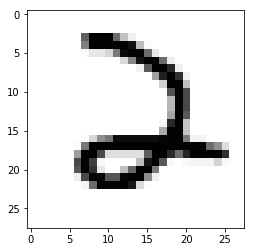

In [3]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

## Discriminator Network

Nosso modelo discriminativo é uma rede neural convolucional que recebe uma imagem de tamanho 28 x 28 x 1 como entrada e retorna um único número escalar que descreve se a imagem de entrada é ou não "real" ou "falsa" - ou seja, seja desenhada do conjunto de imagens MNIST ou geradas pelo modelo generativo.

![caption](images/GAN_Discriminator.png)

A estrutura do nosso modelo modelo discriminativo é baseada em [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/get_started/mnist/pros). Possui duas camadas convolucionais que encontram recursos de 5x5 pixels e duas camadas "totalmente conectadas" que multiplicam pesos por cada pixel na imagem.

Para configurar cada camada, começamos por criar variáveis de peso e bias através de [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable). Os pesos são inicializados de uma distribuição [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) e os bias são inicializados em zero.

[`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) é a função de convolução padrão do TensorFlow. Recebe 4 argumentos. O primeiro é o volume de entrada (nossas imagens `28 x 28 x 1` neste caso). O próximo argumento é a matriz filtro / peso. Finalmente, você também pode mudar o stride e o padding da convolução. Esses dois valores afetam as dimensões do volume de saída.

Se você já está confortável com CNNs, você reconhecerá isso como um simples classificador binário - nada extravagante.

In [4]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # Primeira camada de convolução e de pooling
        # São 32 features diferentes de 5 x 5 pixels
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer = tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input = images, filter = d_w1, strides=[1, 1, 1, 1], padding = 'SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        # Segunda camada de convolução e de pooling
        # São 64 features diferentes de 5 x 5 pixels
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer = tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input = d1, filter = d_w2, strides = [1, 1, 1, 1], padding = 'SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        # Primeira camada totalmente conectada
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer = tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Segunda camada totalmente conectada
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer = tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # Resultado do modelo discriminativo
        return d4

## Generator Network

![caption](images/GAN_Generator.png)

Agora que temos o nosso modelo discriminativo definido, vamos dar uma olhada no modelo generativo. 

Você pode pensar no modelo generativo como um tipo de rede neural convolutiva reversa (Deconvolutional). Uma CNN típica como a nossa rede discriminativa transforma uma matriz de valores de pixel de 2 ou 3 dimensões em uma única probabilidade. Um gerador, no entanto, recebe um vetor de ruído com `d` dimensões e o faz subir para uma imagem de 28 x 28. A ReLU e a normalização do lote são usadas para estabilizar as saídas de cada camada.

Na nossa rede geradora, usamos três camadas convolucionais, juntamente com a interpolação, até formar uma imagem de pixel "28 x 28". 

Na camada de saída, adicionamos uma função de ativação [`tf.sigmoid()` (https://www.tensorflow.org/api_docs/python/tf/sigmoid). Isso "espreme" os pixels que pareceriam cinza em preto ou branco, resultando em uma imagem mais nítida.

BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

In [5]:
def generator(z, batch_size, z_dim):
    # Camada 1
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Gerando 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Gerando 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Convolução final com um canal de saída
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensões de g4: batch_size x 28 x 28 x 1
    return g4

## Gerando uma Amostra de Imagem

Agora que já definimos as funções dos modelos discriminativo e generativo, vamos ver o que uma saída de amostra de um gerador não treinado parece.

Precisamos abrir uma sessão TensorFlow e criar um espaço reservado (placeholder) para a entrada do nosso gerador. O shape do espaço reservado será "None, z_dimensões". A palavra-chave `None` significa que o valor pode ser determinado no tempo de execução da sessão. Normalmente, nós temos "None" como nossa primeira dimensão para que possamos ter tamanhos de lote variáveis. (Com um tamanho de lote de 50, a entrada para o gerador seria de 50 x 100). Com a opção "None", não precisamos especificar `batch_size` até mais tarde.

In [6]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

Agora, criamos uma variável (`generate_image_output`) que contém a saída do gerador e também inicializaremos o vetor de ruído aleatório que vamos usar como entrada. A função [`np.random.normal ()`] (https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) tem três argumentos. O primeiro e o segundo definem o desvio padrão e médio para a distribuição normal (0 e 1 no nosso caso) e o terceiro define a forma do vetor (`1 x 100`).

In [7]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

Em seguida, inicializamos todas as variáveis, alimentamos o `z_batch` no espaço reservado e executamos a sessão.

A função [`sess.run ()`] (https://www.tensorflow.org/api_docs/python/tf/Session#run) possui dois argumentos. O primeiro é chamado de argumento "fetches"; define o valor que lhe interessa na computação. No nosso caso, queremos ver qual é a saída do gerador. Se você olhar para o último trecho de código, você verá que a saída da função do gerador é armazenada em `generated_image_output`, então usaremos `generated_image_output` para o nosso primeiro argumento.

O segundo argumento recebe um dicionário de entradas que são substituídas no grafo quando ele é executado. É aí que nós alimentamos nossos espaços reservados. No nosso exemplo, precisamos alimentar nossa variável `z_batch` no `z_placeholder` que definimos anteriormente. Como antes, veremos a imagem remodelando-a para os pixels '28 x 28' e mostramos com o PyPlot.

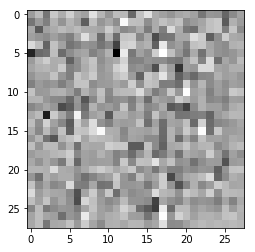

In [8]:
# Visualizando a saída do Generator antes do treinamento
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output, feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

Nada foi aprendido, pois não houve treinamento. Agora precisamos treinar os pesos e os bias na rede geradora para converter números aleatórios em dígitos reconhecíveis. Olhemos para as funções de perda e otimização!

## Treinando o Modelo GAN

Uma das partes mais complicadas sobre a criação e ajuste de GANs é que eles têm duas funções de perda: uma que incentiva o gerador a criar imagens melhores e a outra que encoraja o discriminador a distinguir imagens geradas de imagens reais.

Treinamos tanto o gerador quanto o discriminador simultaneamente. À medida que o discriminador melhora em distinguir imagens reais de imagens geradas, o gerador é capaz de melhor ajustar seus pesos e distorções para gerar imagens convincentes.

Aqui estão as entradas e saídas para nossas redes.

In [9]:
tf.reset_default_graph()
batch_size = 50

# Input noise no modelo generativo
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 

# Input image no modelo discriminativo
x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 

# Imagens geradas
Gz = generator(z_placeholder, batch_size, z_dimensions) 

# Previsões de probabilidade do modelo discriminativo
# Para imagens reais do MNIST
Dx = discriminator(x_placeholder) 

# Previsões de probabilidade para as imagens geradas
Dg = discriminator(Gz, reuse_variables=True)

Então, primeiro pensemos sobre o que queremos de nossas redes. O objetivo do discriminador é classificar corretamente as imagens MNIST reais como reais (retornar uma saída com probabilidade mais alta) e gerar imagens como falsas (retornar uma saída mais baixa). Calculamos duas perdas para o discriminador: uma perda que compara `Dx` e 1 para imagens reais do conjunto MNIST, bem como uma perda que compara `Dg` e 0 para imagens do gerador. Faremos isso com a função [`tf.nn.sigmoid_cross_entropy_with_logits ()`] do TensorFlow (https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits), que calcula as perdas entre entropia entre `Dx` e 1 e entre `Dg` e 0.

`sigmoid_cross_entropy_with_logits` opera em valores não escalados em vez de valores de probabilidade de 0 a 1. Dê uma olhada na última linha do nosso discriminador: não há camada softmax ou sigmoid no final. Os GANs podem falhar se seus discriminadores "saturarem", ou se confiar o suficiente para retornar exatamente 0 quando receberem uma imagem gerada; que deixa o discriminador sem um gradiente útil para descer.

A função [`tf.reduce_mean ()`] (https://www.tensorflow.org/api_docs/python/tf/reduce_mean) assume o valor médio de todos os componentes na matriz retornada pela função de entropia cruzada. Esta é uma maneira de reduzir a perda para um único valor escalar, em vez de um vetor ou matriz.

In [10]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Agora vamos configurar a função de perda do gerador. Queremos que a rede geradora crie imagens que enganarão o discriminador: o gerador quer que o discriminador publique um valor próximo de 1 quando é dada uma imagem do gerador. Portanto, queremos calcular a perda entre `Dg` e 1.

In [11]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

Agora que temos nossas funções de perda, precisamos definir nossos otimizadores. O otimizador para a rede geradora precisa atualizar apenas os pesos do gerador, e não os do discriminador. Da mesma forma, quando treinamos o discriminador, queremos manter os pesos do gerador resolvidos.

Para fazer essa distinção, precisamos criar duas listas de variáveis, uma com os pesos e os preconceitos do discriminador e outra com os pesos e preconceitos do gerador. É aqui que nomear todas as suas variáveis TensorFlow com um esquema pensativo pode ser útil.

In [12]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


Em seguida, especificamos nossos dois otimizadores. [Adam] (https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) geralmente é o algoritmo de otimização de escolha para GANs; ele utiliza taxas de aprendizagem adaptativa e impulso. Chamamos a função de minimizar de Adão e também especificamos as variáveis que queremos que atualizem - os pesos e os distúrbios do gerador quando treinamos o gerador e os pesos e vies do discriminador quando treinamos o discriminador.

Estamos configurando duas operações de treinamento diferentes para o discriminador aqui: uma que treina o discriminador em imagens reais e uma que treina o discrmnator em imagens falsas. Às vezes, é útil usar diferentes taxas de aprendizagem para essas duas operações de treinamento, ou usá-las separadamente para [regular a aprendizagem de outras maneiras] (https://github.com/jonbruner/ezgan).

In [13]:
# Treinando o modelo discriminativo
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Treinando o modelo generativo
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

Pode ser complicado fazer com que os GANs convergem e, além disso, muitas vezes eles precisam treinar por muito tempo. [TensorBoard] (https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) é útil para rastrear o processo de treinamento; Ele pode representar propriedades escalares como perdas, exibir imagens de amostra durante o treino e ilustrar a topologia das redes neurais.

Se você executar este script em sua própria máquina, inclua a célula abaixo. Então, em uma janela do terminal do diretório em que este caderno reside, execute

```
tensorboard --logdir=tensorboard/
```

e abra o TensorBoard visitando [`http: // localhost: 6006`] (http: // localhost: 6006) em seu navegador da Web.

In [14]:
# Variáveis
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

E agora nós iteramos. Começamos dando brevemente ao discriminador algum treinamento inicial; Isso ajuda a desenvolver um gradiente útil para o gerador.

Em seguida, avançamos para o ciclo principal de treinamento. Quando formamos o gerador, alimentaremos um vetor 'z' aleatório no gerador e passamos a saída para o discriminador (esta é a variável `Dg` que especificamos anteriormente). Os pesos e bias do gerador serão atualizados para produzir imagens que o discriminador é mais provável que classifique como real.

Para treinar o discriminador, alimentaremos um lote de imagens do conjunto MNIST para servir como exemplos positivos e, em seguida, treinamos o discriminador novamente em imagens geradas, usando-os como exemplos negativos. Lembre-se de que, à medida que o gerador melhora a sua saída, o discriminador continua a aprender a classificar as imagens do gerador melhoradas como falsas.

** Se você quiser executar este código, prepare-se para aguardar: demora cerca de 40 minutos em uma GPU, mas pode demorar dez vezes mais em uma CPU desktop. **

dLossReal: 0.692376 dLossFake: 0.692587
dLossReal: 0.00632918 dLossFake: 0.00637468
dLossReal: 0.00136943 dLossFake: 0.000913107
Iteração: 0 at 2017-10-11 08:59:35.945714


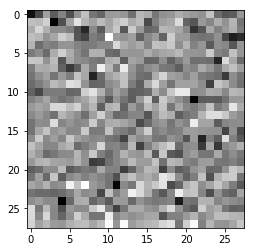

Estimativa: [[-7.4338131]]
Iteração: 100 at 2017-10-11 08:59:38.228608


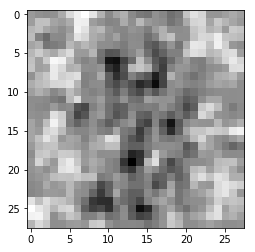

Estimativa: [[-8.50516224]]
Iteração: 200 at 2017-10-11 08:59:40.477793


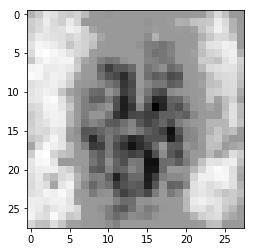

Estimativa: [[-7.41145706]]
Iteração: 300 at 2017-10-11 08:59:42.703939


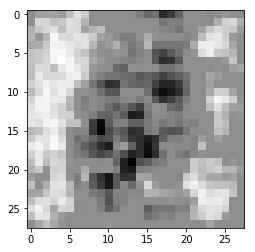

Estimativa: [[-5.98110342]]
Iteração: 400 at 2017-10-11 08:59:44.939910


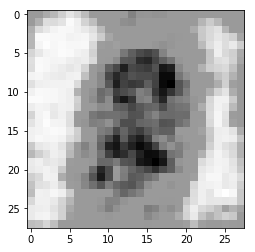

Estimativa: [[-8.70421696]]
Iteração: 500 at 2017-10-11 08:59:47.130946


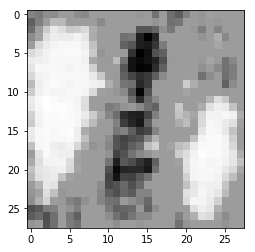

Estimativa: [[-17.04797935]]
Iteração: 600 at 2017-10-11 08:59:49.411226


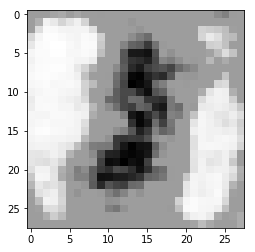

Estimativa: [[-13.8711834]]
Iteração: 700 at 2017-10-11 08:59:51.662913


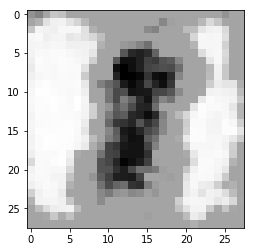

Estimativa: [[-9.30085659]]
Iteração: 800 at 2017-10-11 08:59:53.967147


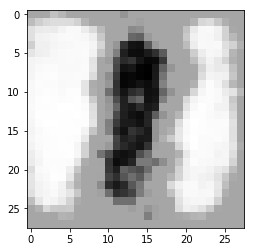

Estimativa: [[-8.2982893]]
Iteração: 900 at 2017-10-11 08:59:56.228093


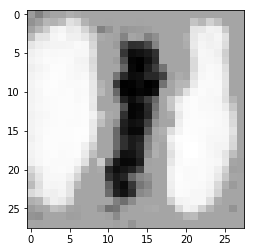

Estimativa: [[-7.74826097]]
Iteração: 1000 at 2017-10-11 08:59:58.500004


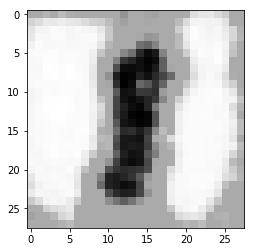

Estimativa: [[-10.42672825]]
Iteração: 1100 at 2017-10-11 09:00:00.768217


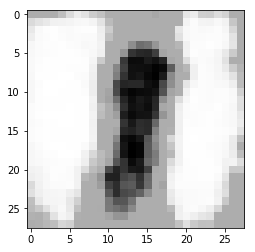

Estimativa: [[-11.1723175]]
Iteração: 1200 at 2017-10-11 09:00:03.006828


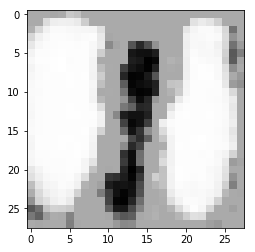

Estimativa: [[-18.96627617]]
Iteração: 1300 at 2017-10-11 09:00:05.264993


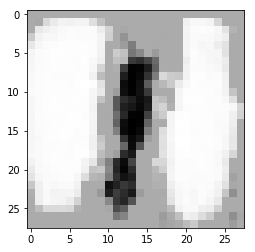

Estimativa: [[-13.62077999]]
Iteração: 1400 at 2017-10-11 09:00:07.645457


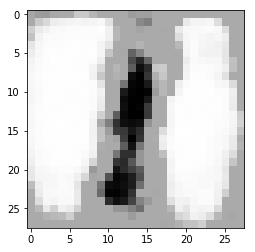

Estimativa: [[-7.51721716]]
Iteração: 1500 at 2017-10-11 09:00:09.864140


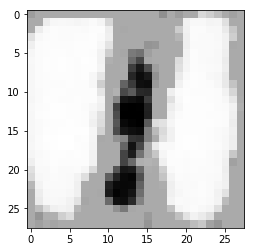

Estimativa: [[-9.11278534]]
Iteração: 1600 at 2017-10-11 09:00:12.108928


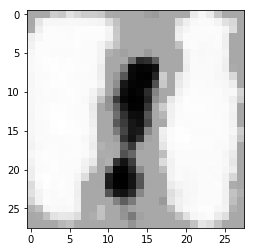

Estimativa: [[-9.87009907]]
Iteração: 1700 at 2017-10-11 09:00:14.431346


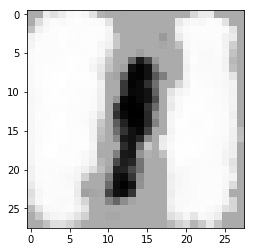

Estimativa: [[-11.4194355]]
Iteração: 1800 at 2017-10-11 09:00:16.663155


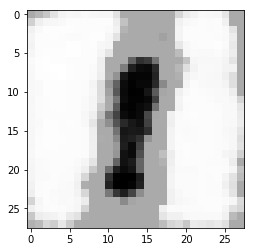

Estimativa: [[-8.12962151]]
Iteração: 1900 at 2017-10-11 09:00:18.990763


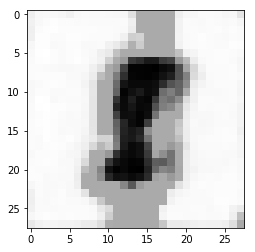

Estimativa: [[-7.57372284]]
Iteração: 2000 at 2017-10-11 09:00:21.281003


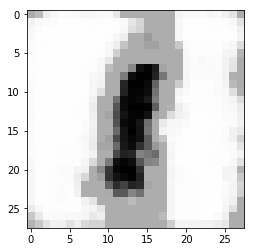

Estimativa: [[-8.62279415]]
Iteração: 2100 at 2017-10-11 09:00:23.565548


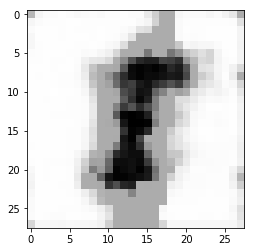

Estimativa: [[-12.07049751]]
Iteração: 2200 at 2017-10-11 09:00:25.823169


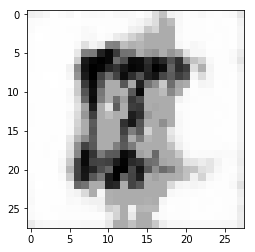

Estimativa: [[-9.8423481]]
Iteração: 2300 at 2017-10-11 09:00:28.275524


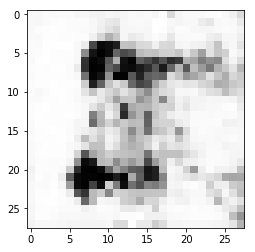

Estimativa: [[-11.64646244]]
Iteração: 2400 at 2017-10-11 09:00:30.642120


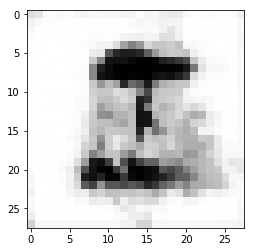

Estimativa: [[-6.06186247]]
Iteração: 2500 at 2017-10-11 09:00:32.917322


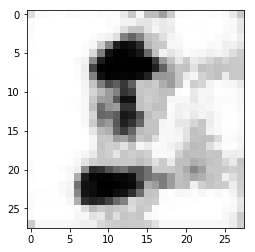

Estimativa: [[-4.05409575]]
Iteração: 2600 at 2017-10-11 09:00:35.223591


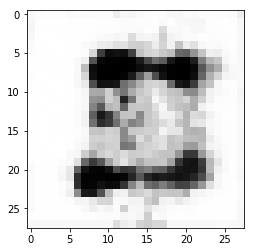

Estimativa: [[-1.86207116]]
Iteração: 2700 at 2017-10-11 09:00:37.516235


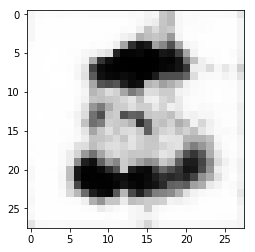

Estimativa: [[ 3.77354956]]
Iteração: 2800 at 2017-10-11 09:00:39.784625


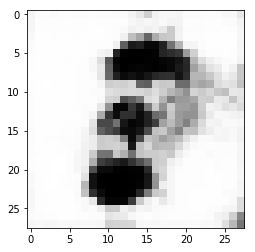

Estimativa: [[-2.56443691]]
Iteração: 2900 at 2017-10-11 09:00:42.128171


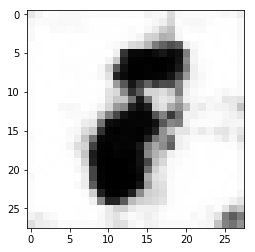

Estimativa: [[-3.25184631]]
Iteração: 3000 at 2017-10-11 09:00:44.512310


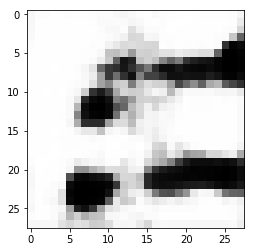

Estimativa: [[-13.61367226]]
Iteração: 3100 at 2017-10-11 09:00:46.834793


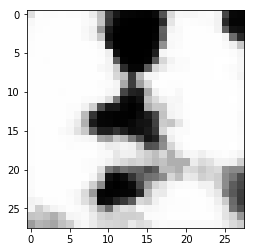

Estimativa: [[-0.31732747]]
Iteração: 3200 at 2017-10-11 09:00:49.138758


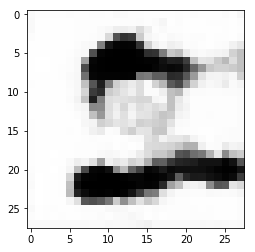

Estimativa: [[-46.8422966]]
Iteração: 3300 at 2017-10-11 09:00:51.540640


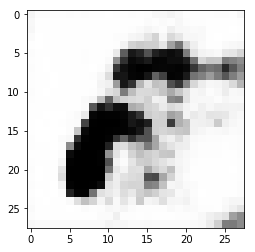

Estimativa: [[-3.94498658]]
Iteração: 3400 at 2017-10-11 09:00:53.828605


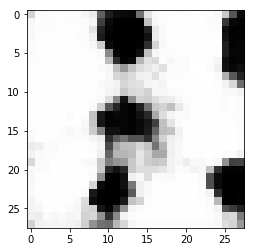

Estimativa: [[-11.04945183]]
Iteração: 3500 at 2017-10-11 09:00:56.200649


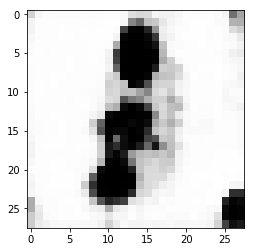

Estimativa: [[-1.96513569]]
Iteração: 3600 at 2017-10-11 09:00:58.481080


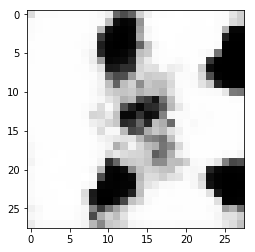

Estimativa: [[ 3.09369206]]
Iteração: 3700 at 2017-10-11 09:01:00.788834


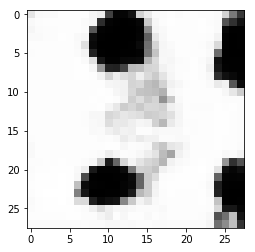

Estimativa: [[-5.27466822]]
Iteração: 3800 at 2017-10-11 09:01:03.095474


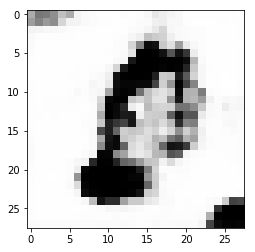

Estimativa: [[-3.67680836]]
Iteração: 3900 at 2017-10-11 09:01:05.406086


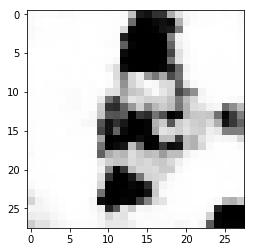

Estimativa: [[-1.22019351]]
Iteração: 4000 at 2017-10-11 09:01:07.783615


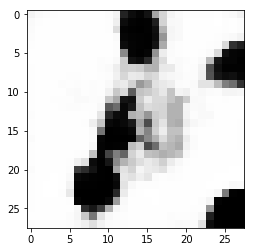

Estimativa: [[ 0.71307856]]
Iteração: 4100 at 2017-10-11 09:01:10.167999


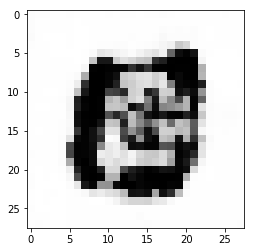

Estimativa: [[ 1.32896984]]
Iteração: 4200 at 2017-10-11 09:01:12.518328


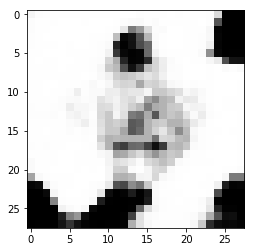

Estimativa: [[ 4.25438786]]
Iteração: 4300 at 2017-10-11 09:01:14.820406


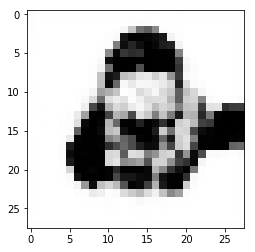

Estimativa: [[ 7.9462595]]
Iteração: 4400 at 2017-10-11 09:01:17.261475


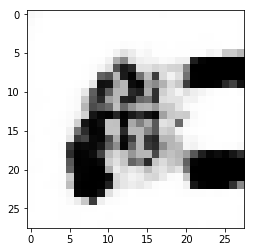

Estimativa: [[ 2.1910584]]
Iteração: 4500 at 2017-10-11 09:01:19.565590


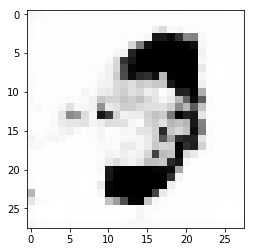

Estimativa: [[-2.0328455]]
Iteração: 4600 at 2017-10-11 09:01:21.887817


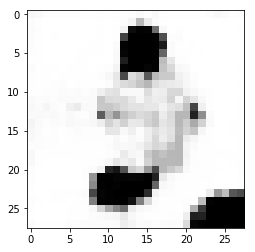

Estimativa: [[-4.99640846]]
Iteração: 4700 at 2017-10-11 09:01:24.223074


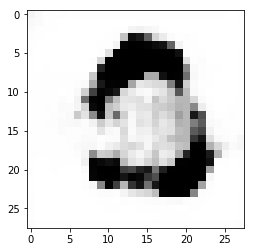

Estimativa: [[-8.69504547]]
Iteração: 4800 at 2017-10-11 09:01:26.609238


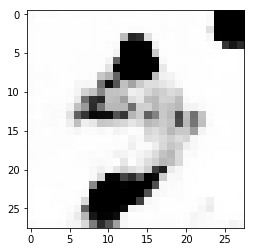

Estimativa: [[-14.86188602]]
Iteração: 4900 at 2017-10-11 09:01:29.003465


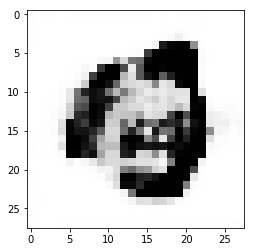

Estimativa: [[ 2.79772639]]
Iteração: 5000 at 2017-10-11 09:01:31.359307


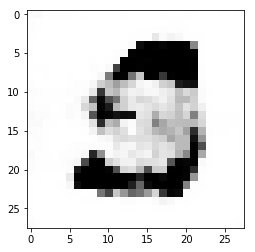

Estimativa: [[ 1.21033585]]
Iteração: 5100 at 2017-10-11 09:01:33.702330


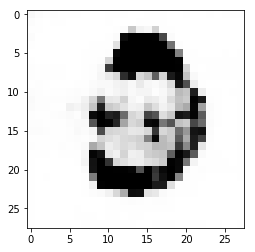

Estimativa: [[-3.53771448]]
Iteração: 5200 at 2017-10-11 09:01:36.127542


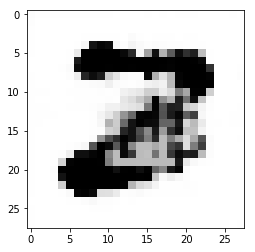

Estimativa: [[-2.08016706]]
Iteração: 5300 at 2017-10-11 09:01:38.604527


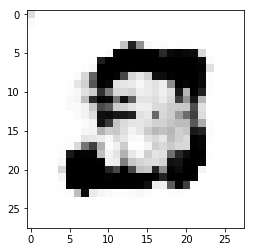

Estimativa: [[ 2.62510705]]
Iteração: 5400 at 2017-10-11 09:01:40.960391


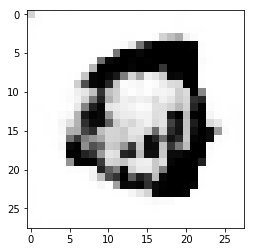

Estimativa: [[-4.23948765]]
Iteração: 5500 at 2017-10-11 09:01:43.319159


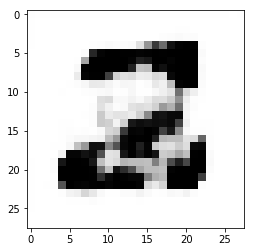

Estimativa: [[ 7.17135]]
Iteração: 5600 at 2017-10-11 09:01:45.687584


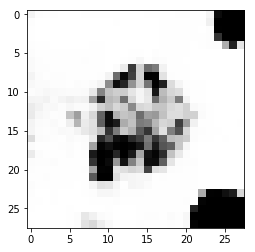

Estimativa: [[-11.46690273]]
Iteração: 5700 at 2017-10-11 09:01:48.211518


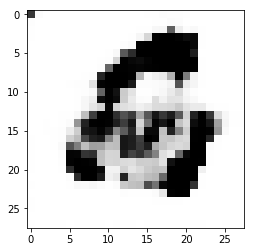

Estimativa: [[-3.15269876]]
Iteração: 5800 at 2017-10-11 09:01:50.641817


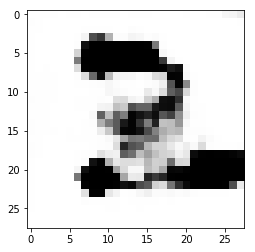

Estimativa: [[-0.82914603]]
Iteração: 5900 at 2017-10-11 09:01:53.153954


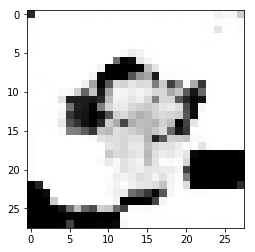

Estimativa: [[ 0.67731607]]
Iteração: 6000 at 2017-10-11 09:01:55.549391


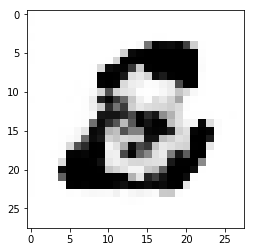

Estimativa: [[-2.39728808]]
Iteração: 6100 at 2017-10-11 09:01:57.906893


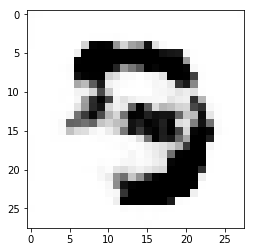

Estimativa: [[ 3.01553655]]
Iteração: 6200 at 2017-10-11 09:02:00.332998


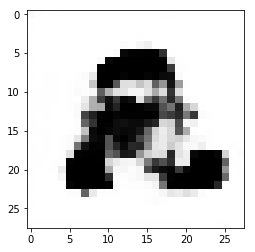

Estimativa: [[-1.78997374]]
Iteração: 6300 at 2017-10-11 09:02:02.757926


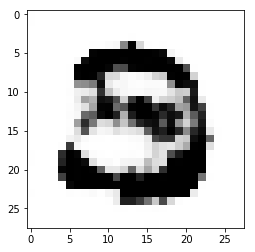

Estimativa: [[ 2.37592268]]
Iteração: 6400 at 2017-10-11 09:02:05.128602


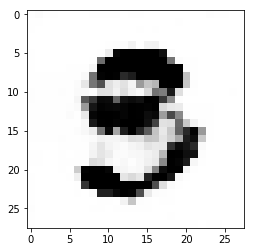

Estimativa: [[-2.27031183]]
Iteração: 6500 at 2017-10-11 09:02:07.477876


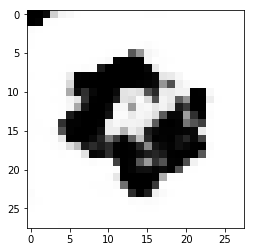

Estimativa: [[-2.88094187]]
Iteração: 6600 at 2017-10-11 09:02:09.915721


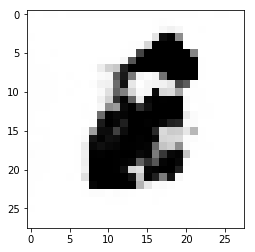

Estimativa: [[-7.56961441]]
Iteração: 6700 at 2017-10-11 09:02:12.298836


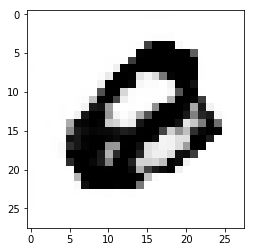

Estimativa: [[ 3.5403235]]
Iteração: 6800 at 2017-10-11 09:02:14.708016


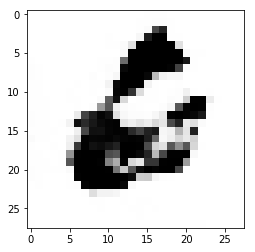

Estimativa: [[-9.11444855]]
Iteração: 6900 at 2017-10-11 09:02:17.170912


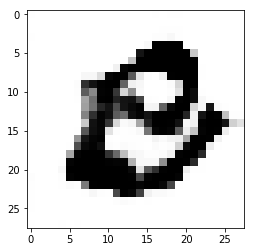

Estimativa: [[ 9.98543072]]
Iteração: 7000 at 2017-10-11 09:02:19.746711


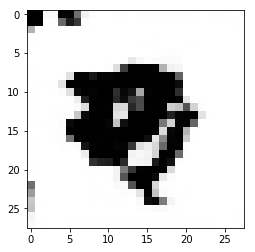

Estimativa: [[-18.59089851]]
Iteração: 7100 at 2017-10-11 09:02:22.348414


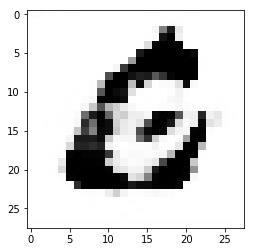

Estimativa: [[-10.66138268]]
Iteração: 7200 at 2017-10-11 09:02:24.855172


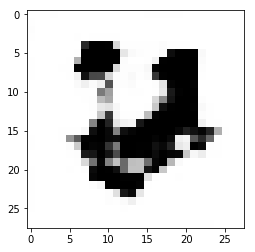

Estimativa: [[ 0.98627156]]
Iteração: 7300 at 2017-10-11 09:02:27.256725


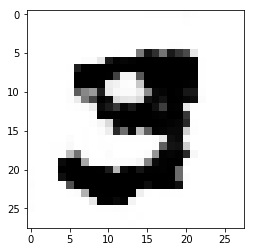

Estimativa: [[ 0.97872204]]
Iteração: 7400 at 2017-10-11 09:02:29.807638


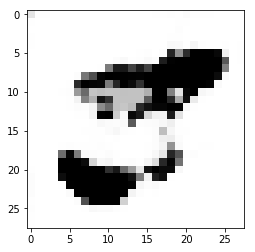

Estimativa: [[-10.64818859]]
Iteração: 7500 at 2017-10-11 09:02:32.312258


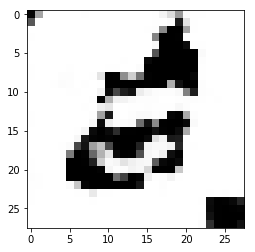

Estimativa: [[ 1.91049612]]
Iteração: 7600 at 2017-10-11 09:02:34.781049


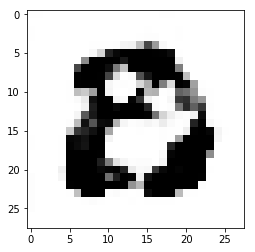

Estimativa: [[-0.53865802]]
Iteração: 7700 at 2017-10-11 09:02:37.204436


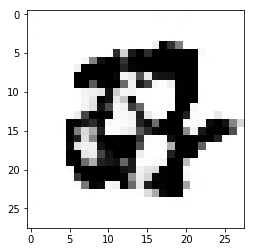

Estimativa: [[-10.04199886]]
Iteração: 7800 at 2017-10-11 09:02:39.762214


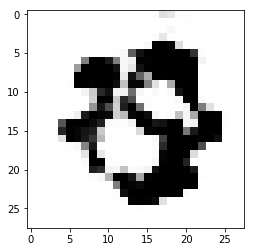

Estimativa: [[-2.94855547]]
Iteração: 7900 at 2017-10-11 09:02:42.190518


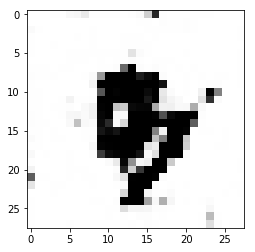

Estimativa: [[ 4.65654469]]
Iteração: 8000 at 2017-10-11 09:02:44.624994


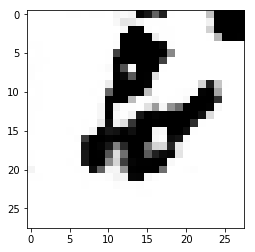

Estimativa: [[ 2.68168974]]
Iteração: 8100 at 2017-10-11 09:02:47.085523


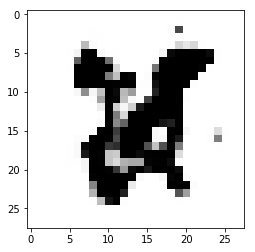

Estimativa: [[ 5.69578171]]
Iteração: 8200 at 2017-10-11 09:02:49.604725


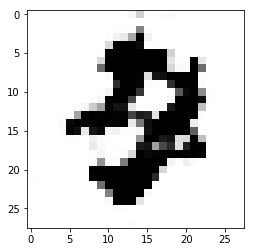

Estimativa: [[-3.60268712]]
Iteração: 8300 at 2017-10-11 09:02:52.026750


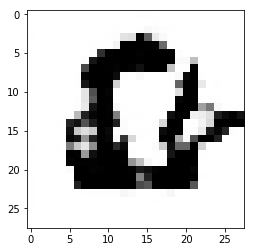

Estimativa: [[ 4.40146065]]
Iteração: 8400 at 2017-10-11 09:02:54.478006


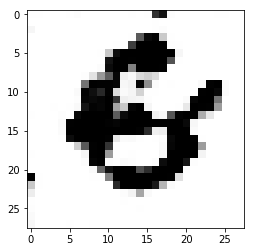

Estimativa: [[-5.95777464]]
Iteração: 8500 at 2017-10-11 09:02:56.995617


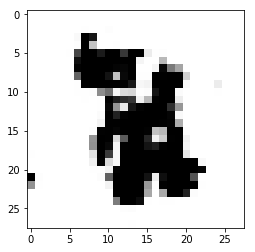

Estimativa: [[-6.60230541]]
Iteração: 8600 at 2017-10-11 09:02:59.754855


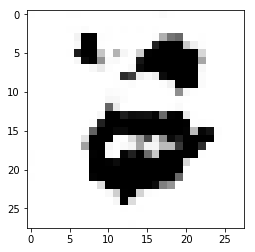

Estimativa: [[ 4.10131359]]
Iteração: 8700 at 2017-10-11 09:03:02.187811


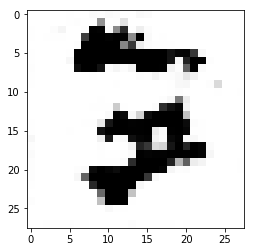

Estimativa: [[-8.58926868]]
Iteração: 8800 at 2017-10-11 09:03:04.714080


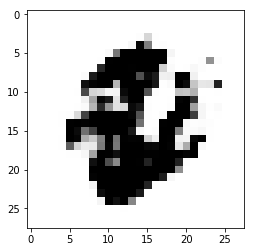

Estimativa: [[-10.30317307]]
Iteração: 8900 at 2017-10-11 09:03:07.214693


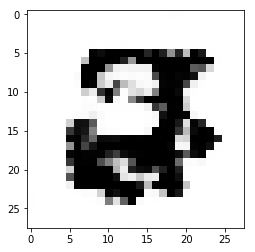

Estimativa: [[ 2.12901044]]
Iteração: 9000 at 2017-10-11 09:03:09.687150


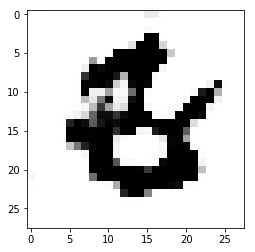

Estimativa: [[ 4.13855314]]
Iteração: 9100 at 2017-10-11 09:03:12.154874


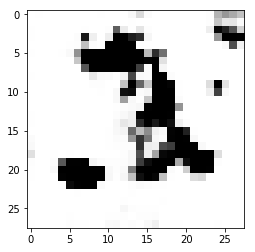

Estimativa: [[-11.10732651]]
Iteração: 9200 at 2017-10-11 09:03:14.765879


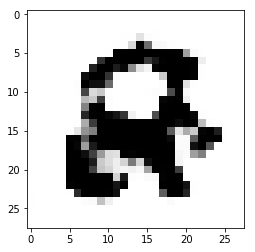

Estimativa: [[ 1.4124037]]
Iteração: 9300 at 2017-10-11 09:03:17.293649


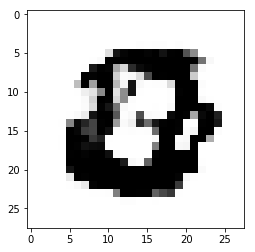

Estimativa: [[-13.95402908]]
Iteração: 9400 at 2017-10-11 09:03:19.902674


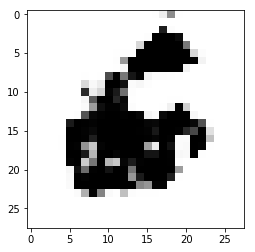

Estimativa: [[ 2.94897199]]
Iteração: 9500 at 2017-10-11 09:03:22.400722


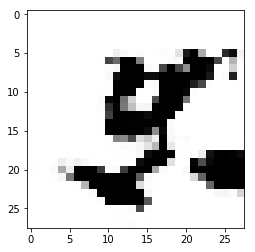

Estimativa: [[-26.24833107]]
Iteração: 9600 at 2017-10-11 09:03:24.940993


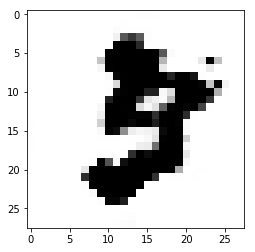

Estimativa: [[-7.52830553]]
Iteração: 9700 at 2017-10-11 09:03:27.504943


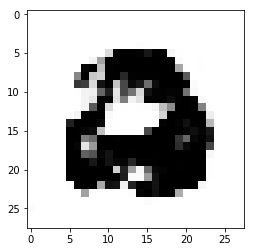

Estimativa: [[-11.04498482]]
Iteração: 9800 at 2017-10-11 09:03:29.979215


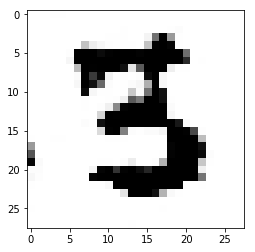

Estimativa: [[ 14.73455715]]
Iteração: 9900 at 2017-10-11 09:03:32.442531


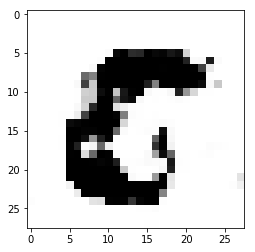

Estimativa: [[ 9.83314991]]
Iteração: 10000 at 2017-10-11 09:03:34.923781


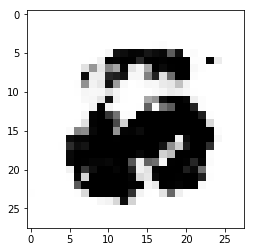

Estimativa: [[-11.0871563]]
Iteração: 10100 at 2017-10-11 09:03:37.482626


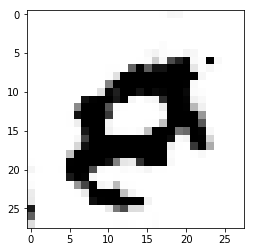

Estimativa: [[ 4.59566212]]
Iteração: 10200 at 2017-10-11 09:03:39.958176


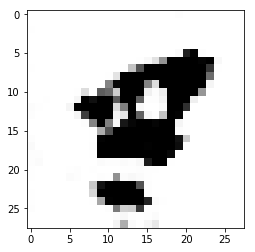

Estimativa: [[ 8.84535027]]
Iteração: 10300 at 2017-10-11 09:03:42.645174


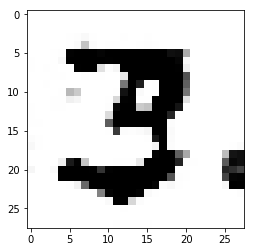

Estimativa: [[-14.64993954]]
Iteração: 10400 at 2017-10-11 09:03:45.149768


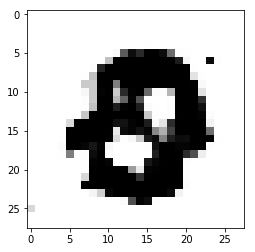

Estimativa: [[-14.0994215]]
Iteração: 10500 at 2017-10-11 09:03:47.625363


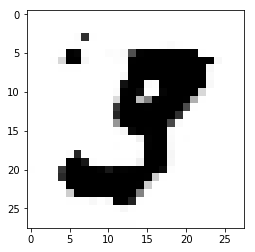

Estimativa: [[ 13.9397459]]
Iteração: 10600 at 2017-10-11 09:03:50.115876


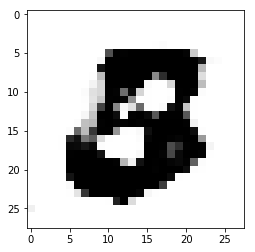

Estimativa: [[-10.2069664]]
Iteração: 10700 at 2017-10-11 09:03:52.723318


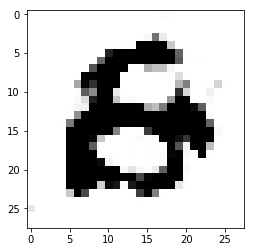

Estimativa: [[-13.28603649]]
Iteração: 10800 at 2017-10-11 09:03:55.265557


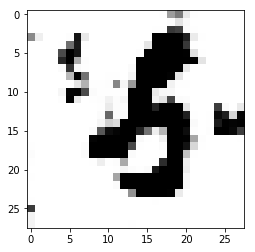

Estimativa: [[-6.0305028]]
Iteração: 10900 at 2017-10-11 09:03:57.782632


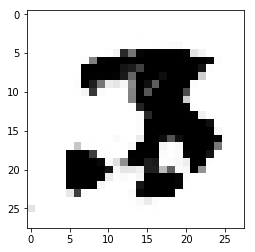

Estimativa: [[ 11.85194016]]
Iteração: 11000 at 2017-10-11 09:04:00.441607


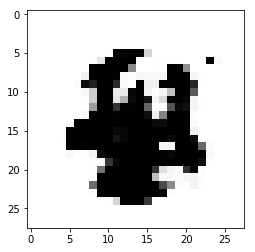

Estimativa: [[ 2.9463985]]
Iteração: 11100 at 2017-10-11 09:04:02.954028


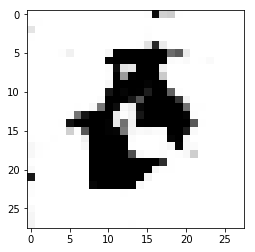

Estimativa: [[-4.16080475]]
Iteração: 11200 at 2017-10-11 09:04:05.578229


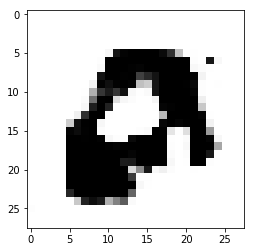

Estimativa: [[-4.72374582]]
Iteração: 11300 at 2017-10-11 09:04:08.151265


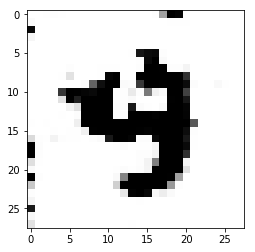

Estimativa: [[-6.40214729]]
Iteração: 11400 at 2017-10-11 09:04:10.746240


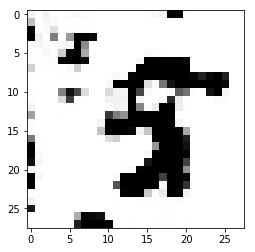

Estimativa: [[-8.08378315]]
Iteração: 11500 at 2017-10-11 09:04:13.271373


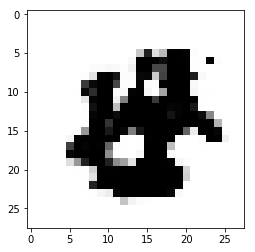

Estimativa: [[ 1.49091959]]
Iteração: 11600 at 2017-10-11 09:04:15.802262


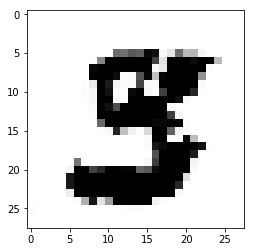

Estimativa: [[-25.9602356]]
Iteração: 11700 at 2017-10-11 09:04:18.356136


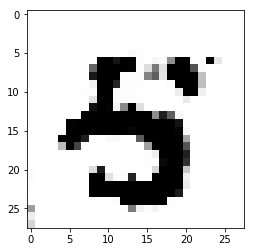

Estimativa: [[ 17.56395531]]
Iteração: 11800 at 2017-10-11 09:04:20.962273


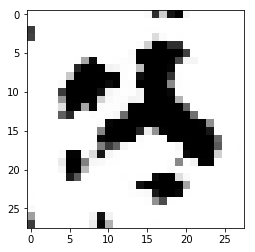

Estimativa: [[-8.53130913]]
Iteração: 11900 at 2017-10-11 09:04:23.595847


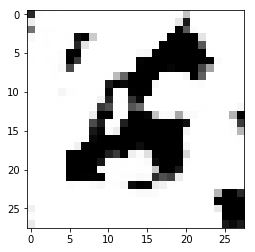

Estimativa: [[ 2.74366283]]
Iteração: 12000 at 2017-10-11 09:04:26.146481


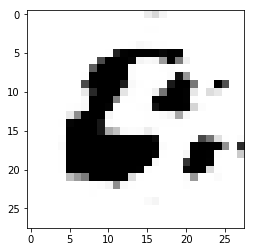

Estimativa: [[-9.30300522]]
Iteração: 12100 at 2017-10-11 09:04:28.706480


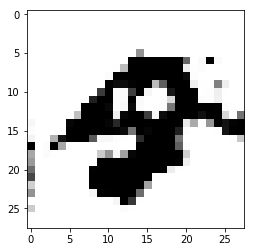

Estimativa: [[ 1.35262775]]
Iteração: 12200 at 2017-10-11 09:04:31.657587


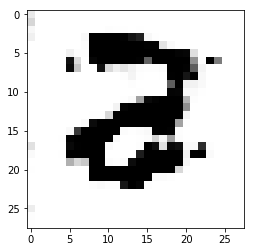

Estimativa: [[-4.06872797]]
Iteração: 12300 at 2017-10-11 09:04:34.200614


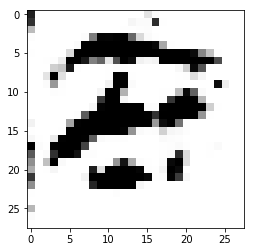

Estimativa: [[-3.27297091]]
Iteração: 12400 at 2017-10-11 09:04:36.974951


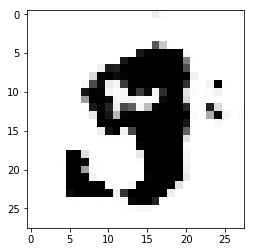

Estimativa: [[ 34.23067093]]
Iteração: 12500 at 2017-10-11 09:04:39.575688


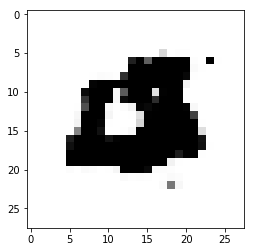

Estimativa: [[ 26.40365601]]
Iteração: 12600 at 2017-10-11 09:04:42.133198


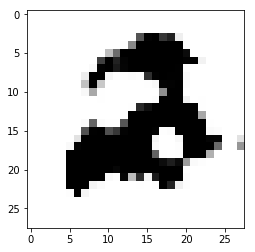

Estimativa: [[-17.90679741]]
Iteração: 12700 at 2017-10-11 09:04:44.687529


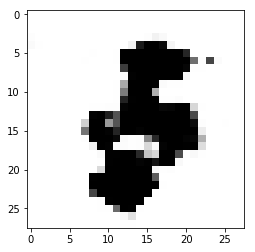

Estimativa: [[ 14.21333504]]
Iteração: 12800 at 2017-10-11 09:04:47.234204


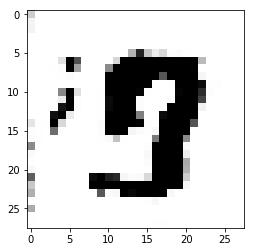

Estimativa: [[ 39.10991287]]
Iteração: 12900 at 2017-10-11 09:04:49.914339


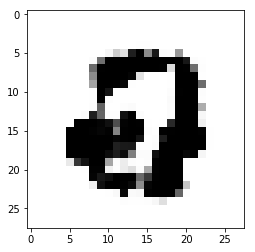

Estimativa: [[ 23.47273636]]
Iteração: 13000 at 2017-10-11 09:04:52.540500


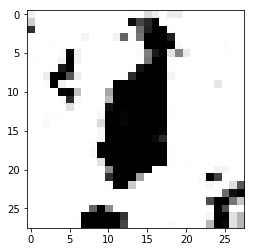

Estimativa: [[ 2.20537519]]
Iteração: 13100 at 2017-10-11 09:04:55.106036


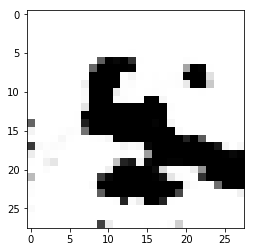

Estimativa: [[ 38.20888138]]
Iteração: 13200 at 2017-10-11 09:04:57.667563


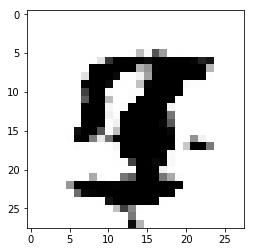

Estimativa: [[ 10.05028534]]
Iteração: 13300 at 2017-10-11 09:05:00.277853


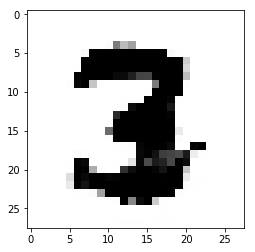

Estimativa: [[ 14.33634472]]
Iteração: 13400 at 2017-10-11 09:05:02.871996


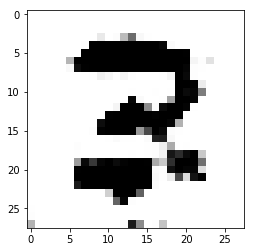

Estimativa: [[ 3.79334426]]
Iteração: 13500 at 2017-10-11 09:05:05.538834


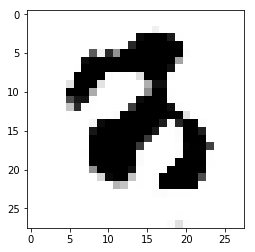

Estimativa: [[ 22.8610878]]
Iteração: 13600 at 2017-10-11 09:05:08.108663


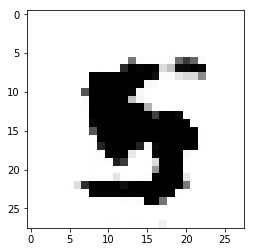

Estimativa: [[-11.88893986]]
Iteração: 13700 at 2017-10-11 09:05:10.719720


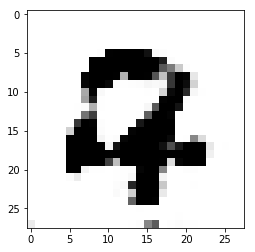

Estimativa: [[ 12.1376791]]
Iteração: 13800 at 2017-10-11 09:05:13.297249


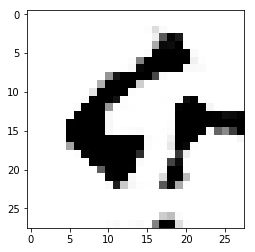

Estimativa: [[ 21.2346344]]
Iteração: 13900 at 2017-10-11 09:05:15.857745


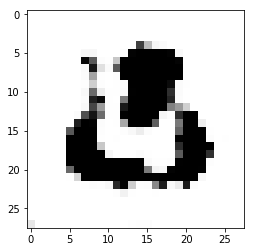

Estimativa: [[-8.1323843]]
Iteração: 14000 at 2017-10-11 09:05:18.507822


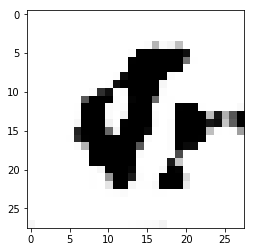

Estimativa: [[ 8.69052219]]
Iteração: 14100 at 2017-10-11 09:05:21.128747


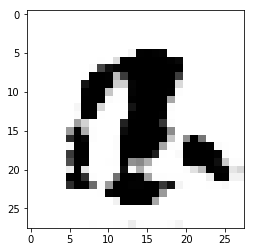

Estimativa: [[ 5.57231283]]
Iteração: 14200 at 2017-10-11 09:05:23.820461


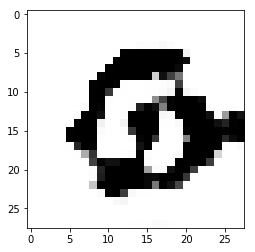

Estimativa: [[ 27.30135345]]
Iteração: 14300 at 2017-10-11 09:05:26.684837


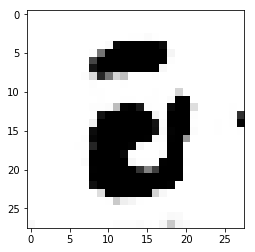

Estimativa: [[ 21.69389725]]
Iteração: 14400 at 2017-10-11 09:05:29.387915


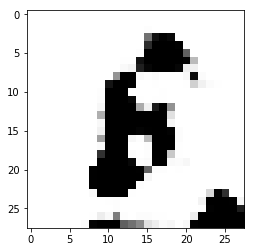

Estimativa: [[ 30.03340721]]
Iteração: 14500 at 2017-10-11 09:05:32.001354


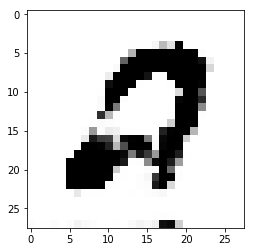

Estimativa: [[ 19.73592758]]
Iteração: 14600 at 2017-10-11 09:05:34.639988


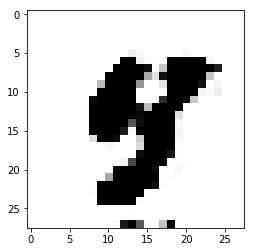

Estimativa: [[ 8.43383312]]
Iteração: 14700 at 2017-10-11 09:05:37.278711


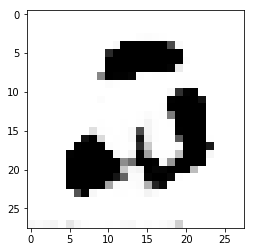

Estimativa: [[ 23.61834717]]
Iteração: 14800 at 2017-10-11 09:05:39.881859


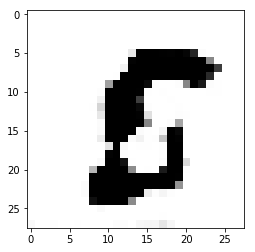

Estimativa: [[-3.21490121]]
Iteração: 14900 at 2017-10-11 09:05:42.526949


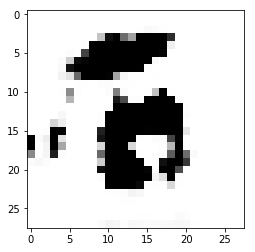

Estimativa: [[ 3.10519862]]
Iteração: 15000 at 2017-10-11 09:05:45.139837


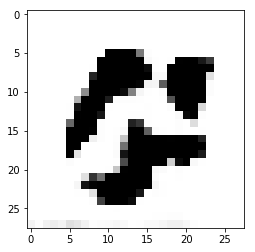

Estimativa: [[ 14.92015076]]
Iteração: 15100 at 2017-10-11 09:05:47.836389


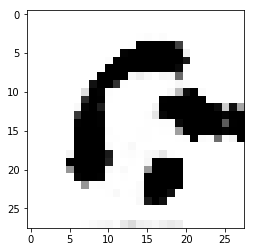

Estimativa: [[ 42.22548294]]
Iteração: 15200 at 2017-10-11 09:05:50.465989


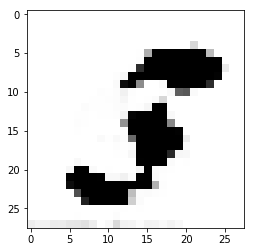

Estimativa: [[ 17.74796867]]
Iteração: 15300 at 2017-10-11 09:05:53.108172


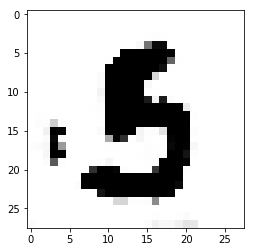

Estimativa: [[ 15.15995502]]
Iteração: 15400 at 2017-10-11 09:05:55.735296


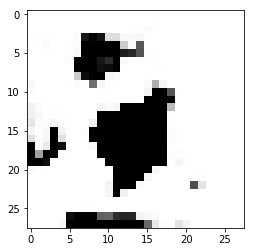

Estimativa: [[ 51.22399902]]
Iteração: 15500 at 2017-10-11 09:05:58.368930


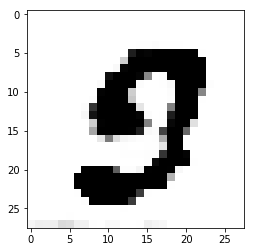

Estimativa: [[ 2.50512385]]
Iteração: 15600 at 2017-10-11 09:06:01.120963


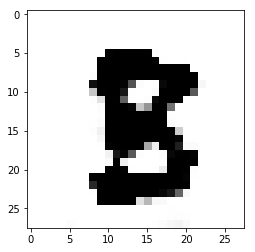

Estimativa: [[-5.02601624]]
Iteração: 15700 at 2017-10-11 09:06:03.778006


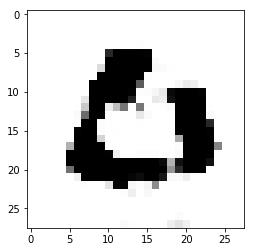

Estimativa: [[ 5.36376715]]
Iteração: 15800 at 2017-10-11 09:06:06.530876


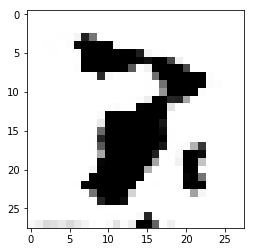

Estimativa: [[ 16.99860573]]
Iteração: 15900 at 2017-10-11 09:06:09.182600


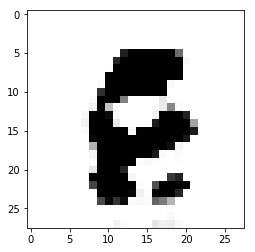

Estimativa: [[ 12.98618507]]
Iteração: 16000 at 2017-10-11 09:06:11.824255


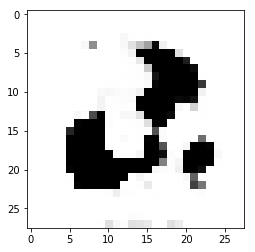

Estimativa: [[ 0.0554153]]
Iteração: 16100 at 2017-10-11 09:06:14.453630


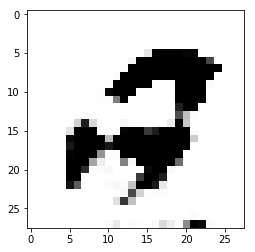

Estimativa: [[-2.32485533]]
Iteração: 16200 at 2017-10-11 09:06:17.160561


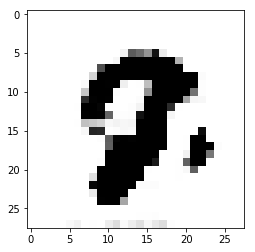

Estimativa: [[ 10.71408081]]
Iteração: 16300 at 2017-10-11 09:06:19.916081


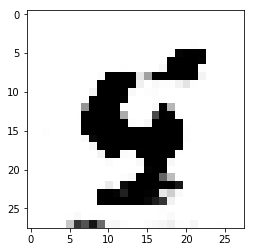

Estimativa: [[ 0.61072892]]
Iteração: 16400 at 2017-10-11 09:06:22.583513


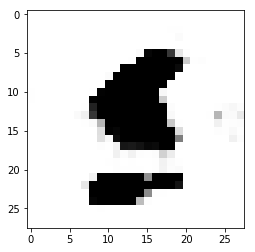

Estimativa: [[ 3.27641511]]
Iteração: 16500 at 2017-10-11 09:06:25.216315


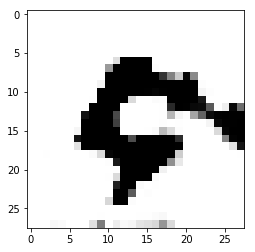

Estimativa: [[-3.95037436]]
Iteração: 16600 at 2017-10-11 09:06:28.018996


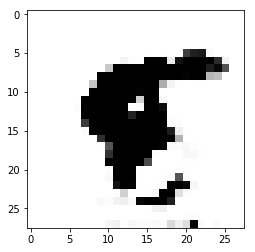

Estimativa: [[-7.47626448]]
Iteração: 16700 at 2017-10-11 09:06:30.946476


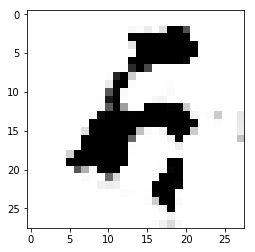

Estimativa: [[-0.35248128]]
Iteração: 16800 at 2017-10-11 09:06:33.800030


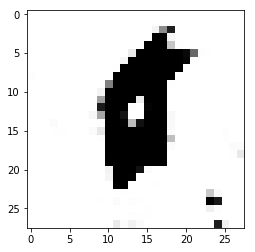

Estimativa: [[-3.73997331]]
Iteração: 16900 at 2017-10-11 09:06:36.579983


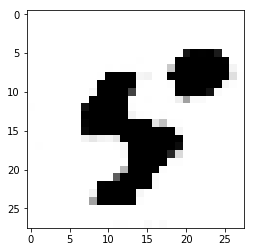

Estimativa: [[ 16.40497398]]
Iteração: 17000 at 2017-10-11 09:06:39.284231


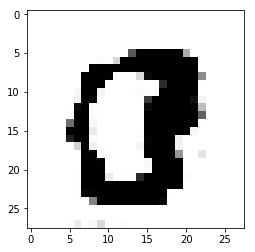

Estimativa: [[ 26.71717453]]
Iteração: 17100 at 2017-10-11 09:06:42.066905


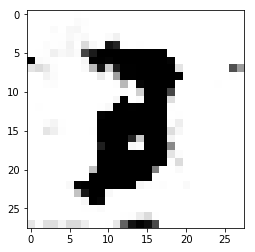

Estimativa: [[ 3.69677377]]
Iteração: 17200 at 2017-10-11 09:06:44.776491


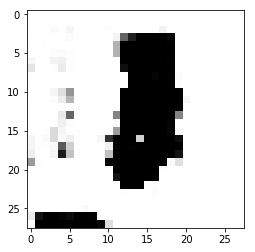

Estimativa: [[-3.95044804]]
Iteração: 17300 at 2017-10-11 09:06:47.600684


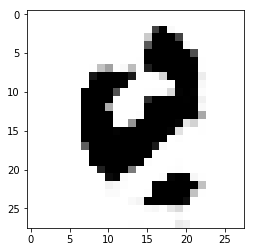

Estimativa: [[ 15.2444315]]
Iteração: 17400 at 2017-10-11 09:06:50.314852


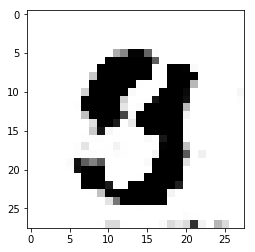

Estimativa: [[-3.70223761]]
Iteração: 17500 at 2017-10-11 09:06:53.028588


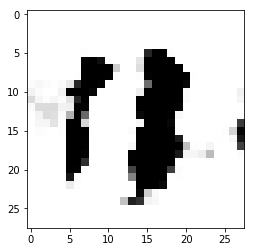

Estimativa: [[-14.10837364]]
Iteração: 17600 at 2017-10-11 09:06:55.804775


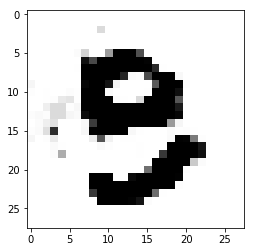

Estimativa: [[ 14.68207455]]
Iteração: 17700 at 2017-10-11 09:06:58.485862


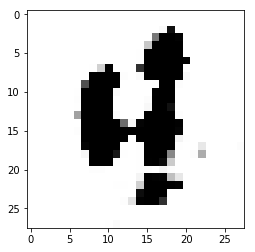

Estimativa: [[-8.79595089]]
Iteração: 17800 at 2017-10-11 09:07:01.256896


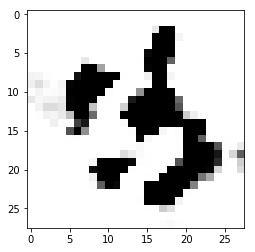

Estimativa: [[ 16.07736969]]
Iteração: 17900 at 2017-10-11 09:07:03.974152


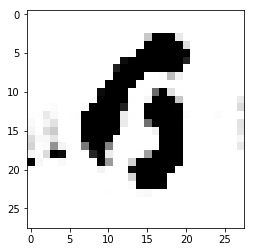

Estimativa: [[ 16.23560905]]
Iteração: 18000 at 2017-10-11 09:07:06.762110


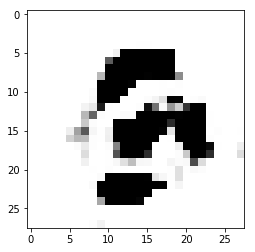

Estimativa: [[ 11.49934196]]
Iteração: 18100 at 2017-10-11 09:07:09.492392


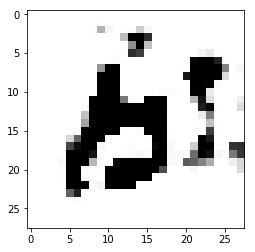

Estimativa: [[ 6.77877808]]
Iteração: 18200 at 2017-10-11 09:07:12.227368


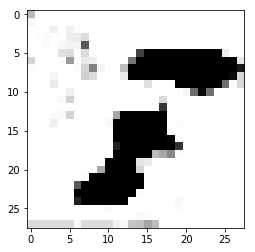

Estimativa: [[ 13.33048916]]
Iteração: 18300 at 2017-10-11 09:07:15.044999


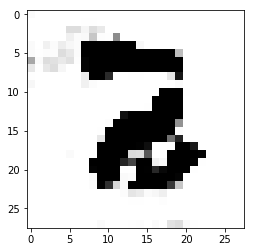

Estimativa: [[ 8.08107567]]
Iteração: 18400 at 2017-10-11 09:07:17.803976


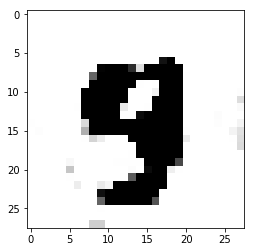

Estimativa: [[ 3.26094508]]
Iteração: 18500 at 2017-10-11 09:07:20.520752


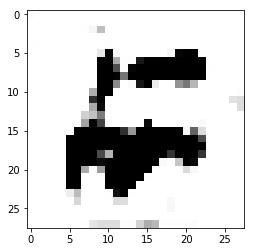

Estimativa: [[-4.07463694]]
Iteração: 18600 at 2017-10-11 09:07:23.289081


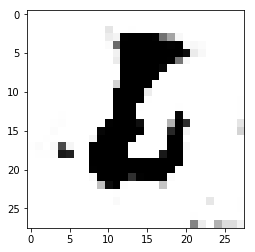

Estimativa: [[-7.09348822]]
Iteração: 18700 at 2017-10-11 09:07:26.028441


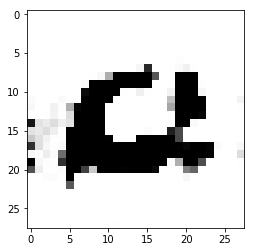

Estimativa: [[ 15.57351971]]
Iteração: 18800 at 2017-10-11 09:07:28.790479


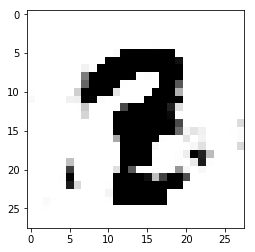

Estimativa: [[-3.33119011]]
Iteração: 18900 at 2017-10-11 09:07:31.554167


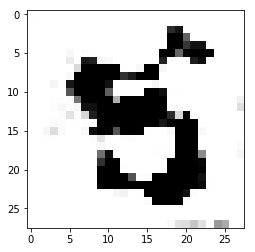

Estimativa: [[ 35.55577087]]
Iteração: 19000 at 2017-10-11 09:07:34.300237


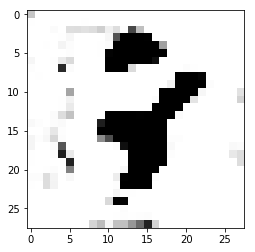

Estimativa: [[ 15.13754654]]
Iteração: 19100 at 2017-10-11 09:07:37.039476


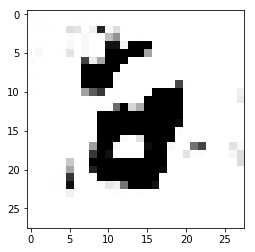

Estimativa: [[-4.12583447]]
Iteração: 19200 at 2017-10-11 09:07:39.836243


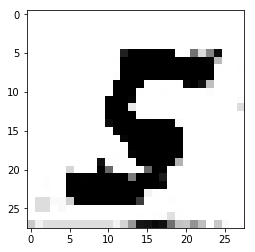

Estimativa: [[-8.65261745]]
Iteração: 19300 at 2017-10-11 09:07:42.611472


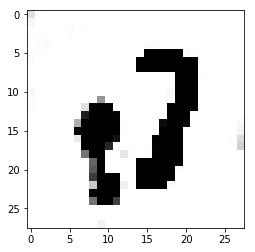

Estimativa: [[ 3.40686989]]
Iteração: 19400 at 2017-10-11 09:07:45.644410


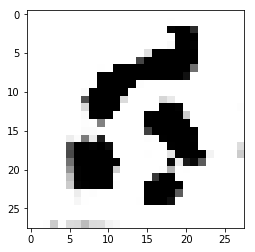

Estimativa: [[ 19.4507885]]
Iteração: 19500 at 2017-10-11 09:07:48.442631


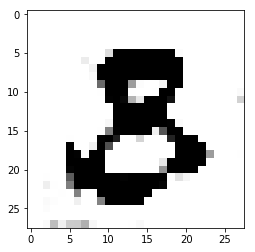

Estimativa: [[-13.95903015]]
Iteração: 19600 at 2017-10-11 09:07:51.169655


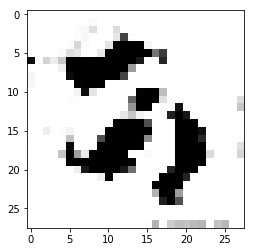

Estimativa: [[-3.60930037]]
Iteração: 19700 at 2017-10-11 09:07:53.976901


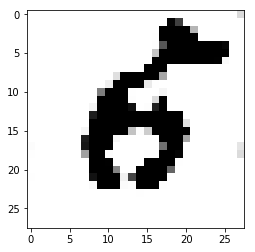

Estimativa: [[ 6.38852739]]
Iteração: 19800 at 2017-10-11 09:07:56.779161


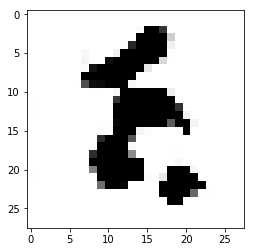

Estimativa: [[-5.6468401]]
Iteração: 19900 at 2017-10-11 09:07:59.544127


Estimativa: [[ 7.74537659]]
Iteração: 20000 at 2017-10-11 09:08:02.311669


Estimativa: [[ 24.15293884]]
Iteração: 20100 at 2017-10-11 09:08:05.105792


Estimativa: [[ 6.66520977]]
Iteração: 20200 at 2017-10-11 09:08:07.893957


Estimativa: [[ 24.72690201]]
Iteração: 20300 at 2017-10-11 09:08:10.707130


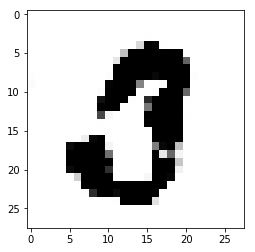

Estimativa: [[ 2.54738641]]
Iteração: 20400 at 2017-10-11 09:08:13.671102


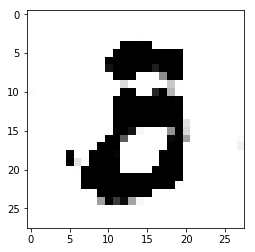

Estimativa: [[-6.25915384]]
Iteração: 20500 at 2017-10-11 09:08:16.483212


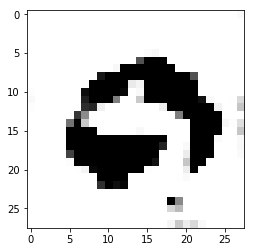

Estimativa: [[ 23.90217209]]
Iteração: 20600 at 2017-10-11 09:08:19.327983


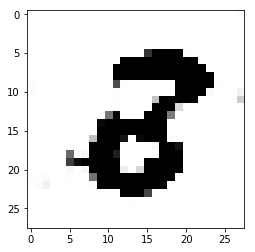

Estimativa: [[ 6.35020304]]
Iteração: 20700 at 2017-10-11 09:08:22.111586


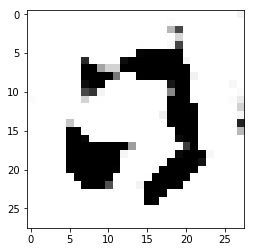

Estimativa: [[ 3.37201095]]
Iteração: 20800 at 2017-10-11 09:08:24.911065


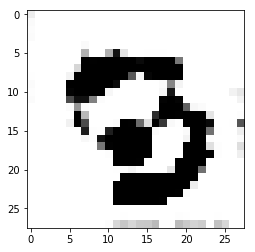

Estimativa: [[ 8.89057922]]
Iteração: 20900 at 2017-10-11 09:08:27.719071


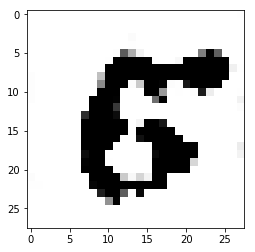

Estimativa: [[ 15.72478008]]
Iteração: 21000 at 2017-10-11 09:08:30.548812


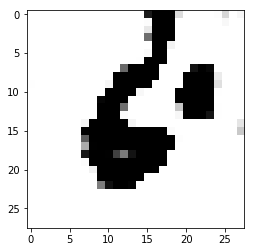

Estimativa: [[-6.75759077]]
Iteração: 21100 at 2017-10-11 09:08:33.586209


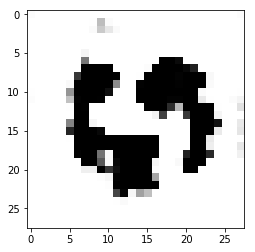

Estimativa: [[ 8.97060966]]
Iteração: 21200 at 2017-10-11 09:08:36.425185


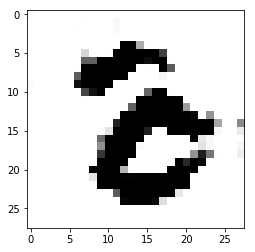

Estimativa: [[ 2.02829695]]
Iteração: 21300 at 2017-10-11 09:08:39.253690


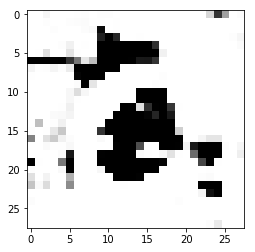

Estimativa: [[-1.34777462]]
Iteração: 21400 at 2017-10-11 09:08:42.240477


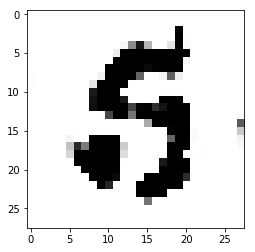

Estimativa: [[-0.37510052]]
Iteração: 21500 at 2017-10-11 09:08:45.050231


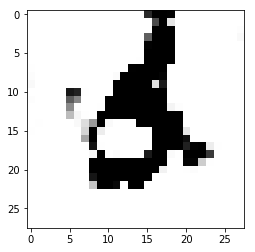

Estimativa: [[ 12.16930962]]
Iteração: 21600 at 2017-10-11 09:08:47.938820


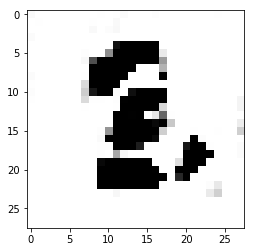

Estimativa: [[ 3.61325574]]
Iteração: 21700 at 2017-10-11 09:08:50.873063


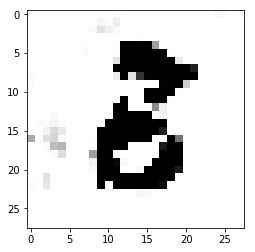

Estimativa: [[ 3.76208568]]
Iteração: 21800 at 2017-10-11 09:08:53.704343


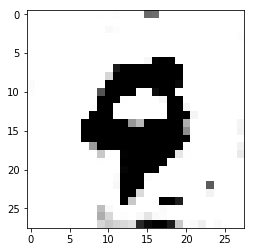

Estimativa: [[-16.32182121]]
Iteração: 21900 at 2017-10-11 09:08:56.561792


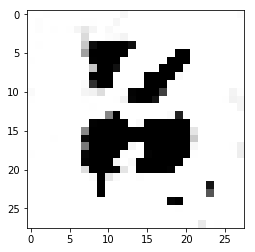

Estimativa: [[ 7.77048159]]
Iteração: 22000 at 2017-10-11 09:08:59.508989


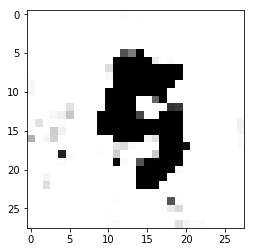

Estimativa: [[ 2.45972204]]
Iteração: 22100 at 2017-10-11 09:09:02.336238


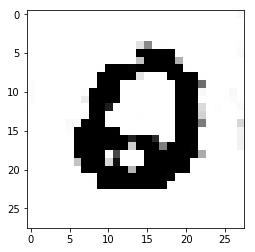

Estimativa: [[ 14.53701878]]
Iteração: 22200 at 2017-10-11 09:09:05.195473


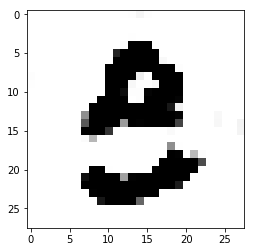

Estimativa: [[-8.49900913]]
Iteração: 22300 at 2017-10-11 09:09:08.089712


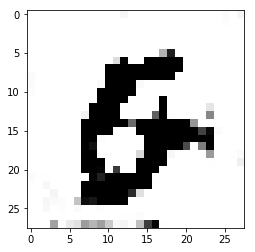

Estimativa: [[-4.79992867]]
Iteração: 22400 at 2017-10-11 09:09:10.956887


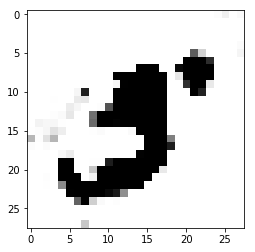

Estimativa: [[ 22.17287636]]
Iteração: 22500 at 2017-10-11 09:09:14.214158


Estimativa: [[ 6.94900513]]
Iteração: 22600 at 2017-10-11 09:09:17.062594


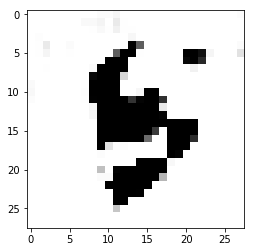

Estimativa: [[-3.69205093]]
Iteração: 22700 at 2017-10-11 09:09:19.899668


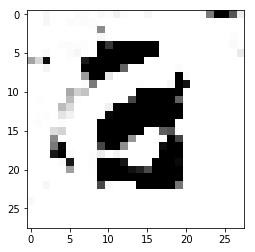

Estimativa: [[-11.76062965]]
Iteração: 22800 at 2017-10-11 09:09:22.859158


Estimativa: [[ 9.08916569]]
Iteração: 22900 at 2017-10-11 09:09:25.720450


Estimativa: [[ 10.98526478]]
Iteração: 23000 at 2017-10-11 09:09:28.551372


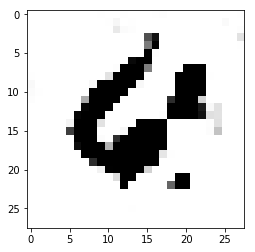

Estimativa: [[ 1.86889708]]
Iteração: 23100 at 2017-10-11 09:09:31.451012


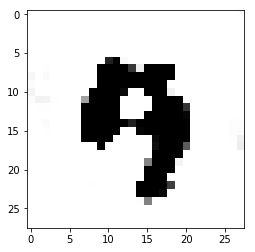

Estimativa: [[ 13.74233627]]
Iteração: 23200 at 2017-10-11 09:09:34.332508


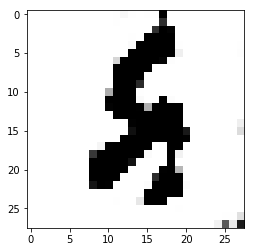

Estimativa: [[ 10.21461296]]
Iteração: 23300 at 2017-10-11 09:09:37.228325


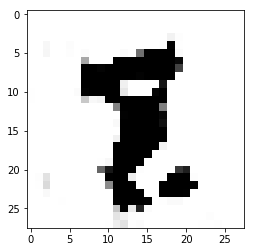

Estimativa: [[ 9.14466]]
Iteração: 23400 at 2017-10-11 09:09:40.127099


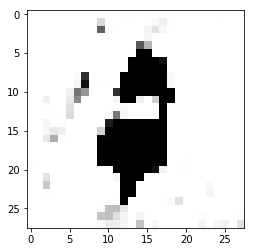

Estimativa: [[ 13.0490427]]
Iteração: 23500 at 2017-10-11 09:09:43.150759


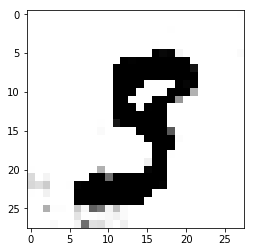

Estimativa: [[ 14.89114857]]
Iteração: 23600 at 2017-10-11 09:09:46.028996


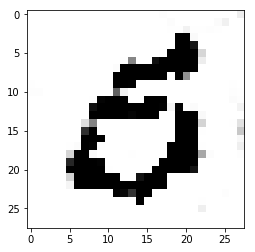

Estimativa: [[ 0.0918496]]
Iteração: 23700 at 2017-10-11 09:09:49.009799


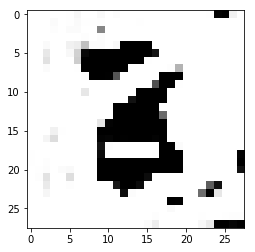

Estimativa: [[ 13.42852497]]
Iteração: 23800 at 2017-10-11 09:09:51.902536


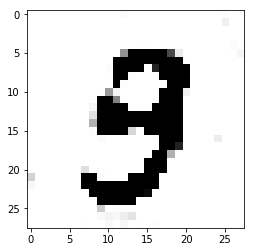

Estimativa: [[-1.70246291]]
Iteração: 23900 at 2017-10-11 09:09:54.819740


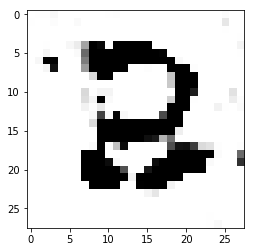

Estimativa: [[ 6.26411009]]
Iteração: 24000 at 2017-10-11 09:09:57.729217


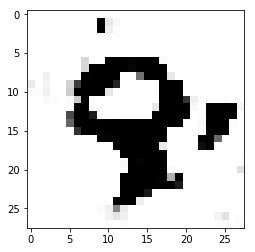

Estimativa: [[ 10.81552505]]
Iteração: 24100 at 2017-10-11 09:10:00.623417


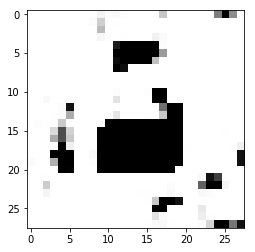

Estimativa: [[ 15.70987225]]
Iteração: 24200 at 2017-10-11 09:10:03.591379


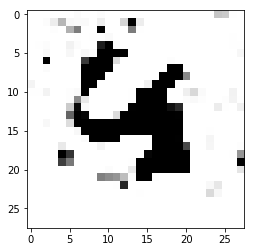

Estimativa: [[-5.45136452]]
Iteração: 24300 at 2017-10-11 09:10:06.545173


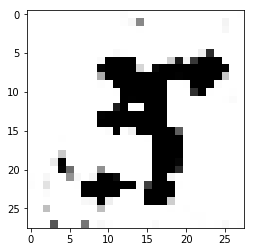

Estimativa: [[ 8.79892159]]
Iteração: 24400 at 2017-10-11 09:10:09.501818


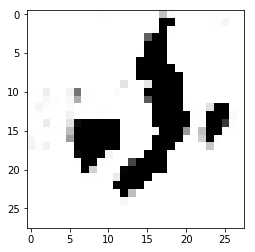

Estimativa: [[ 24.70678139]]
Iteração: 24500 at 2017-10-11 09:10:12.392916


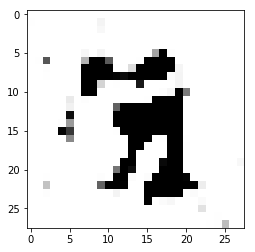

Estimativa: [[ 6.97835302]]
Iteração: 24600 at 2017-10-11 09:10:15.335176


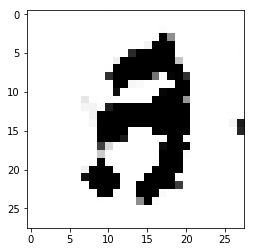

Estimativa: [[ 2.17662096]]
Iteração: 24700 at 2017-10-11 09:10:18.284352


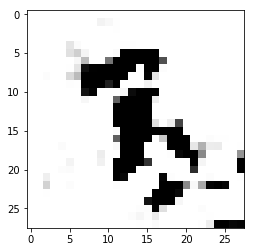

Estimativa: [[-8.5639782]]
Iteração: 24800 at 2017-10-11 09:10:21.314969


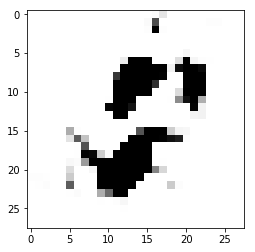

Estimativa: [[ 4.57737875]]
Iteração: 24900 at 2017-10-11 09:10:24.264100


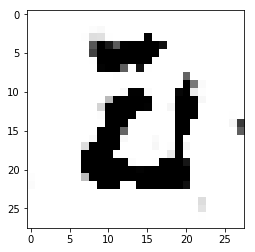

Estimativa: [[-10.18505859]]
Iteração: 25000 at 2017-10-11 09:10:27.249643


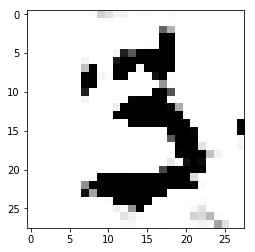

Estimativa: [[-1.63957477]]
Iteração: 25100 at 2017-10-11 09:10:30.150665


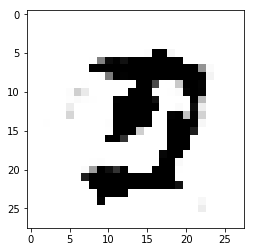

Estimativa: [[-6.11697865]]
Iteração: 25200 at 2017-10-11 09:10:33.087315


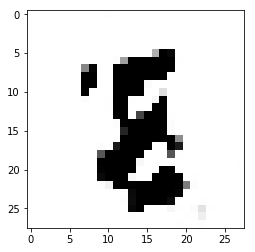

Estimativa: [[ 10.90600014]]
Iteração: 25300 at 2017-10-11 09:10:36.026742


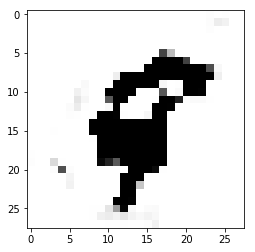

Estimativa: [[ 13.66613293]]
Iteração: 25400 at 2017-10-11 09:10:38.996487


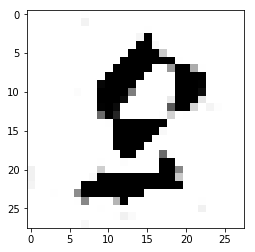

Estimativa: [[ 7.48659706]]
Iteração: 25500 at 2017-10-11 09:10:42.034662


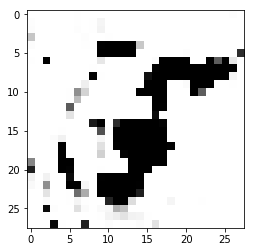

Estimativa: [[ 1.14715683]]
Iteração: 25600 at 2017-10-11 09:10:45.070440


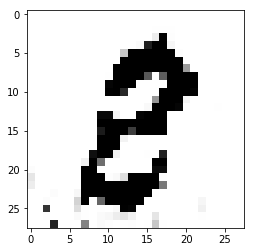

Estimativa: [[-6.55677176]]
Iteração: 25700 at 2017-10-11 09:10:48.084800


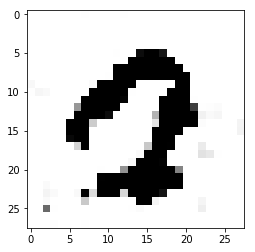

Estimativa: [[ 4.44759893]]
Iteração: 25800 at 2017-10-11 09:10:51.472756


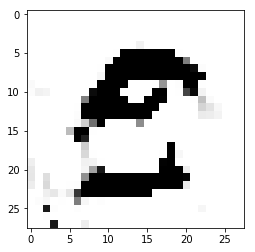

Estimativa: [[ 14.60761929]]
Iteração: 25900 at 2017-10-11 09:10:54.419483


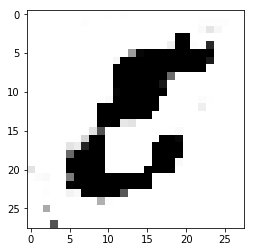

Estimativa: [[ 5.74699163]]
Iteração: 26000 at 2017-10-11 09:10:57.380444


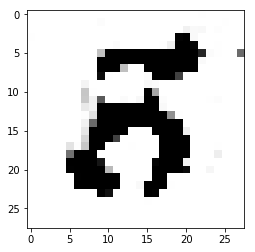

Estimativa: [[ 2.65287375]]
Iteração: 26100 at 2017-10-11 09:11:00.419200


Estimativa: [[ 5.07638741]]
Iteração: 26200 at 2017-10-11 09:11:03.366807


Estimativa: [[ 2.14240813]]
Iteração: 26300 at 2017-10-11 09:11:06.306506


Estimativa: [[ 22.17644882]]
Iteração: 26400 at 2017-10-11 09:11:09.283954


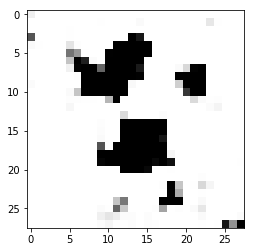

Estimativa: [[ 6.27270555]]
Iteração: 26500 at 2017-10-11 09:11:12.308698


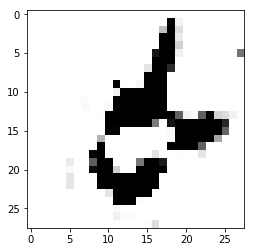

Estimativa: [[ 12.72580242]]
Iteração: 26600 at 2017-10-11 09:11:15.324901


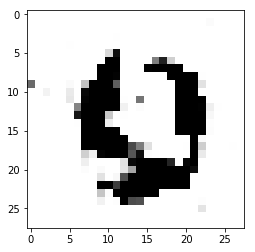

Estimativa: [[ 6.08974981]]
Iteração: 26700 at 2017-10-11 09:11:18.312475


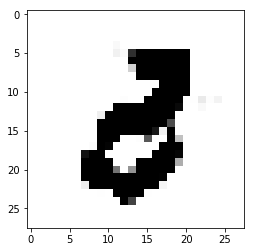

Estimativa: [[ 13.95538998]]
Iteração: 26800 at 2017-10-11 09:11:21.365110


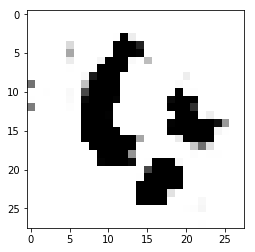

Estimativa: [[ 11.4140377]]
Iteração: 26900 at 2017-10-11 09:11:24.363910


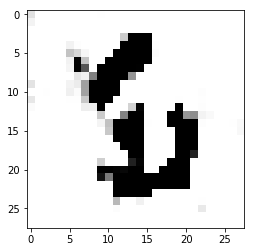

Estimativa: [[ 24.14825821]]
Iteração: 27000 at 2017-10-11 09:11:27.424522


Estimativa: [[ 17.20835114]]
Iteração: 27100 at 2017-10-11 09:11:30.461951


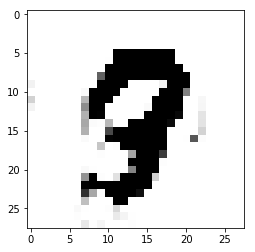

Estimativa: [[ 8.21151066]]
Iteração: 27200 at 2017-10-11 09:11:33.490941


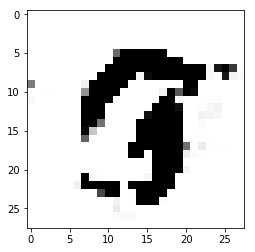

Estimativa: [[-12.3561039]]
Iteração: 27300 at 2017-10-11 09:11:36.617074


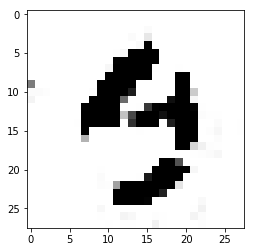

Estimativa: [[ 10.35132408]]
Iteração: 27400 at 2017-10-11 09:11:39.648125


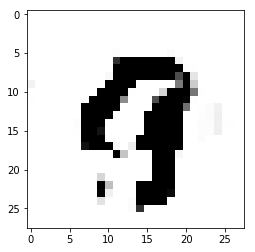

Estimativa: [[ 17.82880974]]
Iteração: 27500 at 2017-10-11 09:11:42.703344


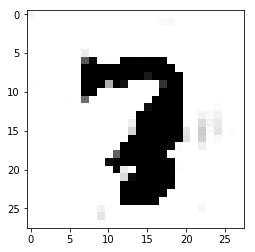

Estimativa: [[ 30.68242645]]
Iteração: 27600 at 2017-10-11 09:11:45.785909


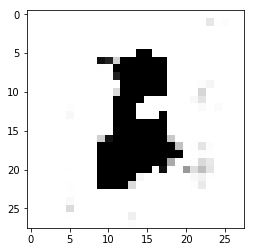

Estimativa: [[-7.18695116]]
Iteração: 27700 at 2017-10-11 09:11:48.861071


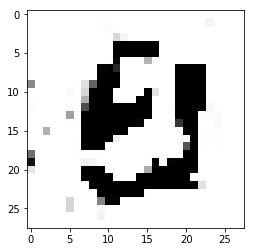

Estimativa: [[ 8.55054474]]
Iteração: 27800 at 2017-10-11 09:11:51.879020


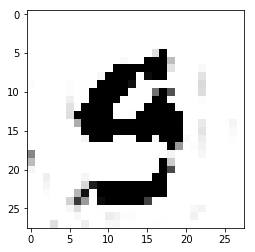

Estimativa: [[-7.12163067]]
Iteração: 27900 at 2017-10-11 09:11:54.929987


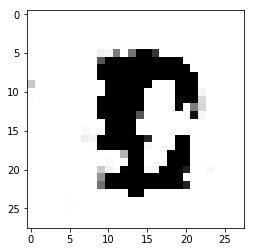

Estimativa: [[ 1.37347221]]
Iteração: 28000 at 2017-10-11 09:11:57.951485


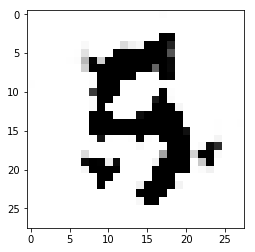

Estimativa: [[ 1.7558471]]
Iteração: 28100 at 2017-10-11 09:12:01.016269


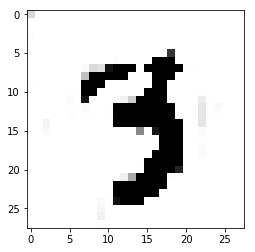

Estimativa: [[ 12.5630579]]
Iteração: 28200 at 2017-10-11 09:12:04.034011


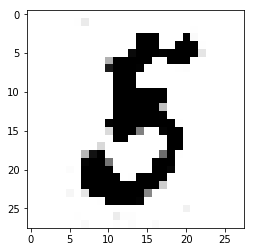

Estimativa: [[ 17.84363174]]
Iteração: 28300 at 2017-10-11 09:12:07.213036


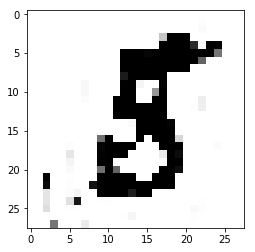

Estimativa: [[-1.99659884]]
Iteração: 28400 at 2017-10-11 09:12:10.297207


Estimativa: [[ 3.09526491]]
Iteração: 28500 at 2017-10-11 09:12:13.320023


Estimativa: [[ 0.02514878]]
Iteração: 28600 at 2017-10-11 09:12:16.354707


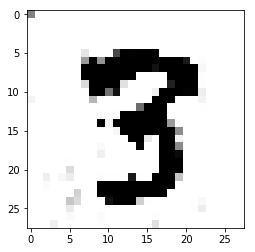

Estimativa: [[ 12.99571419]]
Iteração: 28700 at 2017-10-11 09:12:19.457266


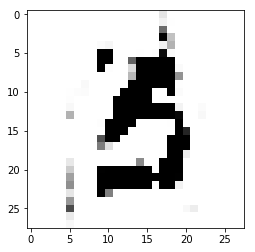

Estimativa: [[ 18.77217102]]
Iteração: 28800 at 2017-10-11 09:12:22.461947


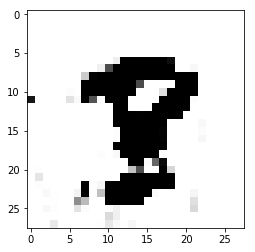

Estimativa: [[ 4.13759279]]
Iteração: 28900 at 2017-10-11 09:12:25.596492


Estimativa: [[ 7.13681698]]
Iteração: 29000 at 2017-10-11 09:12:28.662036


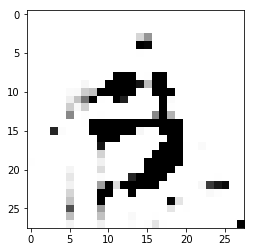

Estimativa: [[ 15.40640831]]
Iteração: 29100 at 2017-10-11 09:12:31.808016


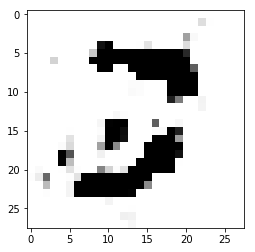

Estimativa: [[ 2.73165965]]
Iteração: 29200 at 2017-10-11 09:12:34.845635


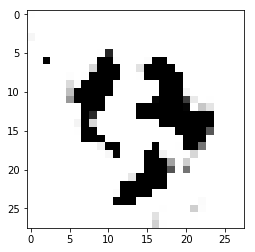

Estimativa: [[-4.56969023]]
Iteração: 29300 at 2017-10-11 09:12:37.951237


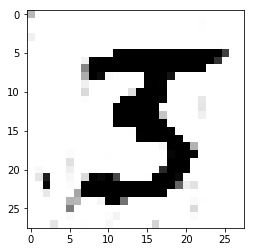

Estimativa: [[ 15.82129192]]
Iteração: 29400 at 2017-10-11 09:12:41.062614


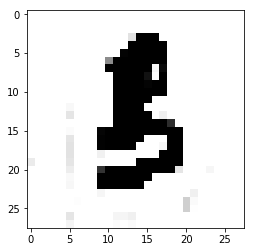

Estimativa: [[ 9.57795811]]
Iteração: 29500 at 2017-10-11 09:12:44.204452


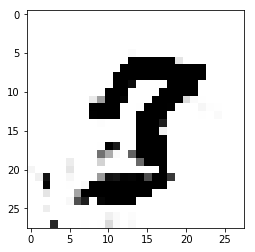

Estimativa: [[-3.97573447]]
Iteração: 29600 at 2017-10-11 09:12:47.734906


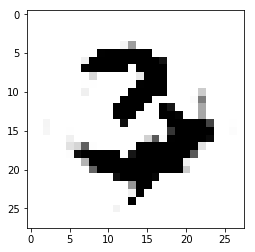

Estimativa: [[ 8.86685944]]
Iteração: 29700 at 2017-10-11 09:12:50.774718


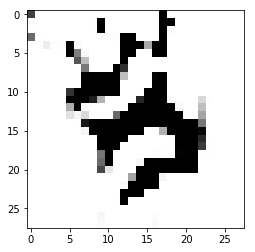

Estimativa: [[-0.55572373]]
Iteração: 29800 at 2017-10-11 09:12:53.869624


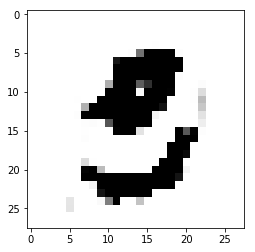

Estimativa: [[-9.06640339]]
Iteração: 29900 at 2017-10-11 09:12:56.966968


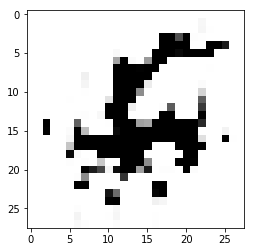

Estimativa: [[ 14.70657444]]
Iteração: 30000 at 2017-10-11 09:13:00.169083


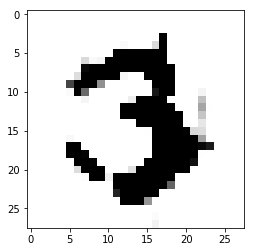

Estimativa: [[-18.92046165]]
Iteração: 30100 at 2017-10-11 09:13:03.272216


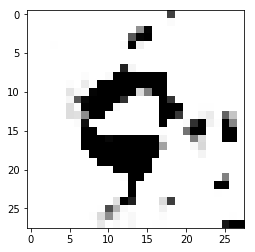

Estimativa: [[ 6.93449593]]
Iteração: 30200 at 2017-10-11 09:13:06.396819


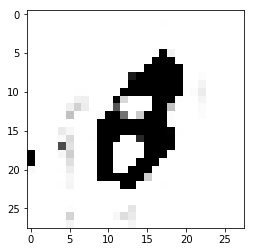

Estimativa: [[ 7.0262084]]
Iteração: 30300 at 2017-10-11 09:13:09.551909


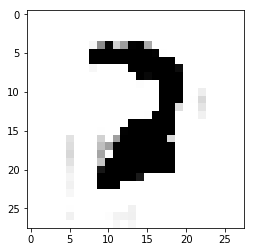

Estimativa: [[ 9.43919468]]
Iteração: 30400 at 2017-10-11 09:13:12.638378


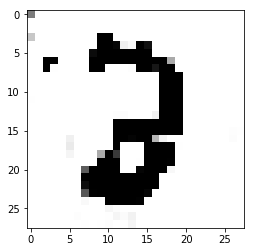

Estimativa: [[ 17.68680382]]
Iteração: 30500 at 2017-10-11 09:13:15.780743


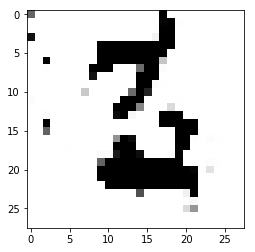

Estimativa: [[ 7.96563053]]
Iteração: 30600 at 2017-10-11 09:13:18.885270


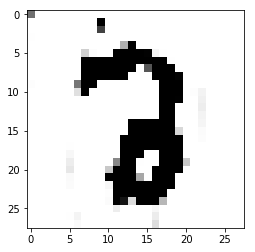

Estimativa: [[ 0.74245042]]
Iteração: 30700 at 2017-10-11 09:13:21.985614


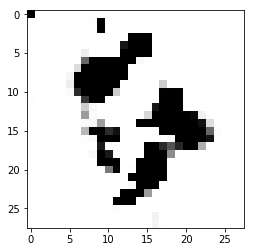

Estimativa: [[ 14.93543243]]
Iteração: 30800 at 2017-10-11 09:13:25.093731


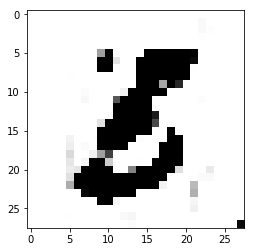

Estimativa: [[ 4.60189581]]
Iteração: 30900 at 2017-10-11 09:13:28.212348


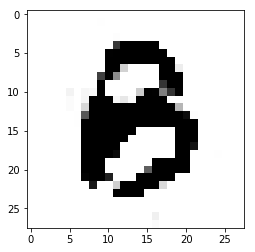

Estimativa: [[ 29.04561043]]
Iteração: 31000 at 2017-10-11 09:13:31.519360


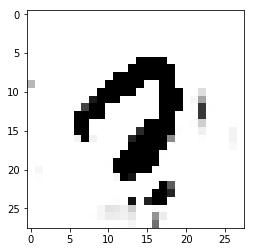

Estimativa: [[-1.57388735]]
Iteração: 31100 at 2017-10-11 09:13:34.609380


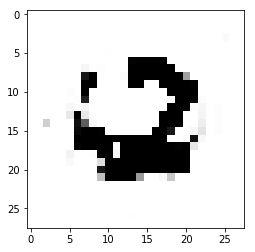

Estimativa: [[ 7.04501343]]
Iteração: 31200 at 2017-10-11 09:13:37.846601


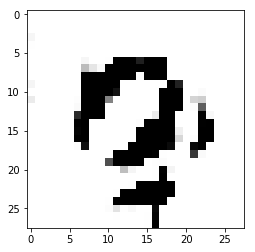

Estimativa: [[-13.420434]]
Iteração: 31300 at 2017-10-11 09:13:41.000090


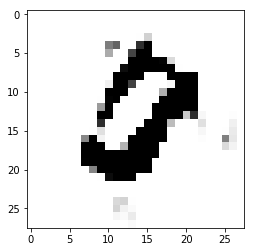

Estimativa: [[ 5.06523943]]
Iteração: 31400 at 2017-10-11 09:13:44.101537


Estimativa: [[ 11.4837532]]
Iteração: 31500 at 2017-10-11 09:13:47.229520


Estimativa: [[-2.64684987]]
Iteração: 31600 at 2017-10-11 09:13:50.383415


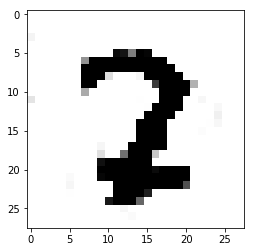

Estimativa: [[ 16.71774292]]
Iteração: 31700 at 2017-10-11 09:13:53.476852


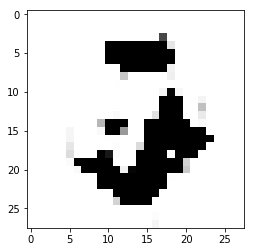

Estimativa: [[-15.46698666]]
Iteração: 31800 at 2017-10-11 09:13:56.659614


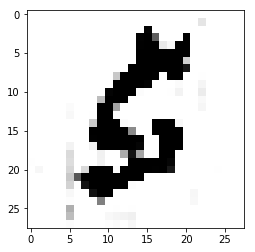

Estimativa: [[ 6.87157106]]
Iteração: 31900 at 2017-10-11 09:13:59.780509


Estimativa: [[ 1.36721814]]
Iteração: 32000 at 2017-10-11 09:14:02.943241


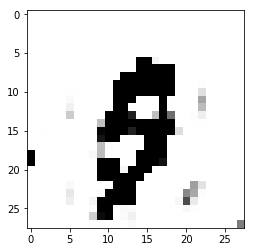

Estimativa: [[ 6.74675035]]
Iteração: 32100 at 2017-10-11 09:14:06.055755


Estimativa: [[ 4.11210394]]
Iteração: 32200 at 2017-10-11 09:14:09.163129


Estimativa: [[-4.34331083]]
Iteração: 32300 at 2017-10-11 09:14:12.433695


Estimativa: [[ 2.56232238]]
Iteração: 32400 at 2017-10-11 09:14:15.702963


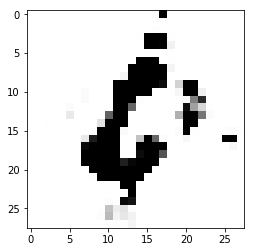

Estimativa: [[ 13.07548428]]
Iteração: 32500 at 2017-10-11 09:14:18.816367


Estimativa: [[ 8.57361984]]
Iteração: 32600 at 2017-10-11 09:14:21.990847


Estimativa: [[-27.63710213]]
Iteração: 32700 at 2017-10-11 09:14:25.183933


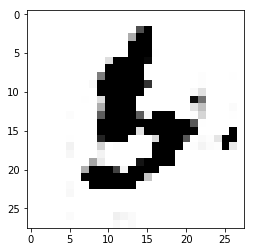

Estimativa: [[ 11.42695904]]
Iteração: 32800 at 2017-10-11 09:14:28.337846


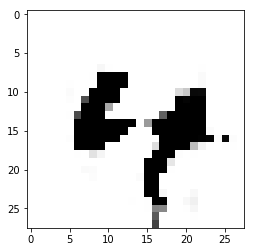

Estimativa: [[ 17.66526794]]
Iteração: 32900 at 2017-10-11 09:14:31.471295


Estimativa: [[-3.47557569]]
Iteração: 33000 at 2017-10-11 09:14:34.631188


Estimativa: [[ 4.52430439]]
Iteração: 33100 at 2017-10-11 09:14:37.828399


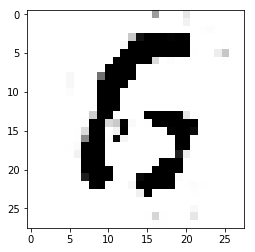

Estimativa: [[ 4.13029575]]
Iteração: 33200 at 2017-10-11 09:14:40.995119


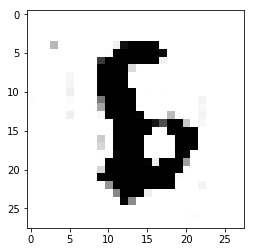

Estimativa: [[ 6.8656559]]
Iteração: 33300 at 2017-10-11 09:14:44.144952


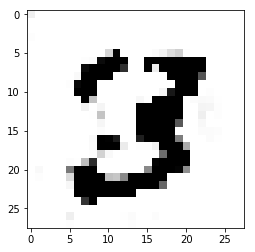

Estimativa: [[ 5.2623105]]
Iteração: 33400 at 2017-10-11 09:14:47.416839


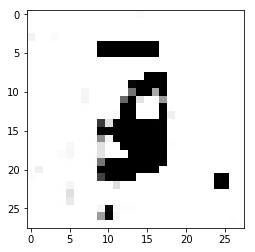

Estimativa: [[ 5.23436213]]
Iteração: 33500 at 2017-10-11 09:14:50.588561


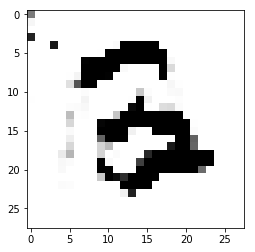

Estimativa: [[-16.36796379]]
Iteração: 33600 at 2017-10-11 09:14:53.798563


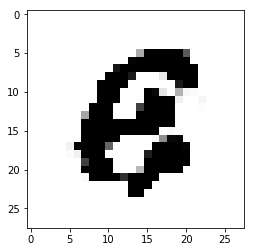

Estimativa: [[-9.82043076]]
Iteração: 33700 at 2017-10-11 09:14:57.000557


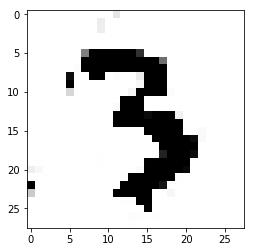

Estimativa: [[ 12.35320663]]
Iteração: 33800 at 2017-10-11 09:15:00.306153


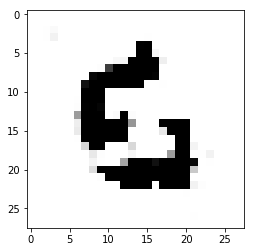

Estimativa: [[-21.85063934]]
Iteração: 33900 at 2017-10-11 09:15:04.064614


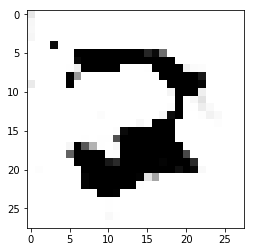

Estimativa: [[ 15.56105518]]
Iteração: 34000 at 2017-10-11 09:15:07.352315


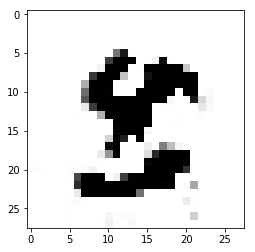

Estimativa: [[ 1.81544733]]
Iteração: 34100 at 2017-10-11 09:15:10.608003


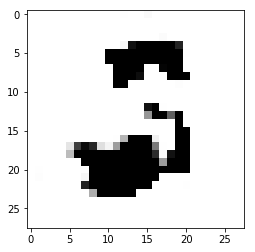

Estimativa: [[-19.17445374]]
Iteração: 34200 at 2017-10-11 09:15:13.880595


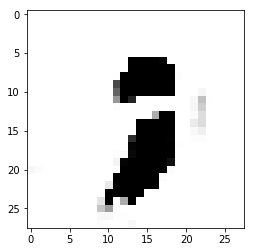

Estimativa: [[-4.09294271]]
Iteração: 34300 at 2017-10-11 09:15:17.058525


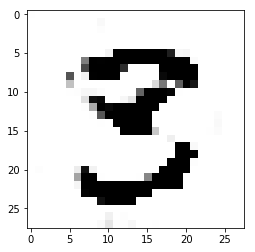

Estimativa: [[-10.98973083]]
Iteração: 34400 at 2017-10-11 09:15:20.276766


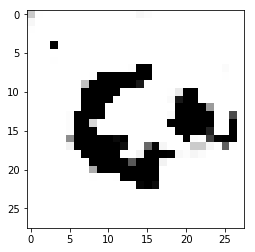

Estimativa: [[-5.83092213]]
Iteração: 34500 at 2017-10-11 09:15:23.505738


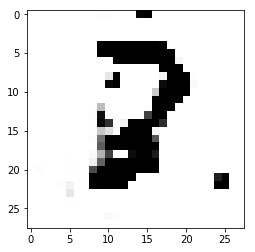

Estimativa: [[ 1.75855267]]
Iteração: 34600 at 2017-10-11 09:15:26.781899


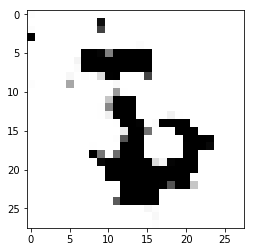

Estimativa: [[ 2.1542716]]
Iteração: 34700 at 2017-10-11 09:15:30.008555


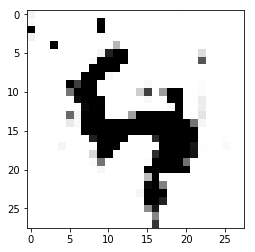

Estimativa: [[ 15.01564217]]
Iteração: 34800 at 2017-10-11 09:15:33.264433


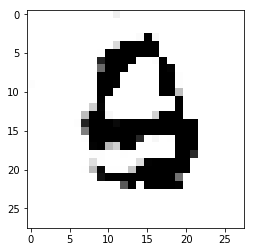

Estimativa: [[-4.85074806]]
Iteração: 34900 at 2017-10-11 09:15:36.643211


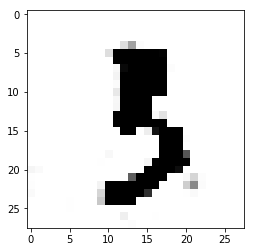

Estimativa: [[ 0.3588917]]
Iteração: 35000 at 2017-10-11 09:15:40.095014


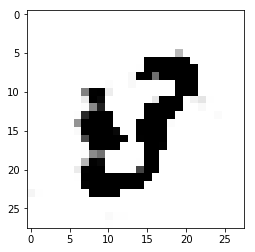

Estimativa: [[ 9.76209354]]
Iteração: 35100 at 2017-10-11 09:15:43.352377


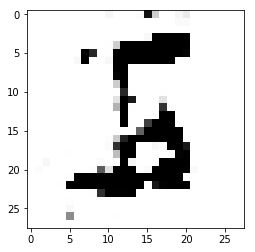

Estimativa: [[-4.87045145]]
Iteração: 35200 at 2017-10-11 09:15:46.622695


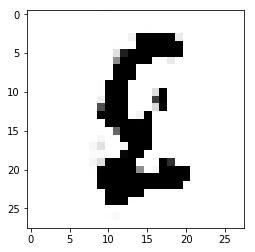

Estimativa: [[ 18.07523918]]
Iteração: 35300 at 2017-10-11 09:15:49.821185


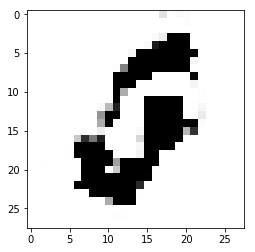

Estimativa: [[ 0.07210378]]
Iteração: 35400 at 2017-10-11 09:15:53.047157


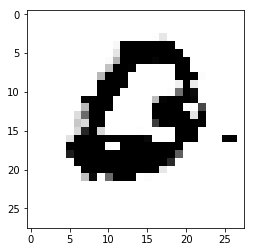

Estimativa: [[ 8.05079651]]
Iteração: 35500 at 2017-10-11 09:15:56.407845


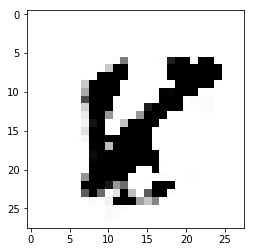

Estimativa: [[ 21.50556183]]
Iteração: 35600 at 2017-10-11 09:15:59.731957


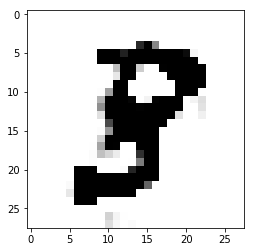

Estimativa: [[ 10.15822411]]
Iteração: 35700 at 2017-10-11 09:16:03.051633


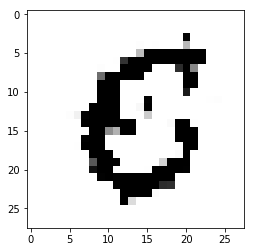

Estimativa: [[ 7.19483662]]
Iteração: 35800 at 2017-10-11 09:16:06.289850


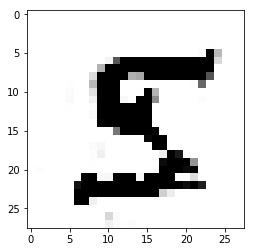

Estimativa: [[ 5.82979059]]
Iteração: 35900 at 2017-10-11 09:16:09.510220


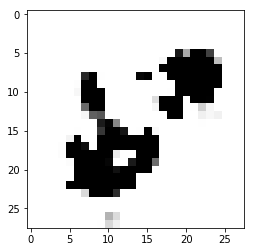

Estimativa: [[ 2.7174654]]
Iteração: 36000 at 2017-10-11 09:16:12.787639


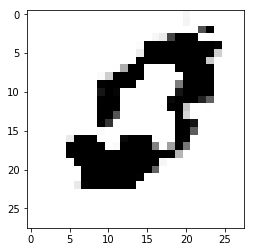

Estimativa: [[ 10.36013985]]
Iteração: 36100 at 2017-10-11 09:16:16.117328


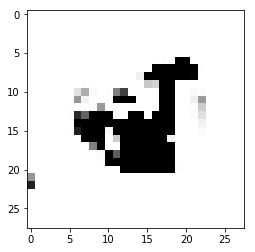

Estimativa: [[ 14.82117748]]
Iteração: 36200 at 2017-10-11 09:16:19.372632


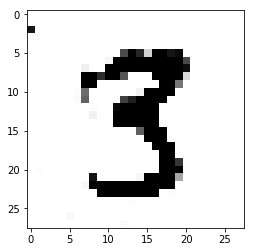

Estimativa: [[ 4.09092999]]
Iteração: 36300 at 2017-10-11 09:16:22.636057


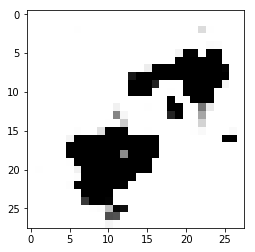

Estimativa: [[ 11.04683971]]
Iteração: 36400 at 2017-10-11 09:16:26.159155


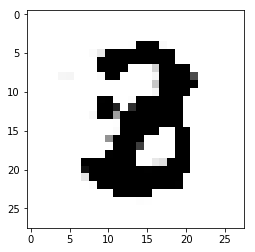

Estimativa: [[ 5.25707293]]
Iteração: 36500 at 2017-10-11 09:16:29.427994


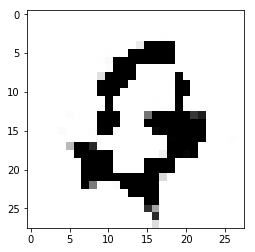

Estimativa: [[ 3.12267232]]
Iteração: 36600 at 2017-10-11 09:16:32.668815


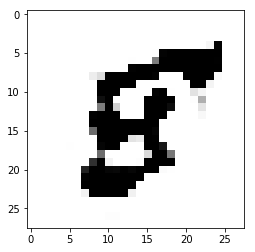

Estimativa: [[ 10.53719521]]
Iteração: 36700 at 2017-10-11 09:16:35.931553


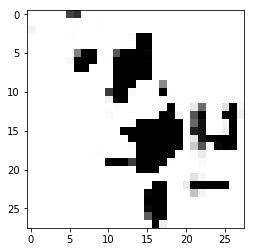

Estimativa: [[ 15.4170475]]
Iteração: 36800 at 2017-10-11 09:16:39.244228


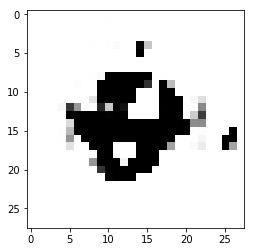

Estimativa: [[ 0.68545234]]
Iteração: 36900 at 2017-10-11 09:16:42.527238


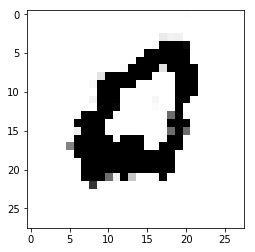

Estimativa: [[ 8.94668865]]
Iteração: 37000 at 2017-10-11 09:16:45.824188


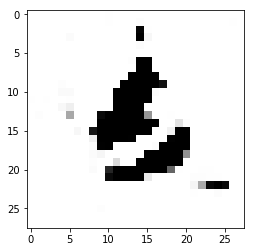

Estimativa: [[ 20.63832283]]
Iteração: 37100 at 2017-10-11 09:16:49.127343


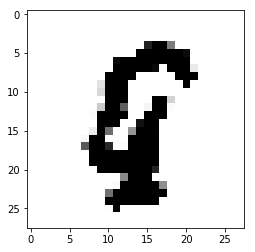

Estimativa: [[ 21.43232155]]
Iteração: 37200 at 2017-10-11 09:16:52.527772


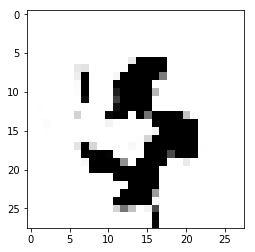

Estimativa: [[-8.05945969]]
Iteração: 37300 at 2017-10-11 09:16:55.859616


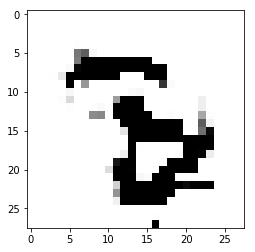

Estimativa: [[ 8.87522793]]
Iteração: 37400 at 2017-10-11 09:16:59.147966


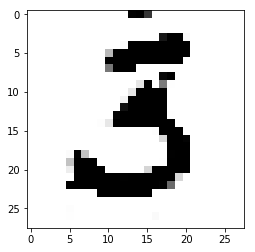

Estimativa: [[ 5.93760681]]
Iteração: 37500 at 2017-10-11 09:17:02.444861


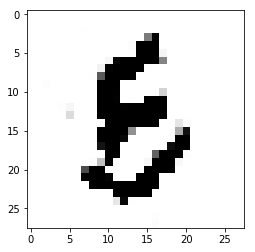

Estimativa: [[ 15.09979343]]
Iteração: 37600 at 2017-10-11 09:17:05.739151


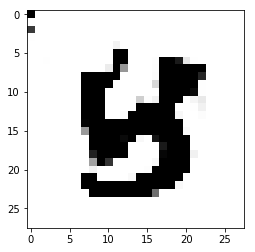

Estimativa: [[ 17.44484901]]
Iteração: 37700 at 2017-10-11 09:17:09.142426


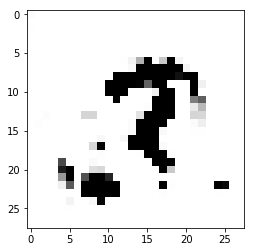

Estimativa: [[-20.07198715]]
Iteração: 37800 at 2017-10-11 09:17:12.457930


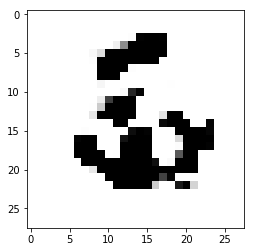

Estimativa: [[ 8.37657833]]
Iteração: 37900 at 2017-10-11 09:17:15.735631


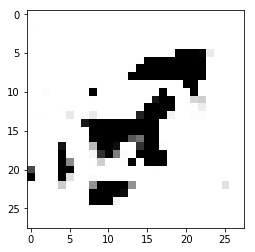

Estimativa: [[ 0.29709035]]
Iteração: 38000 at 2017-10-11 09:17:19.039513


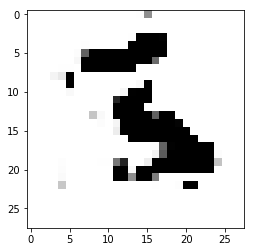

Estimativa: [[-7.1875267]]
Iteração: 38100 at 2017-10-11 09:17:22.356343


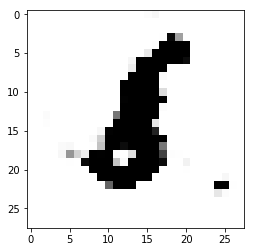

Estimativa: [[-1.45729291]]
Iteração: 38200 at 2017-10-11 09:17:25.815130


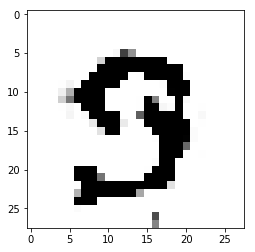

Estimativa: [[ 3.50462127]]
Iteração: 38300 at 2017-10-11 09:17:29.189651


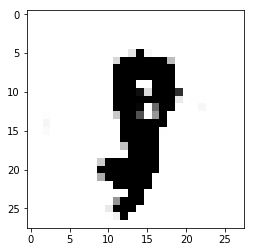

Estimativa: [[ 14.65626144]]
Iteração: 38400 at 2017-10-11 09:17:32.597055


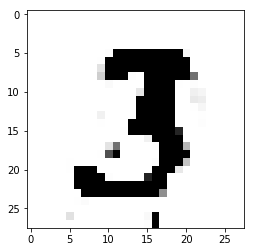

Estimativa: [[-6.44844818]]
Iteração: 38500 at 2017-10-11 09:17:35.910721


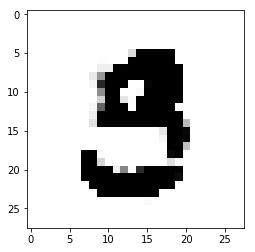

Estimativa: [[-3.54403591]]
Iteração: 38600 at 2017-10-11 09:17:39.726789


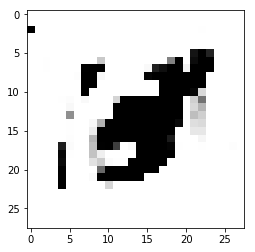

Estimativa: [[ 13.29216766]]
Iteração: 38700 at 2017-10-11 09:17:43.044699


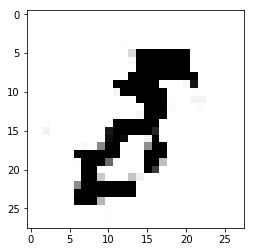

Estimativa: [[ 21.34568214]]
Iteração: 38800 at 2017-10-11 09:17:46.355214


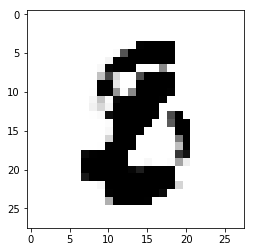

Estimativa: [[ 3.57638001]]
Iteração: 38900 at 2017-10-11 09:17:49.666291


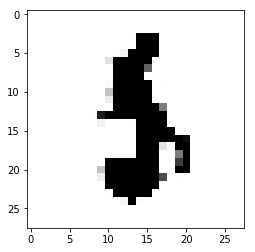

Estimativa: [[ 4.94783115]]
Iteração: 39000 at 2017-10-11 09:17:53.089757


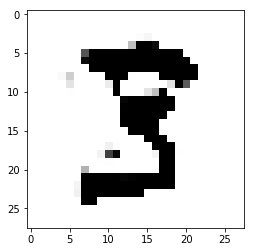

Estimativa: [[-3.89438081]]
Iteração: 39100 at 2017-10-11 09:17:56.431180


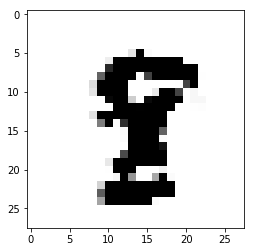

Estimativa: [[ 23.52495766]]
Iteração: 39200 at 2017-10-11 09:17:59.908632


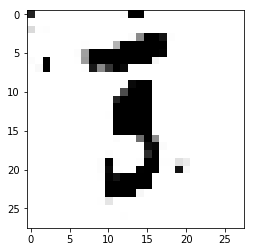

Estimativa: [[-5.02399874]]
Iteração: 39300 at 2017-10-11 09:18:03.309333


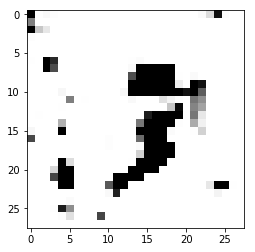

Estimativa: [[-29.51067543]]
Iteração: 39400 at 2017-10-11 09:18:06.806046


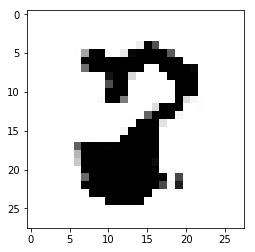

Estimativa: [[-15.26131725]]
Iteração: 39500 at 2017-10-11 09:18:10.130304


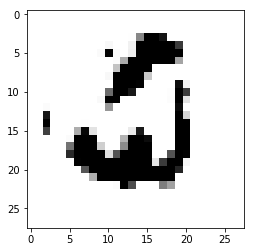

Estimativa: [[-2.67278385]]
Iteração: 39600 at 2017-10-11 09:18:13.487149


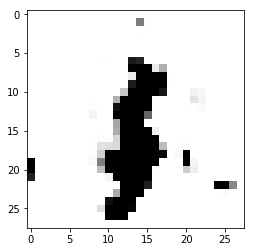

Estimativa: [[ 4.56021595]]
Iteração: 39700 at 2017-10-11 09:18:16.830321


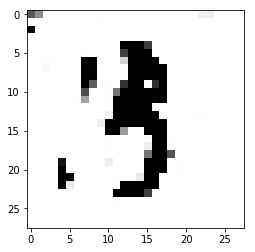

Estimativa: [[-13.39827919]]
Iteração: 39800 at 2017-10-11 09:18:20.206095


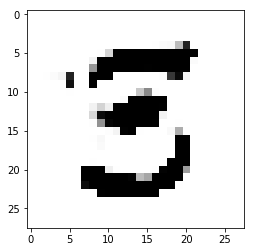

Estimativa: [[ 6.00081921]]
Iteração: 39900 at 2017-10-11 09:18:23.728855


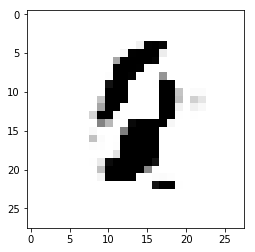

Estimativa: [[-2.06369162]]
Iteração: 40000 at 2017-10-11 09:18:27.147592


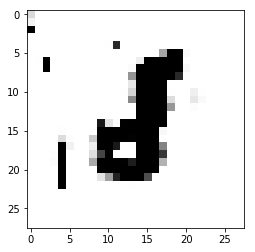

Estimativa: [[ 9.27144241]]
Iteração: 40100 at 2017-10-11 09:18:30.519068


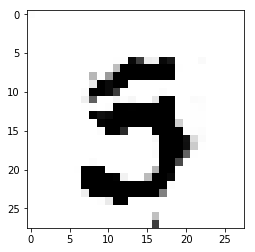

Estimativa: [[-7.90132666]]
Iteração: 40200 at 2017-10-11 09:18:33.902117


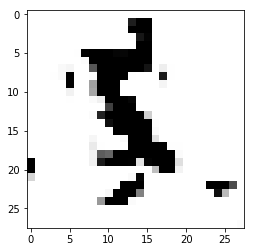

Estimativa: [[-27.6755867]]
Iteração: 40300 at 2017-10-11 09:18:37.302225


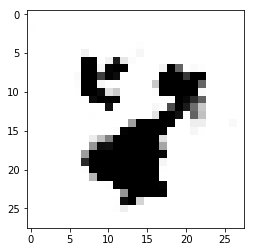

Estimativa: [[-7.45945263]]
Iteração: 40400 at 2017-10-11 09:18:40.766633


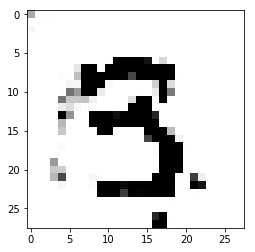

Estimativa: [[ 1.99604356]]
Iteração: 40500 at 2017-10-11 09:18:44.228015


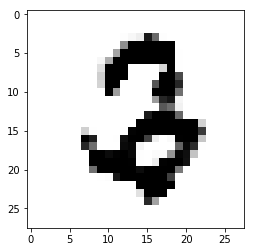

Estimativa: [[ 17.86701393]]
Iteração: 40600 at 2017-10-11 09:18:47.666180


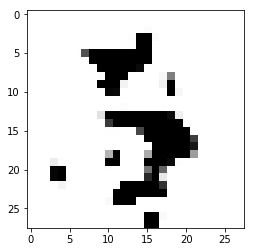

Estimativa: [[ 24.5442028]]
Iteração: 40700 at 2017-10-11 09:18:51.137001


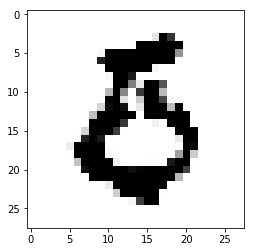

Estimativa: [[ 6.53363991]]
Iteração: 40800 at 2017-10-11 09:18:54.624464


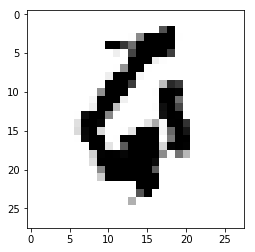

Estimativa: [[-11.06432152]]
Iteração: 40900 at 2017-10-11 09:18:57.988552


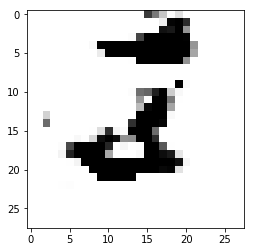

Estimativa: [[-24.09459114]]
Iteração: 41000 at 2017-10-11 09:19:01.374424


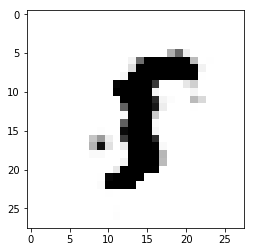

Estimativa: [[ 24.06424713]]
Iteração: 41100 at 2017-10-11 09:19:04.766201


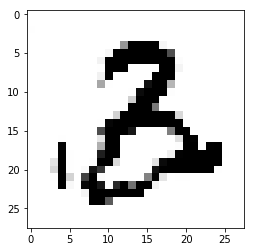

Estimativa: [[ 15.92850208]]
Iteração: 41200 at 2017-10-11 09:19:08.212929


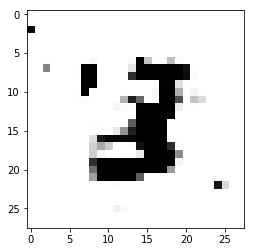

Estimativa: [[-9.16151905]]
Iteração: 41300 at 2017-10-11 09:19:11.634164


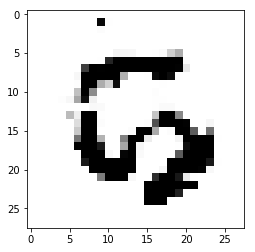

Estimativa: [[-29.3457489]]
Iteração: 41400 at 2017-10-11 09:19:15.152176


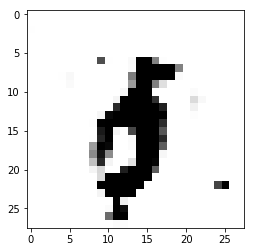

Estimativa: [[-1.60308325]]
Iteração: 41500 at 2017-10-11 09:19:18.620786


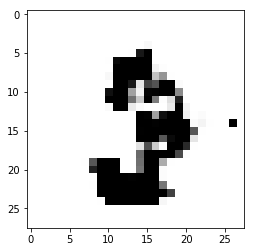

Estimativa: [[ 1.62146854]]
Iteração: 41600 at 2017-10-11 09:19:22.002131


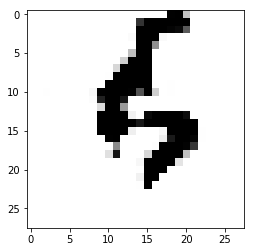

Estimativa: [[ 33.76867294]]
Iteração: 41700 at 2017-10-11 09:19:25.452455


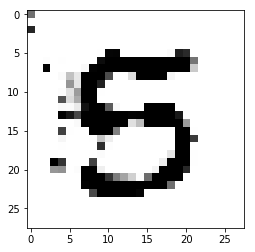

Estimativa: [[ 23.10640144]]
Iteração: 41800 at 2017-10-11 09:19:28.866822


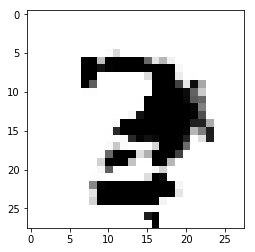

Estimativa: [[ 15.76298714]]
Iteração: 41900 at 2017-10-11 09:19:32.277997


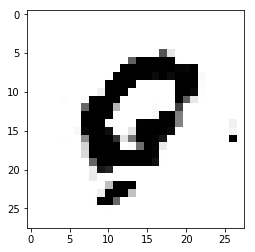

Estimativa: [[ 19.54869461]]
Iteração: 42000 at 2017-10-11 09:19:35.812202


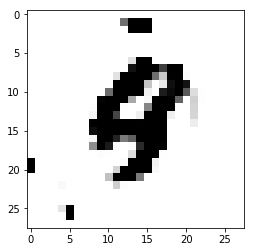

Estimativa: [[ 10.42875576]]
Iteração: 42100 at 2017-10-11 09:19:39.284134


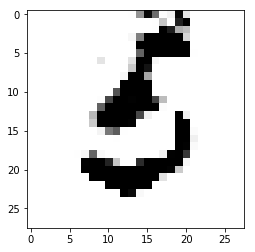

Estimativa: [[-14.47987461]]
Iteração: 42200 at 2017-10-11 09:19:42.726205


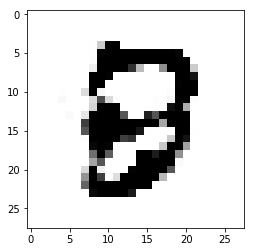

Estimativa: [[ 2.1296773]]
Iteração: 42300 at 2017-10-11 09:19:46.204137


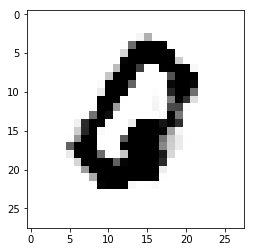

Estimativa: [[-4.67150259]]
Iteração: 42400 at 2017-10-11 09:19:49.664882


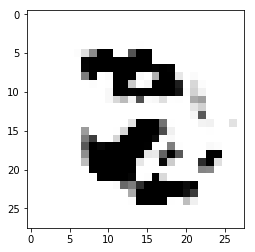

Estimativa: [[ 9.92397022]]
Iteração: 42500 at 2017-10-11 09:19:53.123631


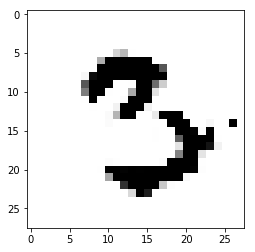

Estimativa: [[ 11.02806759]]
Iteração: 42600 at 2017-10-11 09:19:56.643223


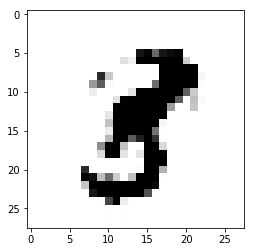

Estimativa: [[ 9.83672523]]
Iteração: 42700 at 2017-10-11 09:20:00.104602


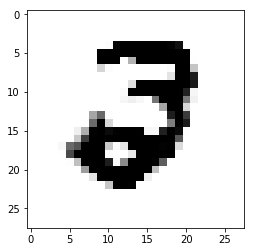

Estimativa: [[ 39.6054039]]
Iteração: 42800 at 2017-10-11 09:20:03.675486


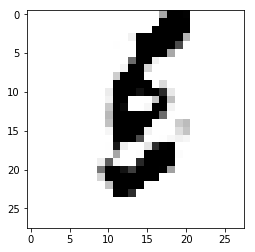

Estimativa: [[ 6.97402334]]
Iteração: 42900 at 2017-10-11 09:20:07.217495


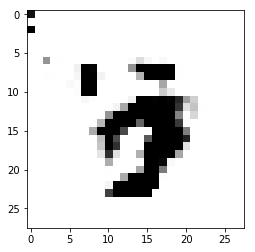

Estimativa: [[ 10.27843094]]
Iteração: 43000 at 2017-10-11 09:20:10.732775


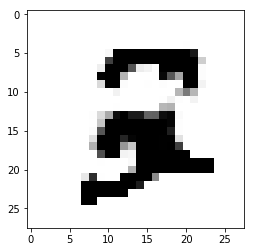

Estimativa: [[ 13.16959]]
Iteração: 43100 at 2017-10-11 09:20:14.174586


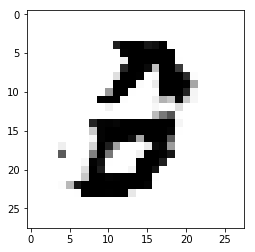

Estimativa: [[-3.09331179]]
Iteração: 43200 at 2017-10-11 09:20:17.652000


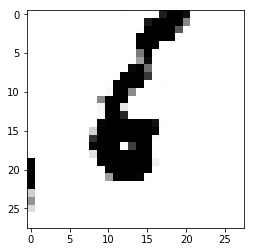

Estimativa: [[ 32.28099823]]
Iteração: 43300 at 2017-10-11 09:20:21.108807


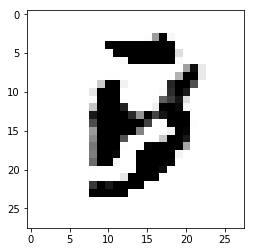

Estimativa: [[ 24.09353065]]
Iteração: 43400 at 2017-10-11 09:20:24.683864


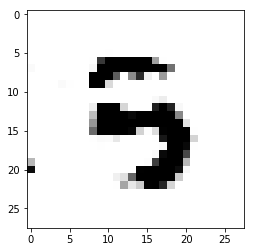

Estimativa: [[ 18.71823311]]
Iteração: 43500 at 2017-10-11 09:20:28.294064


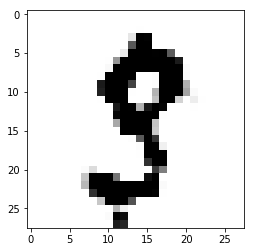

Estimativa: [[ 12.03399944]]
Iteração: 43600 at 2017-10-11 09:20:31.801240


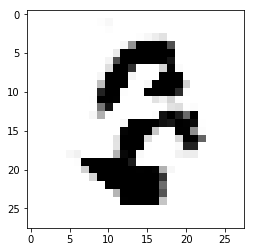

Estimativa: [[ 7.86975813]]
Iteração: 43700 at 2017-10-11 09:20:35.336558


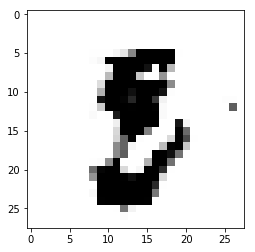

Estimativa: [[ 10.18044758]]
Iteração: 43800 at 2017-10-11 09:20:38.893162


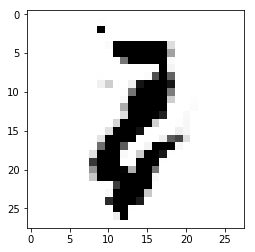

Estimativa: [[ 13.00941086]]
Iteração: 43900 at 2017-10-11 09:20:42.472474


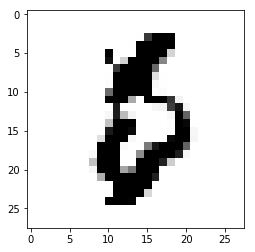

Estimativa: [[-7.41252947]]
Iteração: 44000 at 2017-10-11 09:20:46.558344


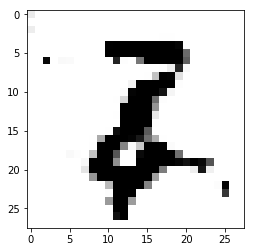

Estimativa: [[ 2.23678589]]
Iteração: 44100 at 2017-10-11 09:20:50.044165


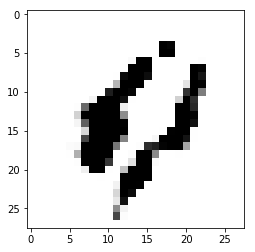

Estimativa: [[ 0.74493766]]
Iteração: 44200 at 2017-10-11 09:20:53.874474


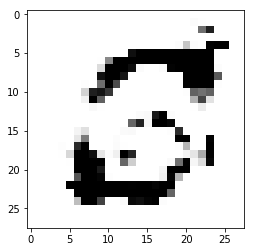

Estimativa: [[-19.48176765]]
Iteração: 44300 at 2017-10-11 09:20:57.378908


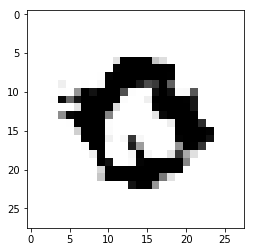

Estimativa: [[ 12.13296127]]
Iteração: 44400 at 2017-10-11 09:21:00.863945


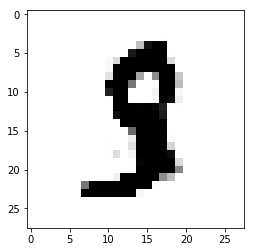

Estimativa: [[ 12.14101982]]
Iteração: 44500 at 2017-10-11 09:21:04.474847


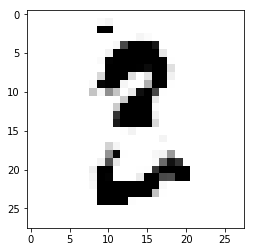

Estimativa: [[ 45.19790268]]
Iteração: 44600 at 2017-10-11 09:21:07.968871


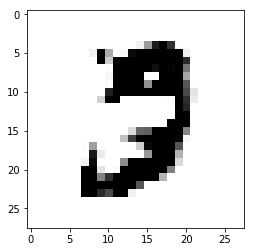

Estimativa: [[-2.58079672]]
Iteração: 44700 at 2017-10-11 09:21:11.459926


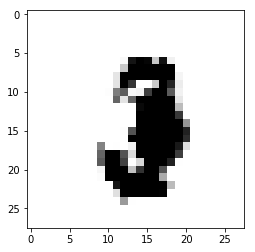

Estimativa: [[ 16.24689674]]
Iteração: 44800 at 2017-10-11 09:21:15.004860


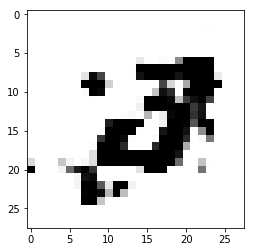

Estimativa: [[-29.27326775]]
Iteração: 44900 at 2017-10-11 09:21:18.510989


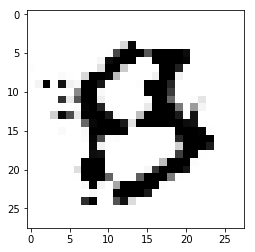

Estimativa: [[-1.13115227]]
Iteração: 45000 at 2017-10-11 09:21:22.018460


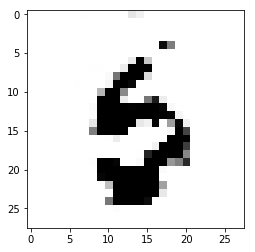

Estimativa: [[-5.79893732]]
Iteração: 45100 at 2017-10-11 09:21:25.595355


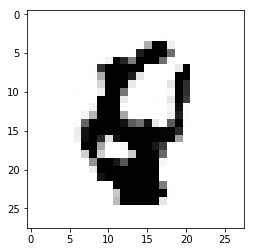

Estimativa: [[ 18.36841393]]
Iteração: 45200 at 2017-10-11 09:21:29.131316


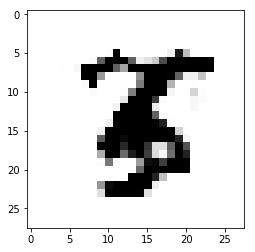

Estimativa: [[-8.74970341]]
Iteração: 45300 at 2017-10-11 09:21:32.669174


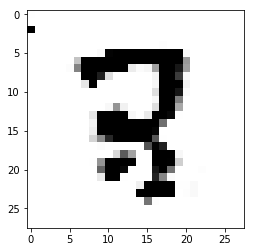

Estimativa: [[ 7.371243]]
Iteração: 45400 at 2017-10-11 09:21:36.209018


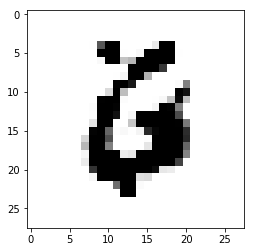

Estimativa: [[-0.38661015]]
Iteração: 45500 at 2017-10-11 09:21:39.862328


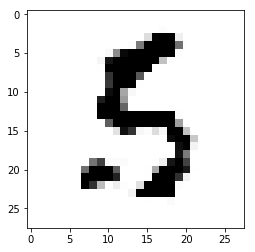

Estimativa: [[-37.93831635]]
Iteração: 45600 at 2017-10-11 09:21:43.510650


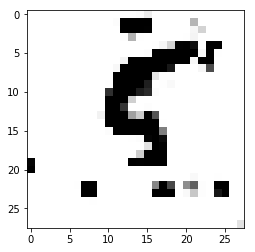

Estimativa: [[ 38.01677704]]
Iteração: 45700 at 2017-10-11 09:21:47.061111


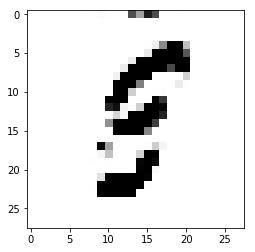

Estimativa: [[-14.41050148]]
Iteração: 45800 at 2017-10-11 09:21:50.582499


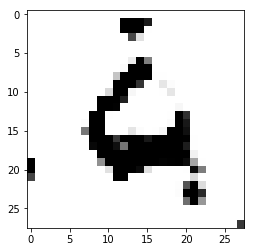

Estimativa: [[ 18.39323997]]
Iteração: 45900 at 2017-10-11 09:21:54.172618


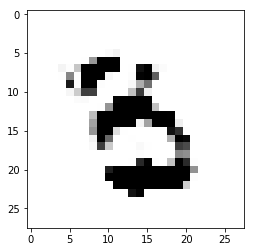

Estimativa: [[-10.81892872]]
Iteração: 46000 at 2017-10-11 09:21:57.716173


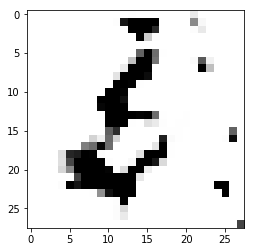

Estimativa: [[-24.11300659]]
Iteração: 46100 at 2017-10-11 09:22:01.258433


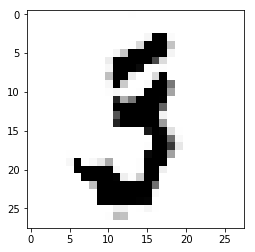

Estimativa: [[ 7.45871544]]
Iteração: 46200 at 2017-10-11 09:22:04.845787


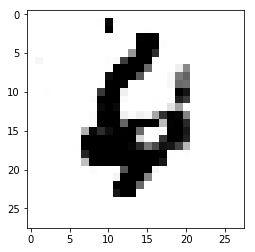

Estimativa: [[ 14.06714439]]
Iteração: 46300 at 2017-10-11 09:22:08.388356


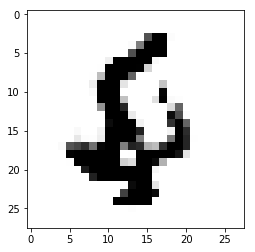

Estimativa: [[ 9.63906479]]
Iteração: 46400 at 2017-10-11 09:22:12.204883


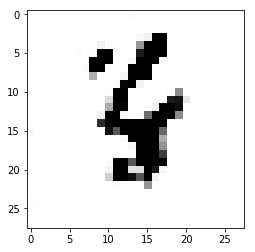

Estimativa: [[-14.3840313]]
Iteração: 46500 at 2017-10-11 09:22:15.752016


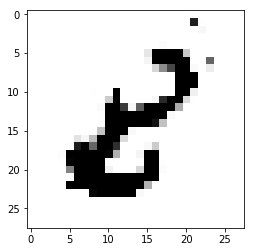

Estimativa: [[ 8.01744366]]
Iteração: 46600 at 2017-10-11 09:22:19.322475


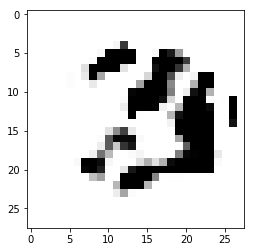

Estimativa: [[-8.33538628]]
Iteração: 46700 at 2017-10-11 09:22:23.007460


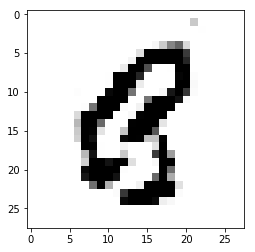

Estimativa: [[ 16.64427757]]
Iteração: 46800 at 2017-10-11 09:22:26.568252


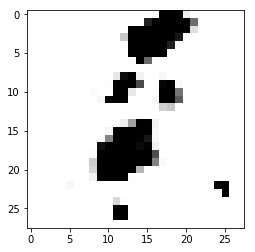

Estimativa: [[-3.58030891]]
Iteração: 46900 at 2017-10-11 09:22:30.167495


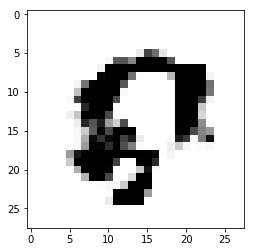

Estimativa: [[ 0.79583097]]
Iteração: 47000 at 2017-10-11 09:22:33.789206


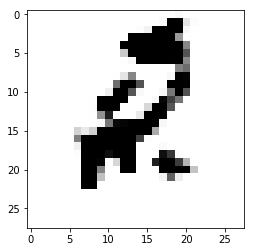

Estimativa: [[ 17.27674103]]
Iteração: 47100 at 2017-10-11 09:22:37.377698


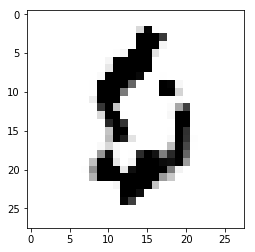

Estimativa: [[ 0.09092467]]
Iteração: 47200 at 2017-10-11 09:22:41.060126


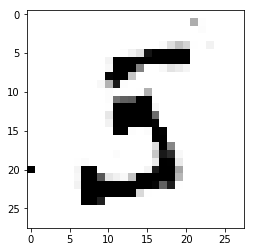

Estimativa: [[-3.97162318]]
Iteração: 47300 at 2017-10-11 09:22:44.631970


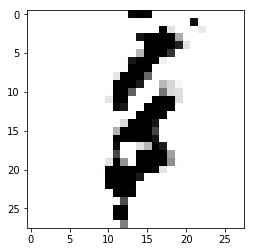

Estimativa: [[-14.87987709]]
Iteração: 47400 at 2017-10-11 09:22:48.264858


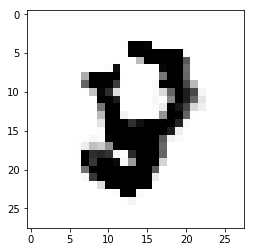

Estimativa: [[-24.20908737]]
Iteração: 47500 at 2017-10-11 09:22:51.852636


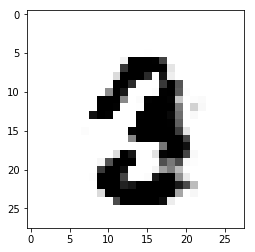

Estimativa: [[-3.52508235]]
Iteração: 47600 at 2017-10-11 09:22:55.457465


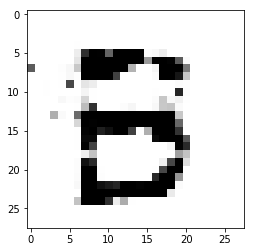

Estimativa: [[-13.25544357]]
Iteração: 47700 at 2017-10-11 09:22:59.044334


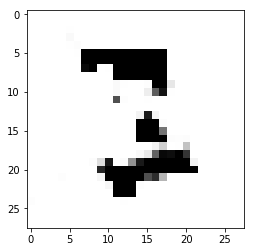

Estimativa: [[-8.346488]]
Iteração: 47800 at 2017-10-11 09:23:02.659924


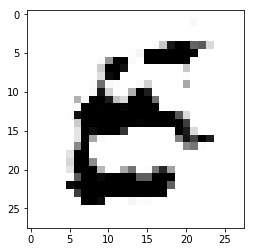

Estimativa: [[-21.55736923]]
Iteração: 47900 at 2017-10-11 09:23:06.283213


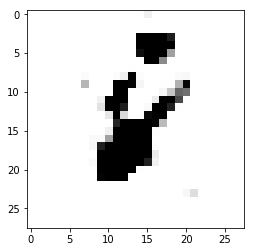

Estimativa: [[ 5.7025938]]
Iteração: 48000 at 2017-10-11 09:23:09.954725


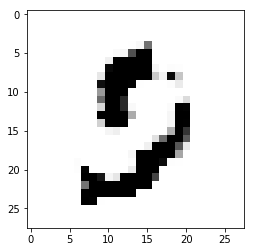

Estimativa: [[-21.26341057]]
Iteração: 48100 at 2017-10-11 09:23:13.728757


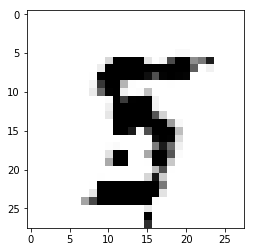

Estimativa: [[-2.43513298]]
Iteração: 48200 at 2017-10-11 09:23:17.335972


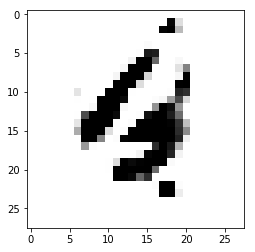

Estimativa: [[ 11.08429813]]
Iteração: 48300 at 2017-10-11 09:23:20.962293


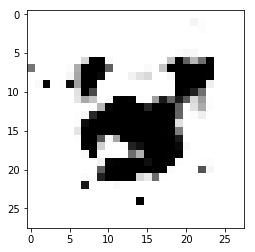

Estimativa: [[-11.7167902]]
Iteração: 48400 at 2017-10-11 09:23:24.583595


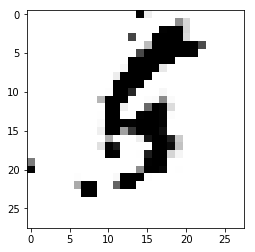

Estimativa: [[-25.3453083]]
Iteração: 48500 at 2017-10-11 09:23:28.188128


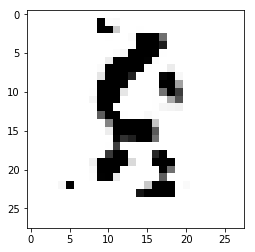

Estimativa: [[ 9.78686619]]
Iteração: 48600 at 2017-10-11 09:23:31.816135


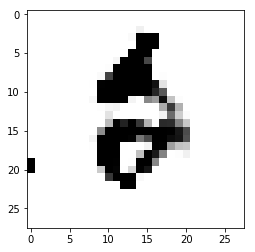

Estimativa: [[ 4.42476225]]
Iteração: 48700 at 2017-10-11 09:23:35.500472


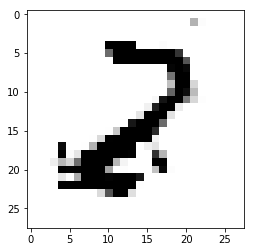

Estimativa: [[-1.01351237]]
Iteração: 48800 at 2017-10-11 09:23:39.135487


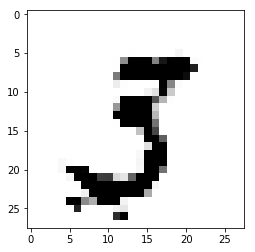

Estimativa: [[ 7.96636295]]
Iteração: 48900 at 2017-10-11 09:23:42.760739


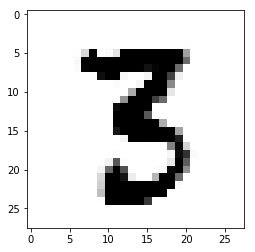

Estimativa: [[ 6.75307512]]
Iteração: 49000 at 2017-10-11 09:23:46.369813


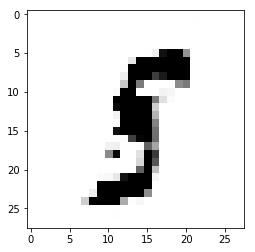

Estimativa: [[ 5.51355267]]
Iteração: 49100 at 2017-10-11 09:23:50.008850


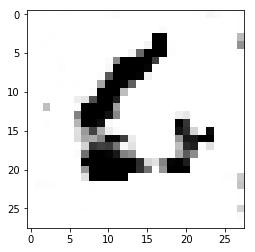

Estimativa: [[ 31.03411293]]
Iteração: 49200 at 2017-10-11 09:23:53.767228


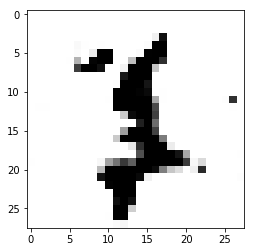

Estimativa: [[ 30.43763161]]
Iteração: 49300 at 2017-10-11 09:23:57.536816


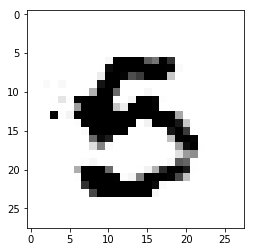

Estimativa: [[ 22.63626671]]
Iteração: 49400 at 2017-10-11 09:24:01.222665


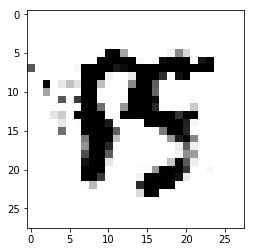

Estimativa: [[-30.63384628]]
Iteração: 49500 at 2017-10-11 09:24:04.871595


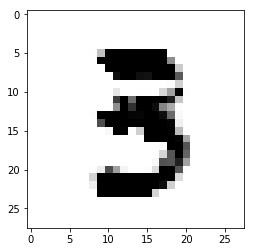

Estimativa: [[-3.02749705]]
Iteração: 49600 at 2017-10-11 09:24:08.509583


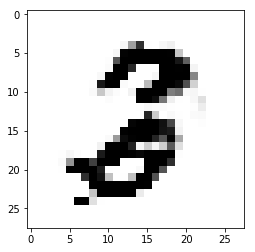

Estimativa: [[-2.18222904]]
Iteração: 49700 at 2017-10-11 09:24:12.180306


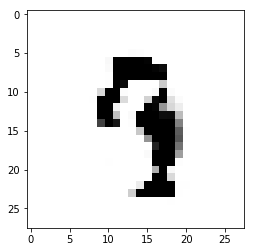

Estimativa: [[ 23.55351257]]
Iteração: 49800 at 2017-10-11 09:24:15.892395


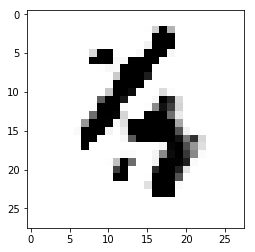

Estimativa: [[ 16.03876114]]
Iteração: 49900 at 2017-10-11 09:24:20.188729


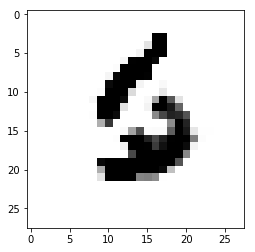

Estimativa: [[-0.77376449]]
Iteração: 50000 at 2017-10-11 09:24:23.853446


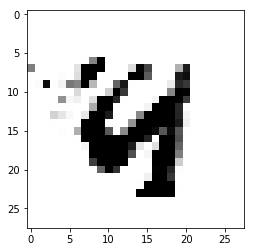

Estimativa: [[ 7.1108079]]
Iteração: 50100 at 2017-10-11 09:24:27.540821


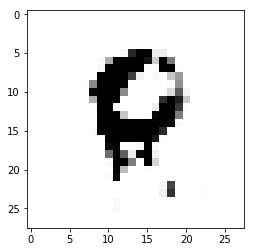

Estimativa: [[-11.69062901]]
Iteração: 50200 at 2017-10-11 09:24:31.327064


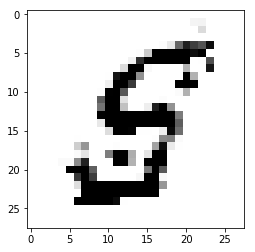

Estimativa: [[ 8.18913937]]
Iteração: 50300 at 2017-10-11 09:24:35.090196


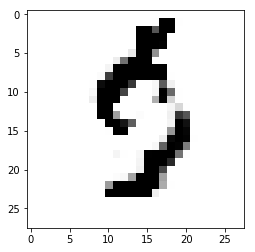

Estimativa: [[ 2.38869309]]
Iteração: 50400 at 2017-10-11 09:24:38.946015


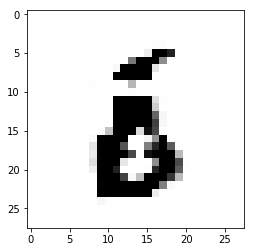

Estimativa: [[ 5.19692039]]
Iteração: 50500 at 2017-10-11 09:24:42.616249


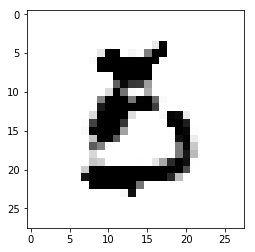

Estimativa: [[-3.76961017]]
Iteração: 50600 at 2017-10-11 09:24:46.308605


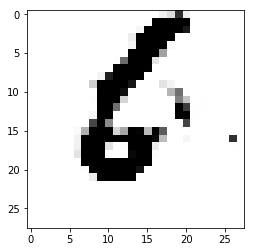

Estimativa: [[-1.1833936]]
Iteração: 50700 at 2017-10-11 09:24:49.971451


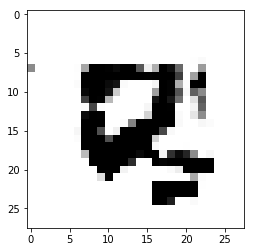

Estimativa: [[-10.10820293]]
Iteração: 50800 at 2017-10-11 09:24:53.687955


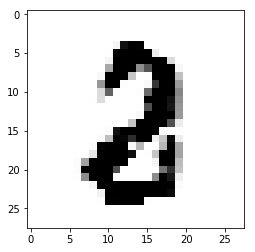

Estimativa: [[-21.25717926]]
Iteração: 50900 at 2017-10-11 09:24:57.355324


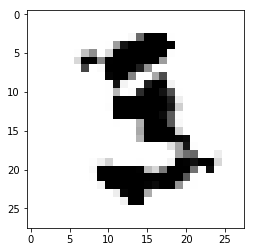

Estimativa: [[-10.20195961]]
Iteração: 51000 at 2017-10-11 09:25:01.109991


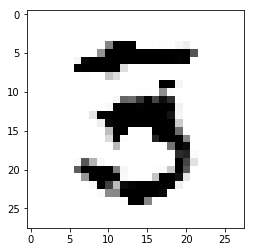

Estimativa: [[ 17.13146019]]
Iteração: 51100 at 2017-10-11 09:25:04.807223


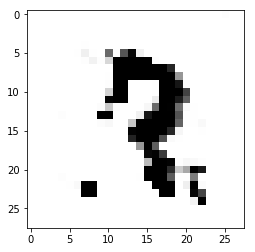

Estimativa: [[ 5.7323823]]
Iteração: 51200 at 2017-10-11 09:25:08.479219


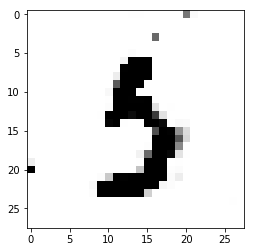

Estimativa: [[-30.44106102]]
Iteração: 51300 at 2017-10-11 09:25:12.178706


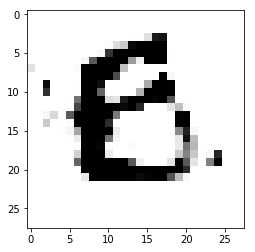

Estimativa: [[ 26.25471115]]
Iteração: 51400 at 2017-10-11 09:25:16.055566


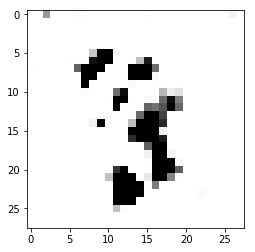

Estimativa: [[-26.54557991]]
Iteração: 51500 at 2017-10-11 09:25:19.793205


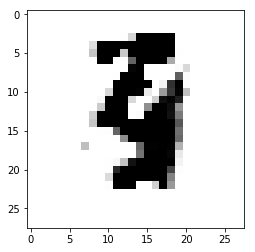

Estimativa: [[-4.63107252]]
Iteração: 51600 at 2017-10-11 09:25:23.501537


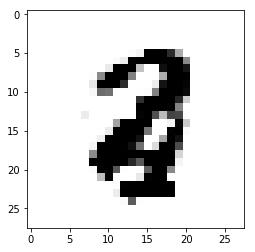

Estimativa: [[-3.35185671]]
Iteração: 51700 at 2017-10-11 09:25:27.361861


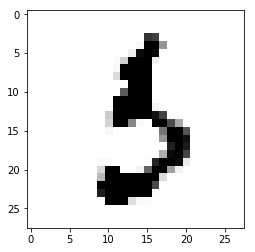

Estimativa: [[ 25.20004845]]
Iteração: 51800 at 2017-10-11 09:25:31.070640


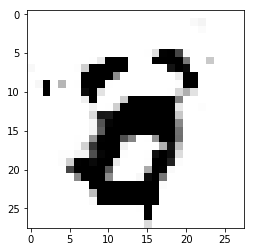

Estimativa: [[-3.29609489]]
Iteração: 51900 at 2017-10-11 09:25:34.853304


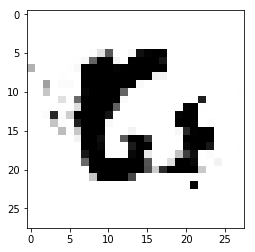

Estimativa: [[-7.38523197]]
Iteração: 52000 at 2017-10-11 09:25:38.579125


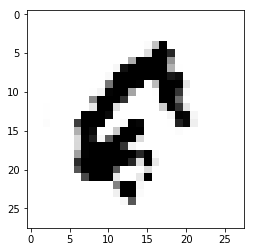

Estimativa: [[ 14.07388783]]
Iteração: 52100 at 2017-10-11 09:25:42.279123


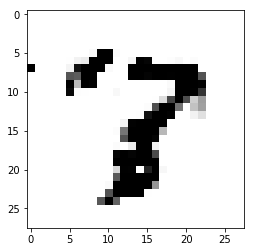

Estimativa: [[-6.3896842]]
Iteração: 52200 at 2017-10-11 09:25:46.139866


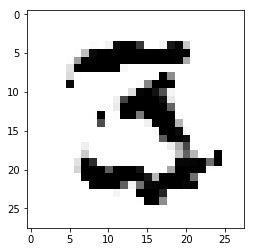

Estimativa: [[-22.26558113]]
Iteração: 52300 at 2017-10-11 09:25:49.993144


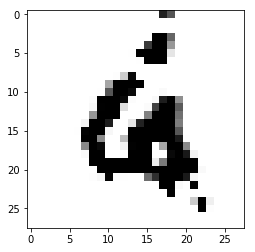

Estimativa: [[-12.51130486]]
Iteração: 52400 at 2017-10-11 09:25:53.704904


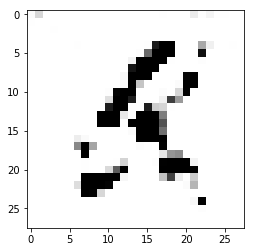

Estimativa: [[ 2.85059118]]
Iteração: 52500 at 2017-10-11 09:25:57.602888


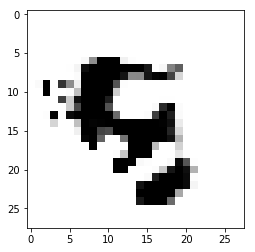

Estimativa: [[-14.37418079]]
Iteração: 52600 at 2017-10-11 09:26:01.433933


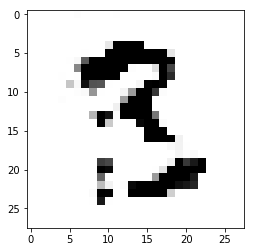

Estimativa: [[ 2.23043418]]
Iteração: 52700 at 2017-10-11 09:26:05.283211


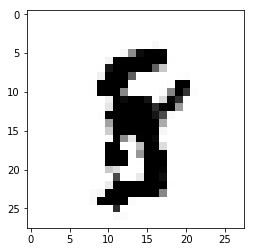

Estimativa: [[ 11.43887234]]
Iteração: 52800 at 2017-10-11 09:26:09.166271


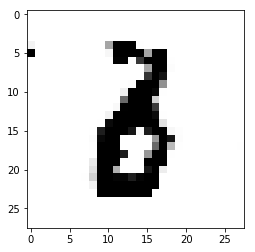

Estimativa: [[ 38.64501572]]
Iteração: 52900 at 2017-10-11 09:26:12.895539


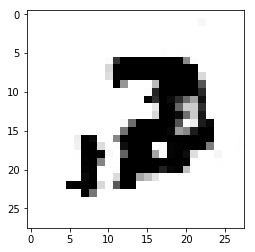

Estimativa: [[-4.11773968]]
Iteração: 53000 at 2017-10-11 09:26:16.702137


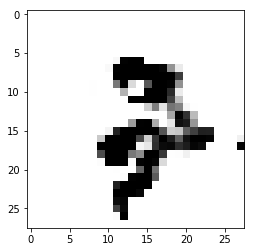

Estimativa: [[ 14.71703053]]
Iteração: 53100 at 2017-10-11 09:26:20.442201


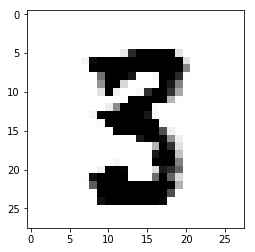

Estimativa: [[-4.74007607]]
Iteração: 53200 at 2017-10-11 09:26:24.186843


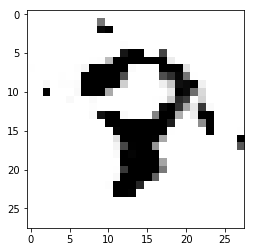

Estimativa: [[ 21.34361267]]
Iteração: 53300 at 2017-10-11 09:26:28.059809


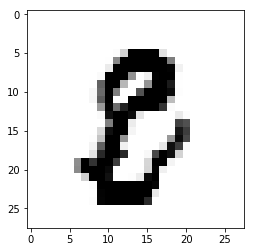

Estimativa: [[ 29.0881424]]
Iteração: 53400 at 2017-10-11 09:26:31.838744


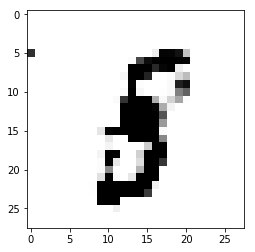

Estimativa: [[-5.39646864]]
Iteração: 53500 at 2017-10-11 09:26:35.681766


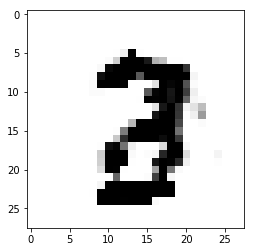

Estimativa: [[-9.53366947]]
Iteração: 53600 at 2017-10-11 09:26:39.500814


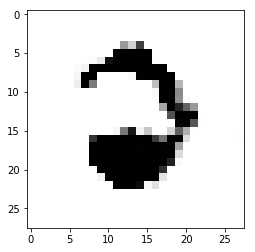

Estimativa: [[ 13.8429451]]
Iteração: 53700 at 2017-10-11 09:26:43.283454


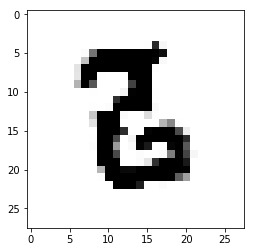

Estimativa: [[ 17.76947403]]
Iteração: 53800 at 2017-10-11 09:26:47.199291


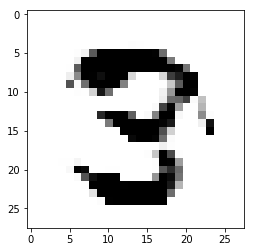

Estimativa: [[ 41.12507629]]
Iteração: 53900 at 2017-10-11 09:26:50.963644


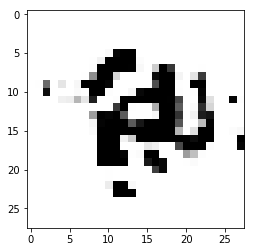

Estimativa: [[-16.15155983]]
Iteração: 54000 at 2017-10-11 09:26:54.744817


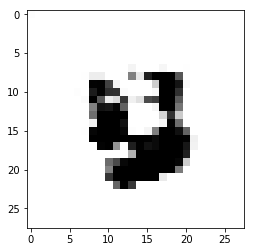

Estimativa: [[-15.80088139]]
Iteração: 54100 at 2017-10-11 09:26:58.509923


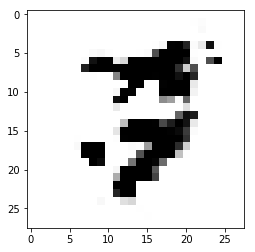

Estimativa: [[-0.19229682]]
Iteração: 54200 at 2017-10-11 09:27:02.450036


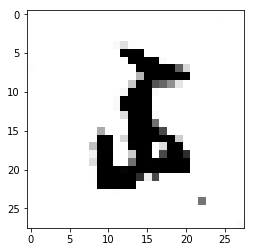

Estimativa: [[ 10.49715614]]
Iteração: 54300 at 2017-10-11 09:27:06.261167


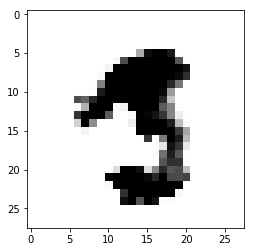

Estimativa: [[-16.43301392]]
Iteração: 54400 at 2017-10-11 09:27:10.031177


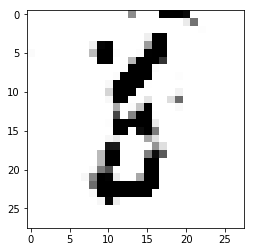

Estimativa: [[-8.96085644]]
Iteração: 54500 at 2017-10-11 09:27:13.816828


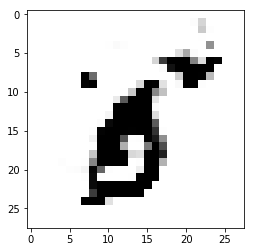

Estimativa: [[ 3.54414558]]
Iteração: 54600 at 2017-10-11 09:27:17.608780


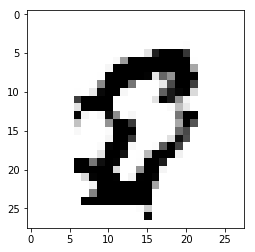

Estimativa: [[-0.50709325]]
Iteração: 54700 at 2017-10-11 09:27:21.440602


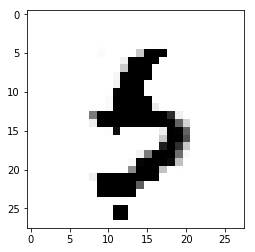

Estimativa: [[ 16.32782936]]
Iteração: 54800 at 2017-10-11 09:27:25.247841


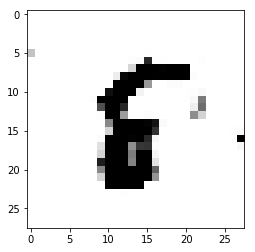

Estimativa: [[ 3.67485619]]
Iteração: 54900 at 2017-10-11 09:27:29.040523


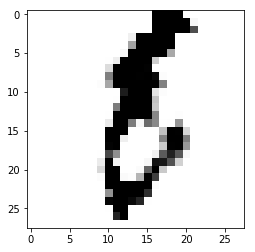

Estimativa: [[-4.64337635]]
Iteração: 55000 at 2017-10-11 09:27:32.887697


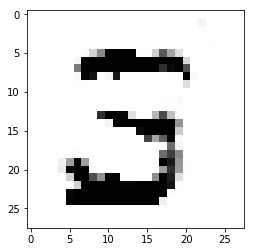

Estimativa: [[ 9.07939243]]
Iteração: 55100 at 2017-10-11 09:27:36.697854


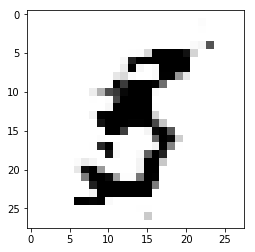

Estimativa: [[-18.91529846]]
Iteração: 55200 at 2017-10-11 09:27:40.487366


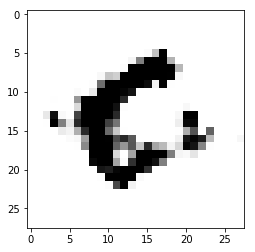

Estimativa: [[ 13.20969868]]
Iteração: 55300 at 2017-10-11 09:27:44.364606


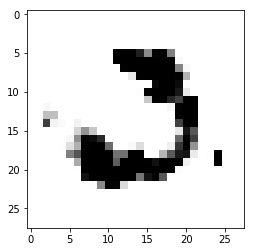

Estimativa: [[ 30.43489647]]
Iteração: 55400 at 2017-10-11 09:27:48.466486


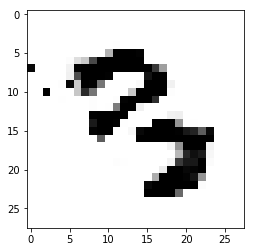

Estimativa: [[ 14.94606781]]
Iteração: 55500 at 2017-10-11 09:27:52.300624


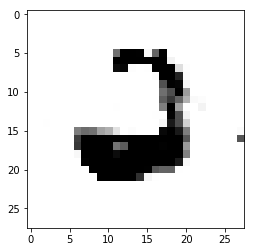

Estimativa: [[-26.69706917]]
Iteração: 55600 at 2017-10-11 09:27:56.214048


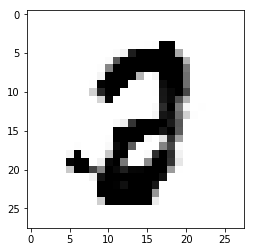

Estimativa: [[-5.96803761]]
Iteração: 55700 at 2017-10-11 09:28:00.058057


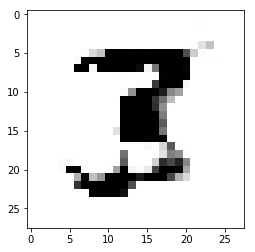

Estimativa: [[ 3.06674933]]
Iteração: 55800 at 2017-10-11 09:28:03.898594


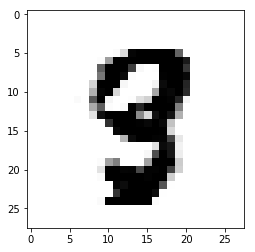

Estimativa: [[ 2.20062041]]
Iteração: 55900 at 2017-10-11 09:28:07.701510


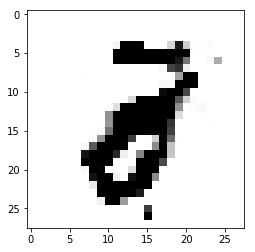

Estimativa: [[ 8.0479393]]
Iteração: 56000 at 2017-10-11 09:28:11.551306


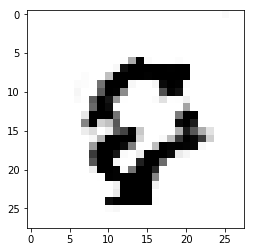

Estimativa: [[ 19.4074707]]
Iteração: 56100 at 2017-10-11 09:28:15.359233


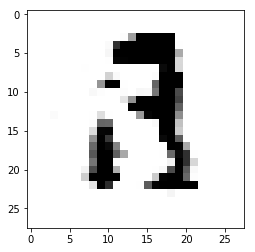

Estimativa: [[ 13.88118362]]
Iteração: 56200 at 2017-10-11 09:28:19.233877


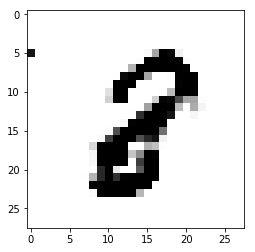

Estimativa: [[-0.40827233]]
Iteração: 56300 at 2017-10-11 09:28:23.092257


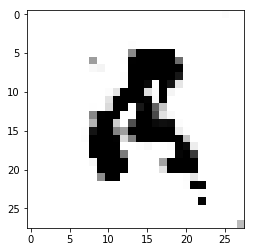

Estimativa: [[ 3.25549865]]
Iteração: 56400 at 2017-10-11 09:28:26.950315


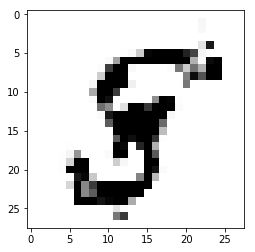

Estimativa: [[-24.23574638]]
Iteração: 56500 at 2017-10-11 09:28:30.839075


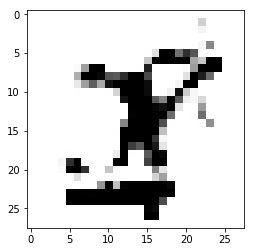

Estimativa: [[ 12.84808922]]
Iteração: 56600 at 2017-10-11 09:28:35.373794


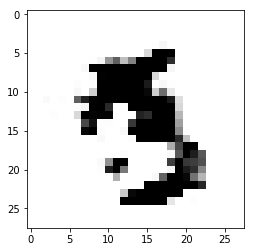

Estimativa: [[ 31.00413322]]
Iteração: 56700 at 2017-10-11 09:28:39.260244


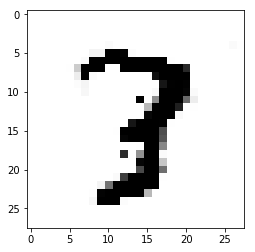

Estimativa: [[-12.93930626]]
Iteração: 56800 at 2017-10-11 09:28:43.222322


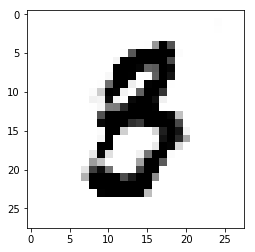

Estimativa: [[-12.38224697]]
Iteração: 56900 at 2017-10-11 09:28:47.172541


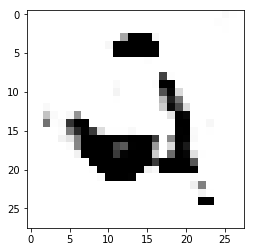

Estimativa: [[ 26.94794846]]
Iteração: 57000 at 2017-10-11 09:28:51.197568


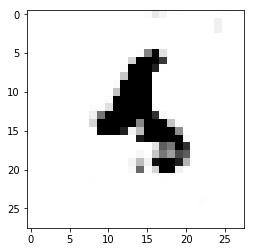

Estimativa: [[-10.70827484]]
Iteração: 57100 at 2017-10-11 09:28:55.057883


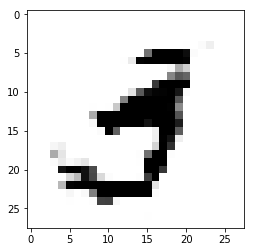

Estimativa: [[ 17.83945084]]
Iteração: 57200 at 2017-10-11 09:28:59.070104


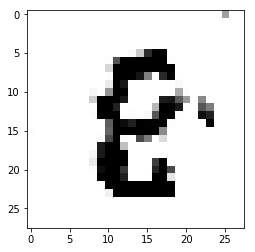

Estimativa: [[ 22.62184143]]
Iteração: 57300 at 2017-10-11 09:29:02.922339


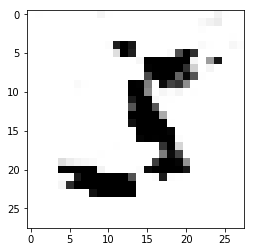

Estimativa: [[-40.98168564]]
Iteração: 57400 at 2017-10-11 09:29:06.869638


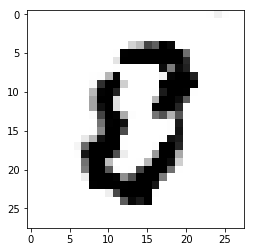

Estimativa: [[-3.36141586]]
Iteração: 57500 at 2017-10-11 09:29:10.752250


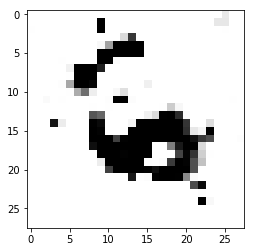

Estimativa: [[ 42.46550369]]
Iteração: 57600 at 2017-10-11 09:29:14.655441


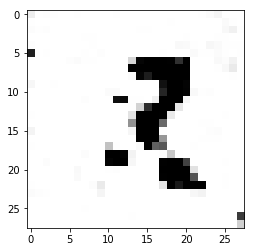

Estimativa: [[-31.80853844]]
Iteração: 57700 at 2017-10-11 09:29:18.521253


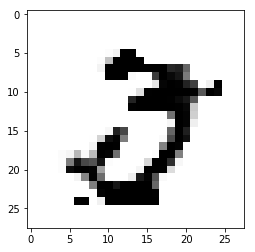

Estimativa: [[-7.7663393]]
Iteração: 57800 at 2017-10-11 09:29:22.393057


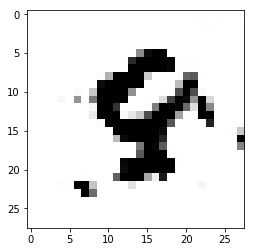

Estimativa: [[ 3.21615028]]
Iteração: 57900 at 2017-10-11 09:29:26.339229


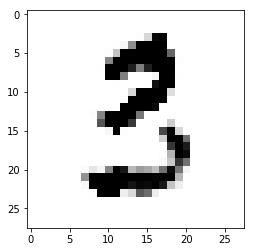

Estimativa: [[-6.32275343]]
Iteração: 58000 at 2017-10-11 09:29:30.368285


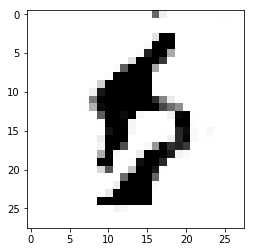

Estimativa: [[-3.47817039]]
Iteração: 58100 at 2017-10-11 09:29:34.307912


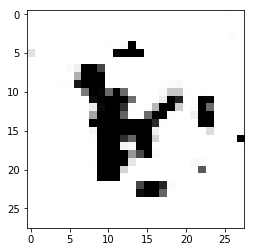

Estimativa: [[-1.26767349]]
Iteração: 58200 at 2017-10-11 09:29:38.182019


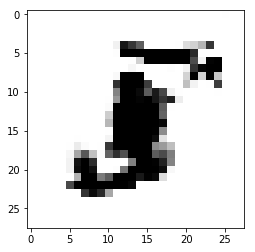

Estimativa: [[-0.73417747]]
Iteração: 58300 at 2017-10-11 09:29:42.115310


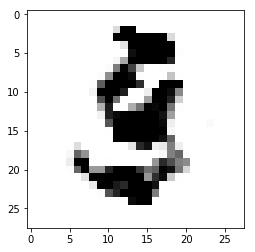

Estimativa: [[ 6.59198046]]
Iteração: 58400 at 2017-10-11 09:29:46.014835


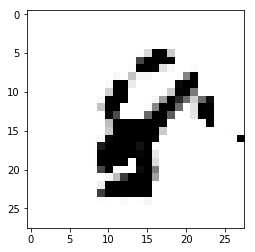

Estimativa: [[-10.24999142]]
Iteração: 58500 at 2017-10-11 09:29:49.932049


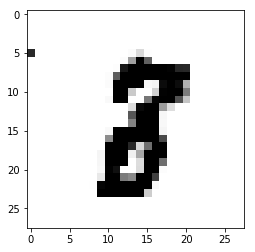

Estimativa: [[ 10.88100433]]
Iteração: 58600 at 2017-10-11 09:29:53.821816


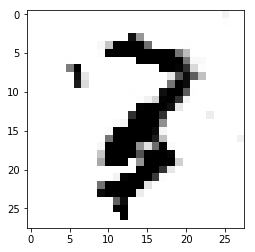

Estimativa: [[ 22.16186905]]
Iteração: 58700 at 2017-10-11 09:29:57.764575


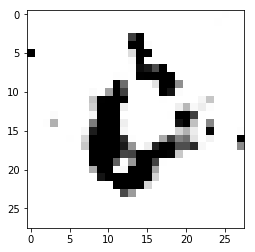

Estimativa: [[-19.73914528]]
Iteração: 58800 at 2017-10-11 09:30:01.693465


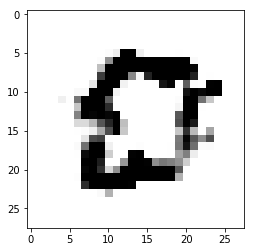

Estimativa: [[ 27.12772179]]
Iteração: 58900 at 2017-10-11 09:30:05.681958


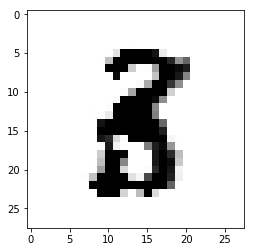

Estimativa: [[-23.16436005]]
Iteração: 59000 at 2017-10-11 09:30:09.615380


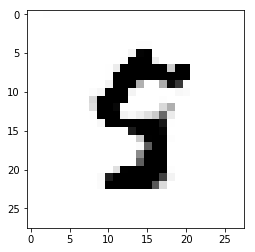

Estimativa: [[-28.76972389]]
Iteração: 59100 at 2017-10-11 09:30:13.722861


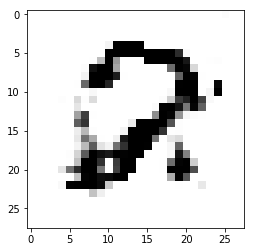

Estimativa: [[ 1.23488796]]
Iteração: 59200 at 2017-10-11 09:30:17.638175


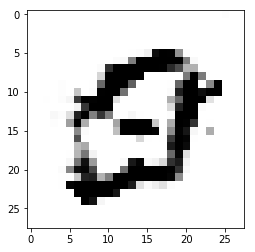

Estimativa: [[ 33.94131851]]
Iteração: 59300 at 2017-10-11 09:30:21.607876


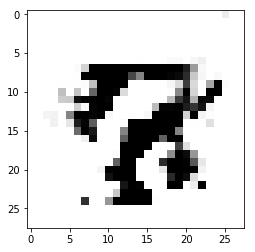

Estimativa: [[-35.94250488]]
Iteração: 59400 at 2017-10-11 09:30:25.633160


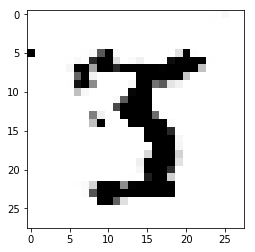

Estimativa: [[ 1.04414868]]
Iteração: 59500 at 2017-10-11 09:30:29.551934


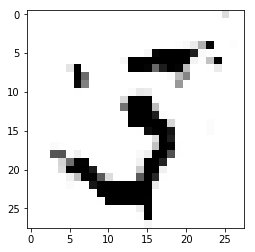

Estimativa: [[-5.25936556]]
Iteração: 59600 at 2017-10-11 09:30:33.579886


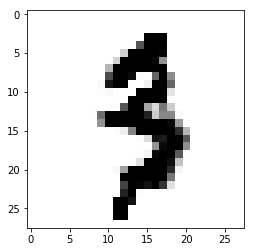

Estimativa: [[ 17.12379837]]
Iteração: 59700 at 2017-10-11 09:30:37.499150


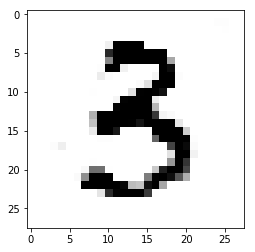

Estimativa: [[ 11.70473766]]
Iteração: 59800 at 2017-10-11 09:30:41.468417


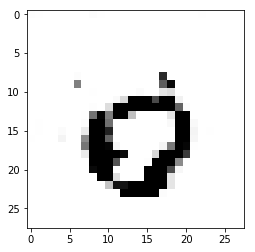

Estimativa: [[ 6.90283823]]
Iteração: 59900 at 2017-10-11 09:30:45.430136


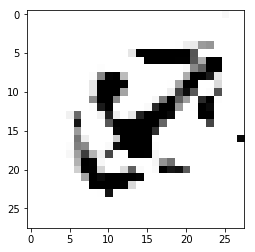

Estimativa: [[-14.12977028]]
Iteração: 60000 at 2017-10-11 09:30:49.647178


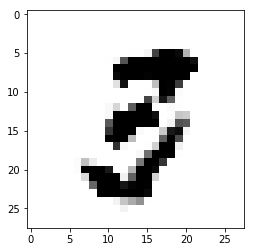

Estimativa: [[-14.47259617]]
Iteração: 60100 at 2017-10-11 09:30:53.709520


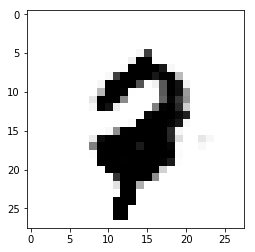

Estimativa: [[ 3.55439591]]
Iteração: 60200 at 2017-10-11 09:30:57.714529


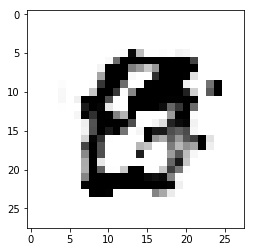

Estimativa: [[-19.44828415]]
Iteração: 60300 at 2017-10-11 09:31:01.656612


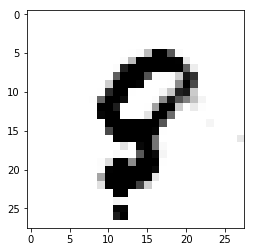

Estimativa: [[-3.48247623]]
Iteração: 60400 at 2017-10-11 09:31:05.624251


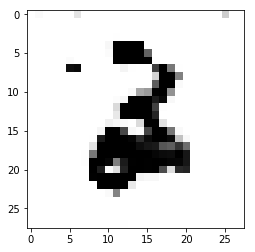

Estimativa: [[-9.47005081]]
Iteração: 60500 at 2017-10-11 09:31:09.587079


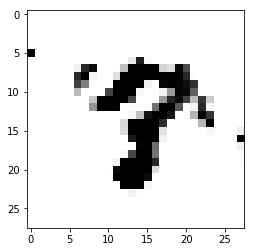

Estimativa: [[ 4.01177025]]
Iteração: 60600 at 2017-10-11 09:31:13.568110


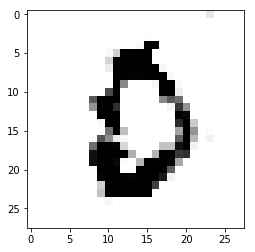

Estimativa: [[ 8.18321419]]
Iteração: 60700 at 2017-10-11 09:31:17.550951


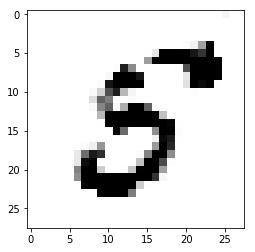

Estimativa: [[ 6.95717478]]
Iteração: 60800 at 2017-10-11 09:31:21.592874


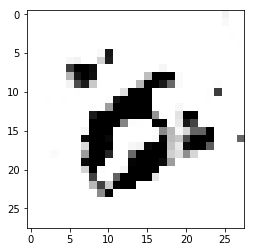

Estimativa: [[-26.88177681]]
Iteração: 60900 at 2017-10-11 09:31:25.702977


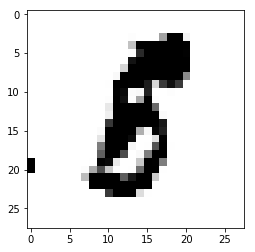

Estimativa: [[ 38.19024277]]
Iteração: 61000 at 2017-10-11 09:31:29.707191


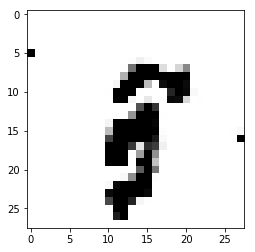

Estimativa: [[ 6.01779461]]
Iteração: 61100 at 2017-10-11 09:31:33.680442


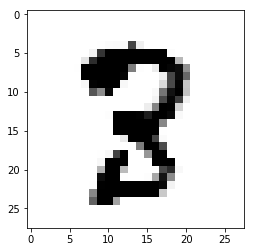

Estimativa: [[ 24.41421318]]
Iteração: 61200 at 2017-10-11 09:31:37.729171


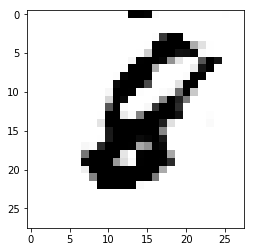

Estimativa: [[ 26.94133568]]
Iteração: 61300 at 2017-10-11 09:31:41.784800


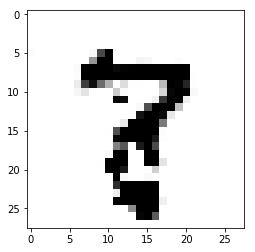

Estimativa: [[ 13.09366608]]
Iteração: 61400 at 2017-10-11 09:31:45.762846


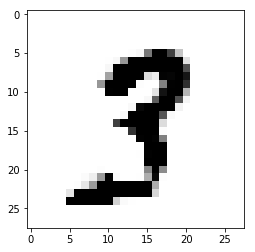

Estimativa: [[ 11.45936203]]
Iteração: 61500 at 2017-10-11 09:31:49.838861


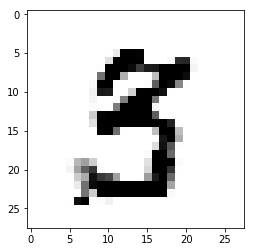

Estimativa: [[ 4.15356827]]
Iteração: 61600 at 2017-10-11 09:31:53.931279


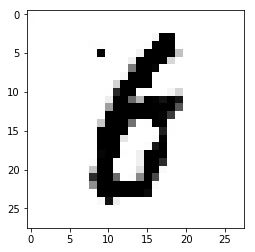

Estimativa: [[-10.96026993]]
Iteração: 61700 at 2017-10-11 09:31:57.938567


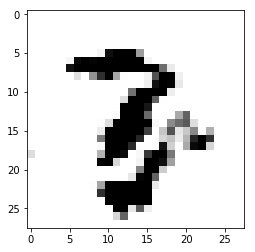

Estimativa: [[ 0.71764392]]
Iteração: 61800 at 2017-10-11 09:32:01.946537


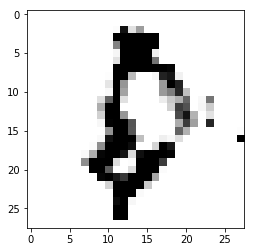

Estimativa: [[ 3.88210726]]
Iteração: 61900 at 2017-10-11 09:32:05.951641


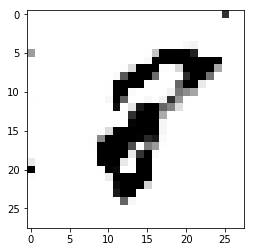

Estimativa: [[ 10.55513573]]
Iteração: 62000 at 2017-10-11 09:32:10.022625


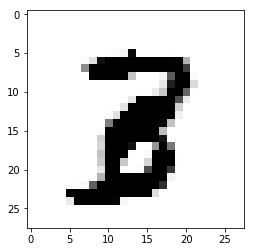

Estimativa: [[ 19.4803791]]
Iteração: 62100 at 2017-10-11 09:32:14.053734


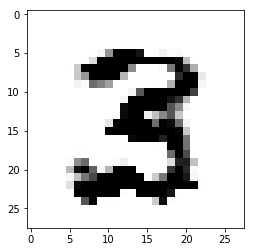

Estimativa: [[-40.50220871]]
Iteração: 62200 at 2017-10-11 09:32:18.167601


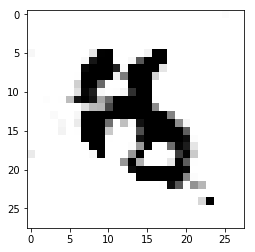

Estimativa: [[ 37.03366089]]
Iteração: 62300 at 2017-10-11 09:32:22.181457


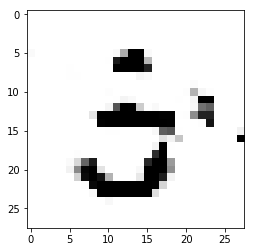

Estimativa: [[ 41.29944992]]
Iteração: 62400 at 2017-10-11 09:32:26.268744


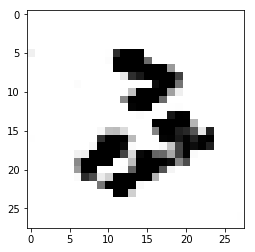

Estimativa: [[-6.81814384]]
Iteração: 62500 at 2017-10-11 09:32:30.288336


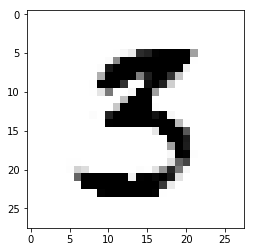

Estimativa: [[-15.88157749]]
Iteração: 62600 at 2017-10-11 09:32:34.312505


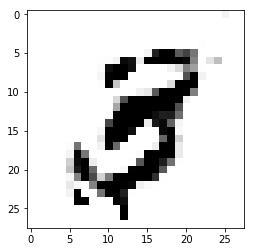

Estimativa: [[-26.84943581]]
Iteração: 62700 at 2017-10-11 09:32:38.421841


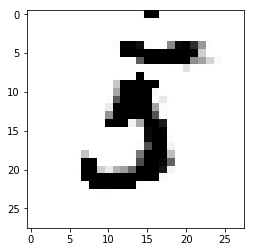

Estimativa: [[-0.78869516]]
Iteração: 62800 at 2017-10-11 09:32:42.481909


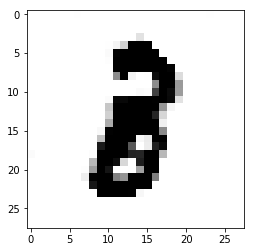

Estimativa: [[ 18.89048195]]
Iteração: 62900 at 2017-10-11 09:32:46.631645


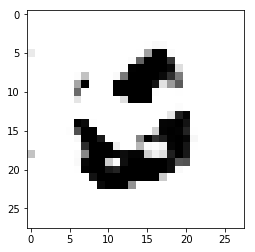

Estimativa: [[-19.85603905]]
Iteração: 63000 at 2017-10-11 09:32:50.680816


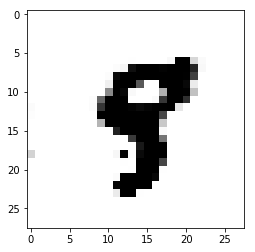

Estimativa: [[-5.50697899]]
Iteração: 63100 at 2017-10-11 09:32:54.725705


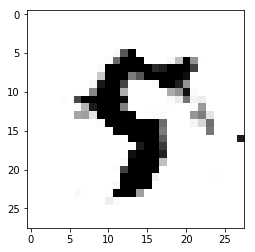

Estimativa: [[ 5.19577837]]
Iteração: 63200 at 2017-10-11 09:32:58.821810


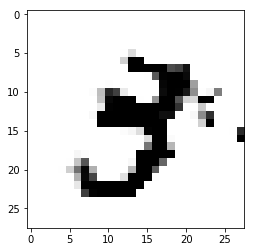

Estimativa: [[ 8.79321003]]
Iteração: 63300 at 2017-10-11 09:33:02.964129


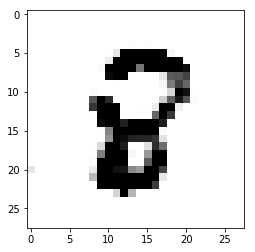

Estimativa: [[ 1.33706725]]
Iteração: 63400 at 2017-10-11 09:33:06.987422


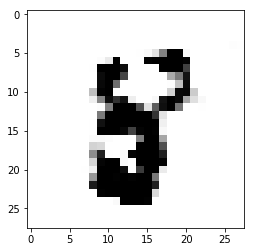

Estimativa: [[-30.44132042]]
Iteração: 63500 at 2017-10-11 09:33:11.102631


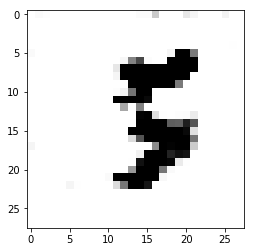

Estimativa: [[-34.11052704]]
Iteração: 63600 at 2017-10-11 09:33:15.169996


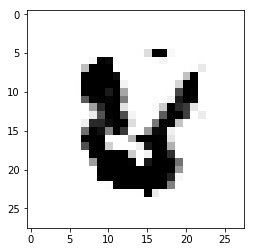

Estimativa: [[ 22.50882721]]
Iteração: 63700 at 2017-10-11 09:33:19.263008


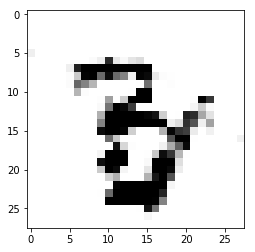

Estimativa: [[ 20.43626404]]
Iteração: 63800 at 2017-10-11 09:33:23.392645


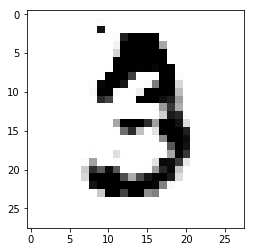

Estimativa: [[-18.70122528]]
Iteração: 63900 at 2017-10-11 09:33:27.454230


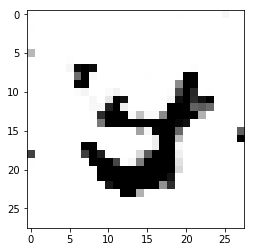

Estimativa: [[ 48.99869919]]
Iteração: 64000 at 2017-10-11 09:33:31.492029


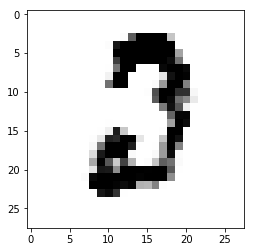

Estimativa: [[ 11.92981911]]
Iteração: 64100 at 2017-10-11 09:33:36.456675


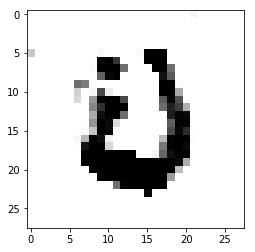

Estimativa: [[ 15.82017517]]
Iteração: 64200 at 2017-10-11 09:33:40.702837


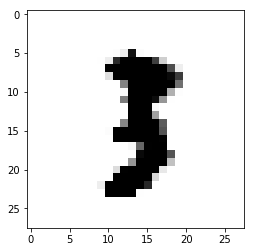

Estimativa: [[ 5.09505606]]
Iteração: 64300 at 2017-10-11 09:33:44.808541


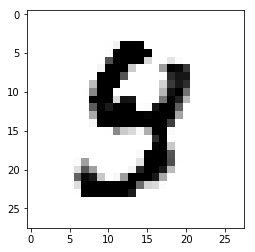

Estimativa: [[-4.93949318]]
Iteração: 64400 at 2017-10-11 09:33:48.972228


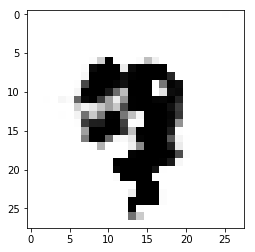

Estimativa: [[-3.32421017]]
Iteração: 64500 at 2017-10-11 09:33:53.057290


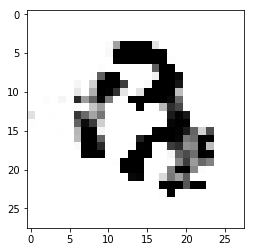

Estimativa: [[ 25.93888092]]
Iteração: 64600 at 2017-10-11 09:33:57.188907


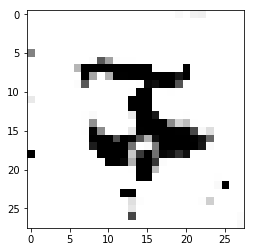

Estimativa: [[-19.46559906]]
Iteração: 64700 at 2017-10-11 09:34:01.374361


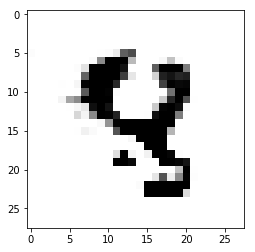

Estimativa: [[ 6.47922802]]
Iteração: 64800 at 2017-10-11 09:34:05.473193


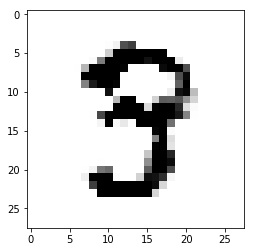

Estimativa: [[-1.39364398]]
Iteração: 64900 at 2017-10-11 09:34:09.596100


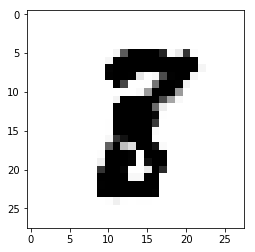

Estimativa: [[-7.8818655]]
Iteração: 65000 at 2017-10-11 09:34:13.704604


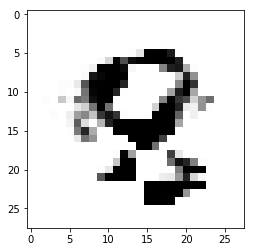

Estimativa: [[ 20.30476761]]
Iteração: 65100 at 2017-10-11 09:34:17.831877


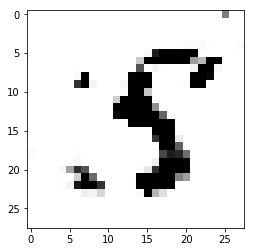

Estimativa: [[-19.90509796]]
Iteração: 65200 at 2017-10-11 09:34:21.913872


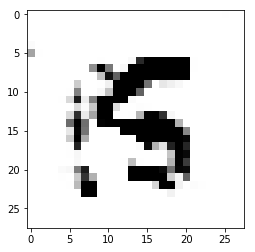

Estimativa: [[ 24.35154915]]
Iteração: 65300 at 2017-10-11 09:34:25.985495


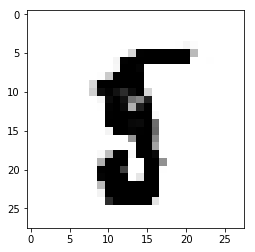

Estimativa: [[ 40.50204849]]
Iteração: 65400 at 2017-10-11 09:34:30.115301


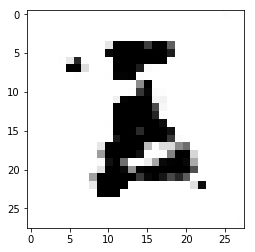

Estimativa: [[ 7.71048641]]
Iteração: 65500 at 2017-10-11 09:34:34.263658


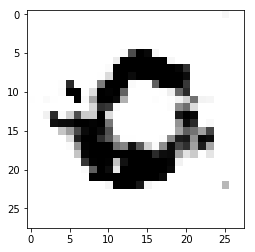

Estimativa: [[-1.60051179]]
Iteração: 65600 at 2017-10-11 09:34:38.376703


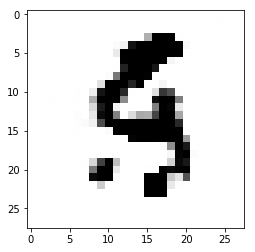

Estimativa: [[ 8.26427078]]
Iteração: 65700 at 2017-10-11 09:34:42.635204


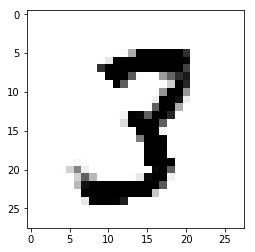

Estimativa: [[ 20.92912865]]
Iteração: 65800 at 2017-10-11 09:34:46.765972


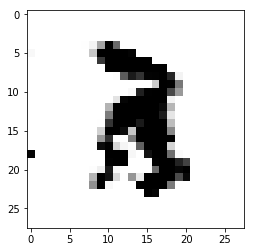

Estimativa: [[-13.08289146]]
Iteração: 65900 at 2017-10-11 09:34:50.884010


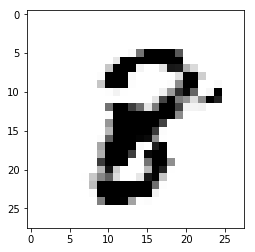

Estimativa: [[ 35.06407166]]
Iteração: 66000 at 2017-10-11 09:34:54.986108


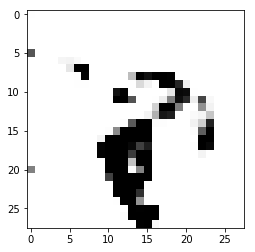

Estimativa: [[ 50.39171982]]
Iteração: 66100 at 2017-10-11 09:34:59.125654


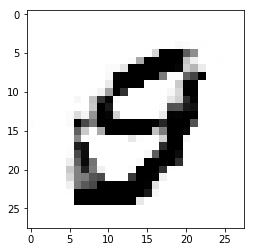

Estimativa: [[ 23.94835091]]
Iteração: 66200 at 2017-10-11 09:35:03.207146


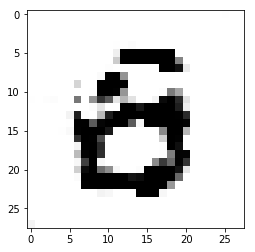

Estimativa: [[-13.86016846]]
Iteração: 66300 at 2017-10-11 09:35:07.340145


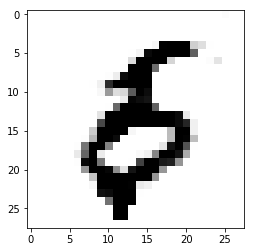

Estimativa: [[ 13.12025356]]
Iteração: 66400 at 2017-10-11 09:35:11.501433


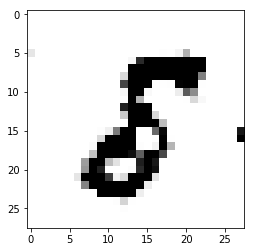

Estimativa: [[ 23.19985199]]
Iteração: 66500 at 2017-10-11 09:35:15.635193


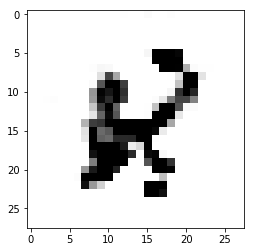

Estimativa: [[ 8.9503355]]
Iteração: 66600 at 2017-10-11 09:35:19.934450


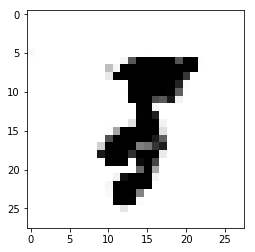

Estimativa: [[-15.06964111]]
Iteração: 66700 at 2017-10-11 09:35:24.094781


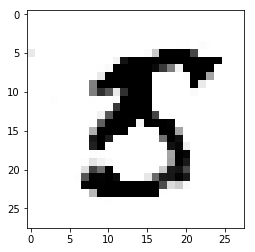

Estimativa: [[-8.1726284]]
Iteração: 66800 at 2017-10-11 09:35:28.283433


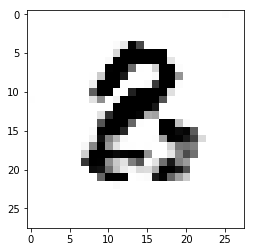

Estimativa: [[ 23.10356903]]
Iteração: 66900 at 2017-10-11 09:35:32.507554


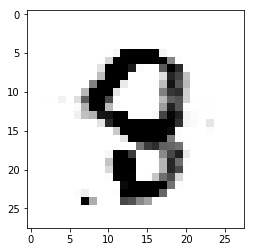

Estimativa: [[-13.54071426]]
Iteração: 67000 at 2017-10-11 09:35:36.663780


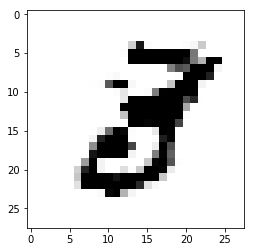

Estimativa: [[ 35.99991608]]
Iteração: 67100 at 2017-10-11 09:35:40.824625


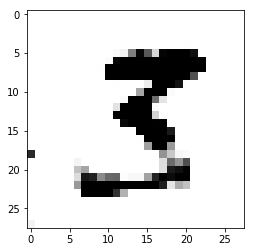

Estimativa: [[-1.69440603]]
Iteração: 67200 at 2017-10-11 09:35:44.944350


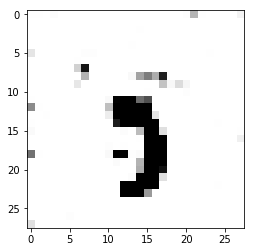

Estimativa: [[-12.66211987]]
Iteração: 67300 at 2017-10-11 09:35:49.082572


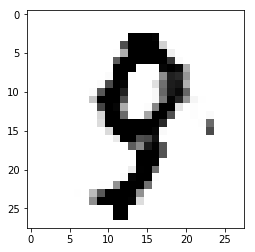

Estimativa: [[ 21.82082558]]
Iteração: 67400 at 2017-10-11 09:35:53.313875


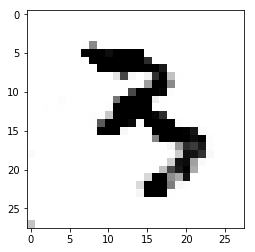

Estimativa: [[ 3.63905716]]
Iteração: 67500 at 2017-10-11 09:35:57.523016


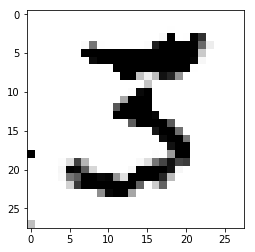

Estimativa: [[-26.01763344]]
Iteração: 67600 at 2017-10-11 09:36:01.655288


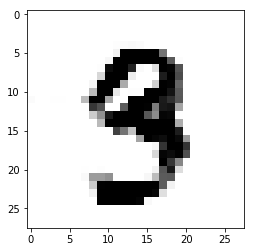

Estimativa: [[-0.75209165]]
Iteração: 67700 at 2017-10-11 09:36:05.829578


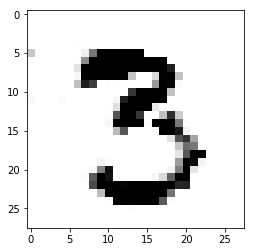

Estimativa: [[ 38.95714951]]
Iteração: 67800 at 2017-10-11 09:36:10.097664


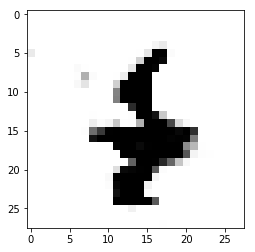

Estimativa: [[ 21.02080154]]
Iteração: 67900 at 2017-10-11 09:36:14.342767


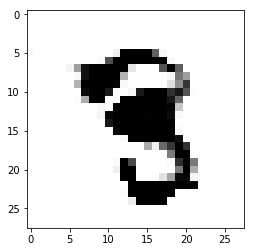

Estimativa: [[ 10.48704624]]
Iteração: 68000 at 2017-10-11 09:36:18.497356


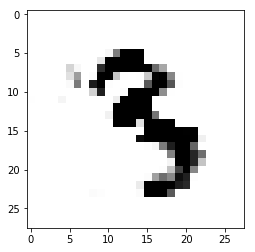

Estimativa: [[ 6.74486446]]
Iteração: 68100 at 2017-10-11 09:36:22.679943


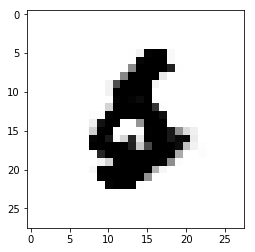

Estimativa: [[-8.56036949]]
Iteração: 68200 at 2017-10-11 09:36:26.919422


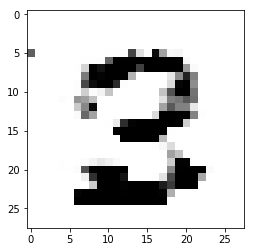

Estimativa: [[-7.31818199]]
Iteração: 68300 at 2017-10-11 09:36:31.119417


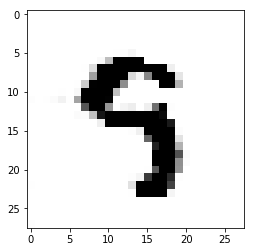

Estimativa: [[ 9.55624104]]
Iteração: 68400 at 2017-10-11 09:36:35.439686


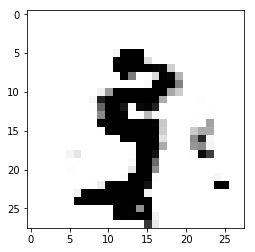

Estimativa: [[-6.75984144]]
Iteração: 68500 at 2017-10-11 09:36:39.757051


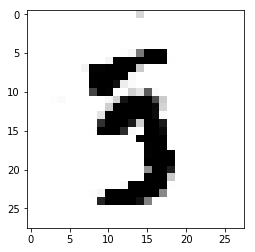

Estimativa: [[ 18.38100433]]
Iteração: 68600 at 2017-10-11 09:36:44.035036


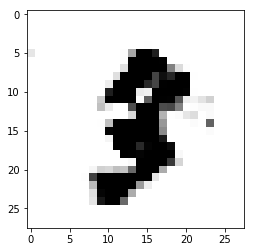

Estimativa: [[-4.3840909]]
Iteração: 68700 at 2017-10-11 09:36:48.193940


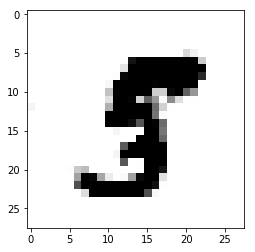

Estimativa: [[ 13.09281063]]
Iteração: 68800 at 2017-10-11 09:36:52.347623


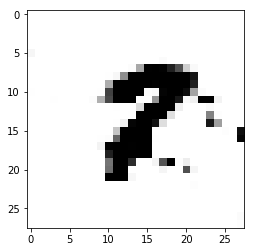

Estimativa: [[ 24.57248688]]
Iteração: 68900 at 2017-10-11 09:36:56.504654


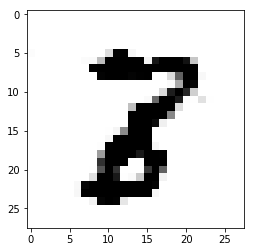

Estimativa: [[ 17.33042145]]
Iteração: 69000 at 2017-10-11 09:37:00.818622


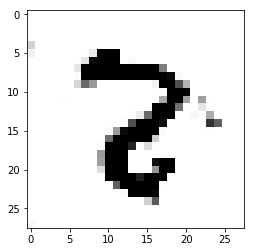

Estimativa: [[-8.17567539]]
Iteração: 69100 at 2017-10-11 09:37:04.960674


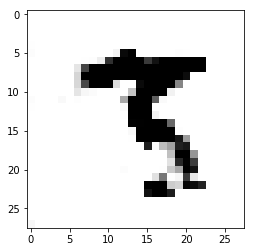

Estimativa: [[ 56.61911011]]
Iteração: 69200 at 2017-10-11 09:37:09.135178


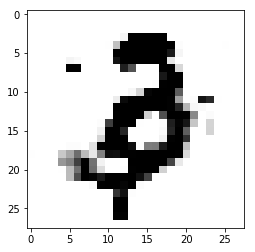

Estimativa: [[ 35.89921951]]
Iteração: 69300 at 2017-10-11 09:37:13.357494


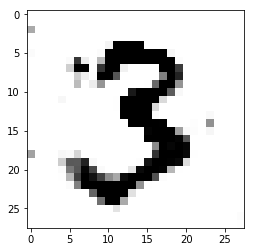

Estimativa: [[-11.159935]]
Iteração: 69400 at 2017-10-11 09:37:17.656670


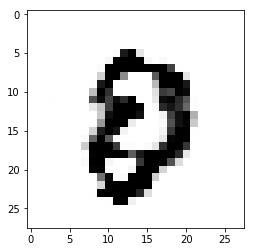

Estimativa: [[ 8.4790411]]
Iteração: 69500 at 2017-10-11 09:37:21.860028


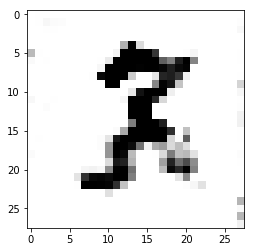

Estimativa: [[ 53.76955414]]
Iteração: 69600 at 2017-10-11 09:37:26.140134


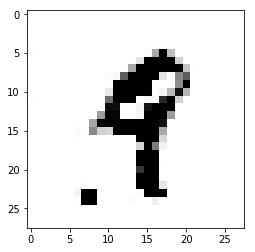

Estimativa: [[ 38.68417358]]
Iteração: 69700 at 2017-10-11 09:37:30.301600


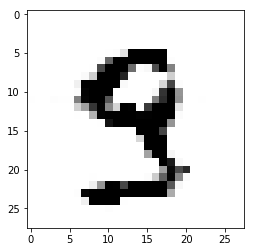

Estimativa: [[-26.78359604]]
Iteração: 69800 at 2017-10-11 09:37:34.532539


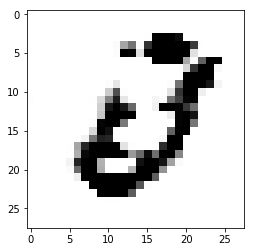

Estimativa: [[-3.3964448]]
Iteração: 69900 at 2017-10-11 09:37:38.722007


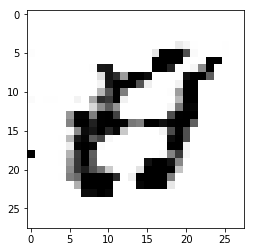

Estimativa: [[ 7.70775509]]
Iteração: 70000 at 2017-10-11 09:37:42.913365


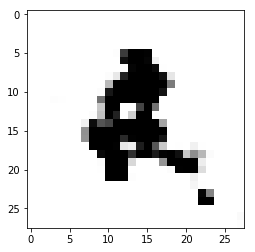

Estimativa: [[ 47.16743851]]
Iteração: 70100 at 2017-10-11 09:37:47.184615


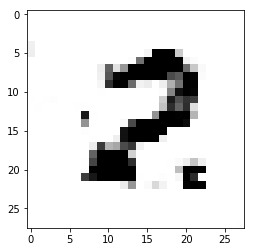

Estimativa: [[ 23.22819519]]
Iteração: 70200 at 2017-10-11 09:37:51.354653


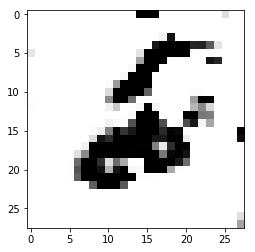

Estimativa: [[-5.18652868]]
Iteração: 70300 at 2017-10-11 09:37:55.553093


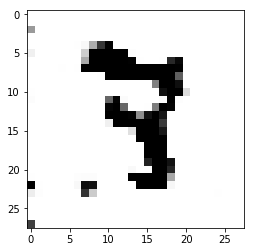

Estimativa: [[ 22.46797943]]
Iteração: 70400 at 2017-10-11 09:37:59.781723


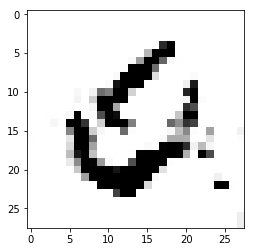

Estimativa: [[ 16.03014183]]
Iteração: 70500 at 2017-10-11 09:38:04.102117


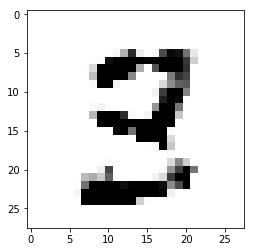

Estimativa: [[ 11.11544991]]
Iteração: 70600 at 2017-10-11 09:38:08.352059


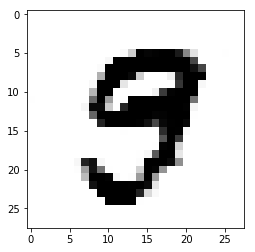

Estimativa: [[ 26.37101364]]
Iteração: 70700 at 2017-10-11 09:38:12.568475


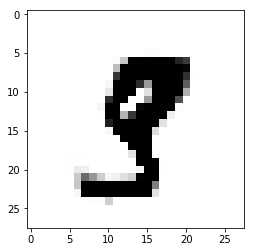

Estimativa: [[ 34.53747559]]
Iteração: 70800 at 2017-10-11 09:38:16.778566


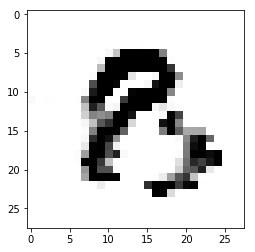

Estimativa: [[ 18.06581688]]
Iteração: 70900 at 2017-10-11 09:38:21.118028


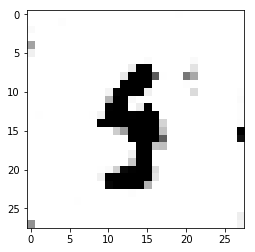

Estimativa: [[-14.00670719]]
Iteração: 71000 at 2017-10-11 09:38:25.477953


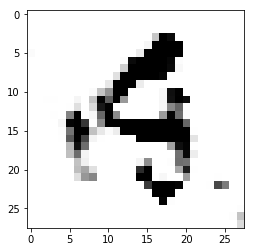

Estimativa: [[-11.98188496]]
Iteração: 71100 at 2017-10-11 09:38:29.663804


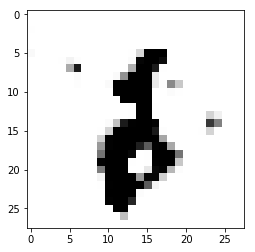

Estimativa: [[-4.76809311]]
Iteração: 71200 at 2017-10-11 09:38:33.913618


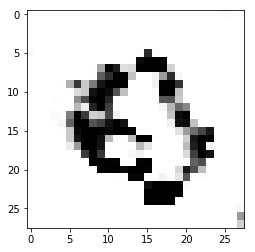

Estimativa: [[-4.53411674]]
Iteração: 71300 at 2017-10-11 09:38:38.204266


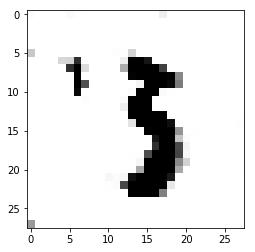

Estimativa: [[-30.5133152]]
Iteração: 71400 at 2017-10-11 09:38:42.412571


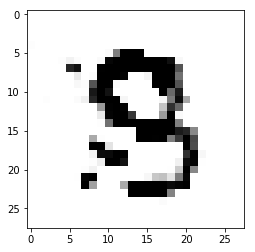

Estimativa: [[ 15.46616459]]
Iteração: 71500 at 2017-10-11 09:38:46.674852


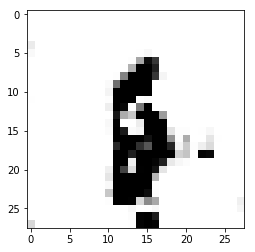

Estimativa: [[-13.8599987]]
Iteração: 71600 at 2017-10-11 09:38:50.963540


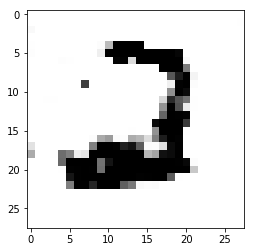

Estimativa: [[ 13.02366924]]
Iteração: 71700 at 2017-10-11 09:38:55.180813


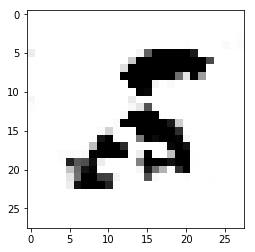

Estimativa: [[ 7.15907431]]
Iteração: 71800 at 2017-10-11 09:38:59.494804


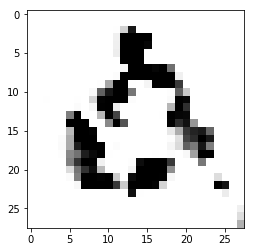

Estimativa: [[-2.84563279]]
Iteração: 71900 at 2017-10-11 09:39:03.732851


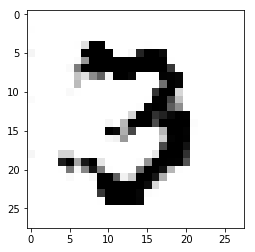

Estimativa: [[-12.57699966]]
Iteração: 72000 at 2017-10-11 09:39:07.944837


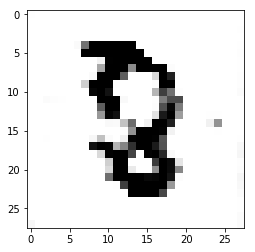

Estimativa: [[ 20.78977203]]
Iteração: 72100 at 2017-10-11 09:39:12.180577


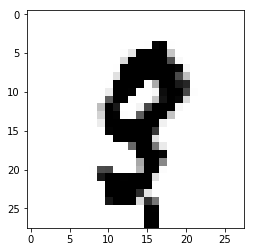

Estimativa: [[ 3.99422216]]
Iteração: 72200 at 2017-10-11 09:39:16.440409


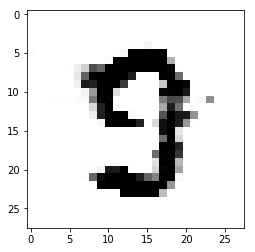

Estimativa: [[-10.46864223]]
Iteração: 72300 at 2017-10-11 09:39:20.751090


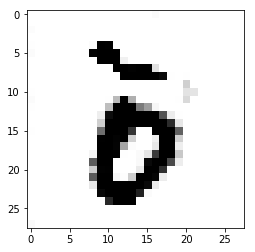

Estimativa: [[-4.82396746]]
Iteração: 72400 at 2017-10-11 09:39:25.021557


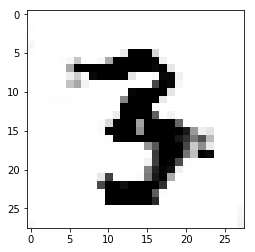

Estimativa: [[ 25.16138268]]
Iteração: 72500 at 2017-10-11 09:39:30.244798


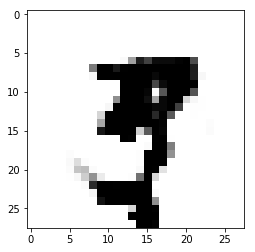

Estimativa: [[-32.26421738]]
Iteração: 72600 at 2017-10-11 09:39:34.605128


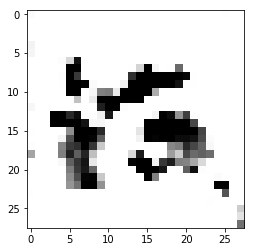

Estimativa: [[ 27.85555267]]
Iteração: 72700 at 2017-10-11 09:39:38.899445


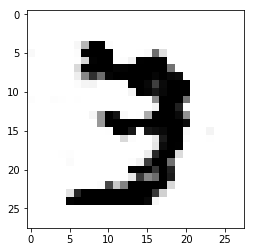

Estimativa: [[-39.22499466]]
Iteração: 72800 at 2017-10-11 09:39:43.239829


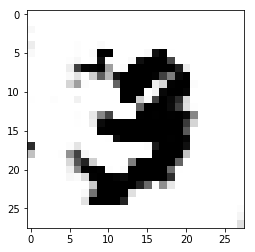

Estimativa: [[-32.02541351]]
Iteração: 72900 at 2017-10-11 09:39:47.529924


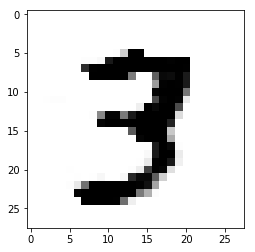

Estimativa: [[ 6.21486521]]
Iteração: 73000 at 2017-10-11 09:39:51.884137


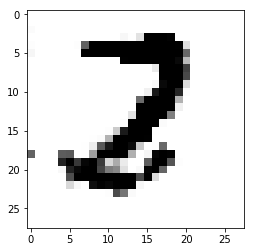

Estimativa: [[ 19.96899796]]
Iteração: 73100 at 2017-10-11 09:39:56.275431


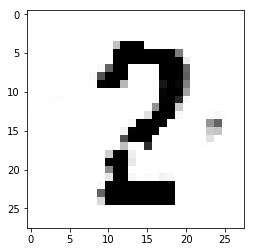

Estimativa: [[ 36.39305115]]
Iteração: 73200 at 2017-10-11 09:40:00.667447


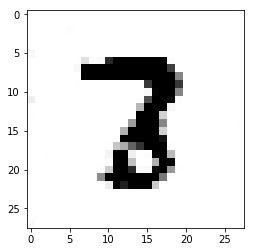

Estimativa: [[ 10.77534294]]
Iteração: 73300 at 2017-10-11 09:40:05.011460


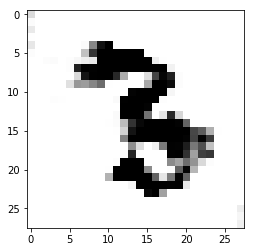

Estimativa: [[ 5.84189606]]
Iteração: 73400 at 2017-10-11 09:40:09.374648


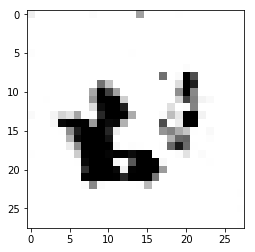

Estimativa: [[-17.0408268]]
Iteração: 73500 at 2017-10-11 09:40:13.670235


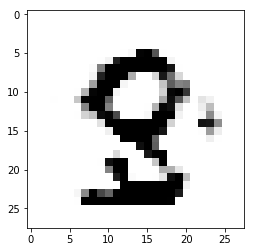

Estimativa: [[-17.04499817]]
Iteração: 73600 at 2017-10-11 09:40:17.965764


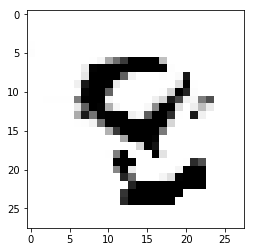

Estimativa: [[ 10.73190022]]
Iteração: 73700 at 2017-10-11 09:40:22.274834


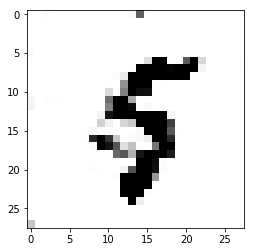

Estimativa: [[-13.82851219]]
Iteração: 73800 at 2017-10-11 09:40:26.593767


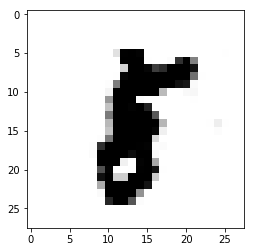

Estimativa: [[ 6.34829044]]
Iteração: 73900 at 2017-10-11 09:40:30.901629


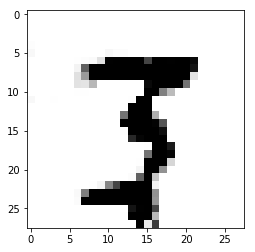

Estimativa: [[ 2.27350283]]
Iteração: 74000 at 2017-10-11 09:40:35.268959


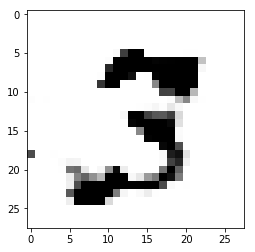

Estimativa: [[-13.99635315]]
Iteração: 74100 at 2017-10-11 09:40:39.614694


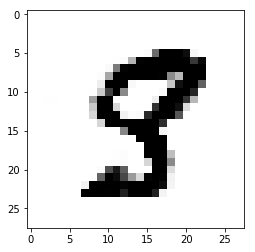

Estimativa: [[ 34.54916]]
Iteração: 74200 at 2017-10-11 09:40:44.076032


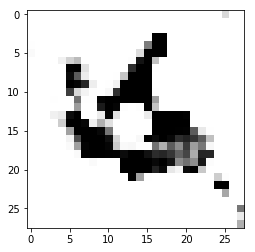

Estimativa: [[ 23.3739357]]
Iteração: 74300 at 2017-10-11 09:40:48.446593


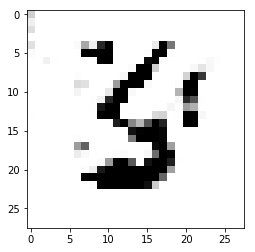

Estimativa: [[-18.64714432]]
Iteração: 74400 at 2017-10-11 09:40:52.827239


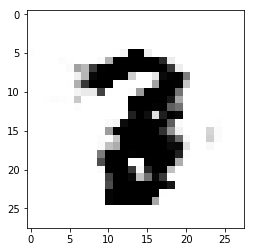

Estimativa: [[-12.62031651]]
Iteração: 74500 at 2017-10-11 09:40:57.473173


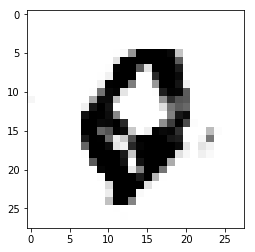

Estimativa: [[ 13.62356472]]
Iteração: 74600 at 2017-10-11 09:41:01.874110


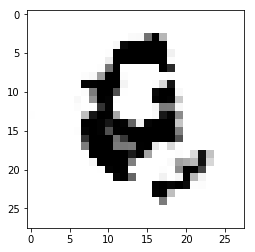

Estimativa: [[-59.55787659]]
Iteração: 74700 at 2017-10-11 09:41:06.189271


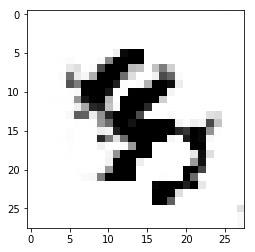

Estimativa: [[-32.64900208]]
Iteração: 74800 at 2017-10-11 09:41:10.534658


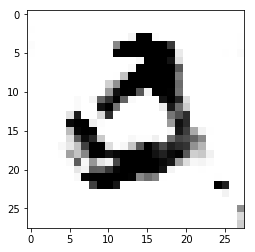

Estimativa: [[ 53.30621338]]
Iteração: 74900 at 2017-10-11 09:41:14.850763


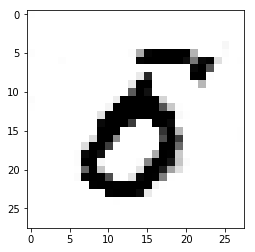

Estimativa: [[-24.33229637]]
Iteração: 75000 at 2017-10-11 09:41:19.234459


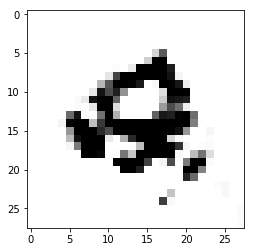

Estimativa: [[-87.95656586]]
Iteração: 75100 at 2017-10-11 09:41:23.572462


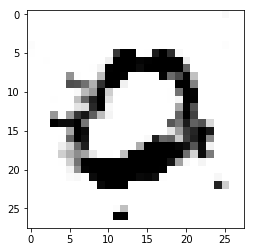

Estimativa: [[ 10.71739674]]
Iteração: 75200 at 2017-10-11 09:41:27.923687


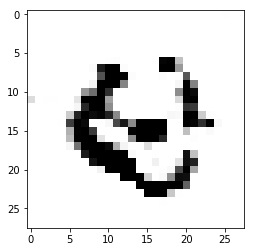

Estimativa: [[ 4.85603476]]
Iteração: 75300 at 2017-10-11 09:41:32.300228


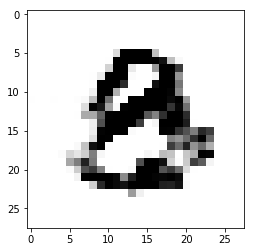

Estimativa: [[ 11.30363178]]
Iteração: 75400 at 2017-10-11 09:41:36.907543


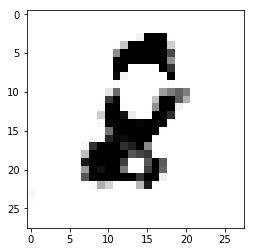

Estimativa: [[-33.03894806]]
Iteração: 75500 at 2017-10-11 09:41:41.350119


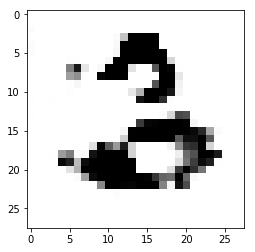

Estimativa: [[ 28.40524864]]
Iteração: 75600 at 2017-10-11 09:41:45.753333


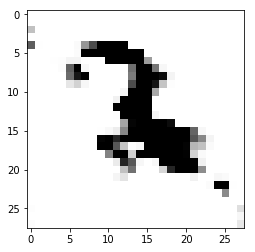

Estimativa: [[ 29.98273277]]
Iteração: 75700 at 2017-10-11 09:41:50.178622


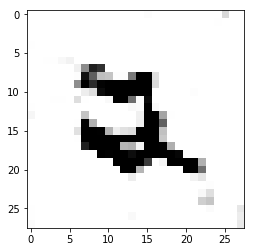

Estimativa: [[ 73.22801208]]
Iteração: 75800 at 2017-10-11 09:41:54.537941


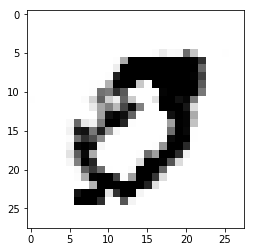

Estimativa: [[ 27.90460205]]
Iteração: 75900 at 2017-10-11 09:41:58.865732


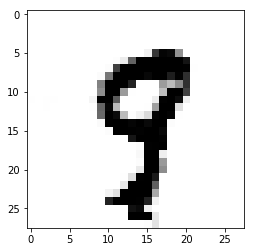

Estimativa: [[ 18.17724609]]
Iteração: 76000 at 2017-10-11 09:42:03.385078


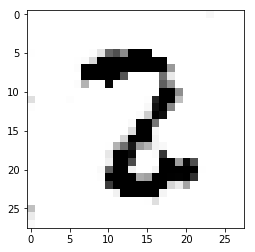

Estimativa: [[ 22.14636803]]
Iteração: 76100 at 2017-10-11 09:42:07.750069


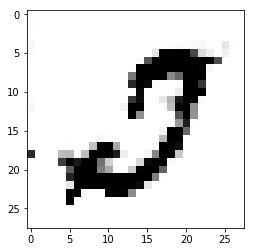

Estimativa: [[ 20.2028923]]
Iteração: 76200 at 2017-10-11 09:42:12.129836


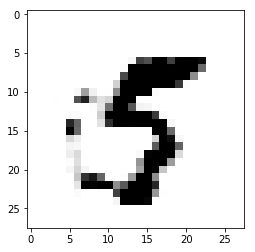

Estimativa: [[ 10.84505558]]
Iteração: 76300 at 2017-10-11 09:42:16.543129


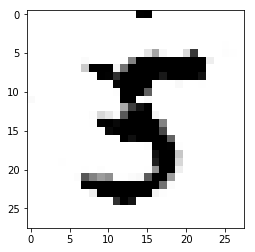

Estimativa: [[ 47.93554306]]
Iteração: 76400 at 2017-10-11 09:42:20.929097


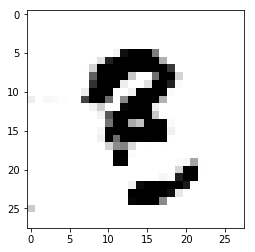

Estimativa: [[ 19.53549576]]
Iteração: 76500 at 2017-10-11 09:42:25.293650


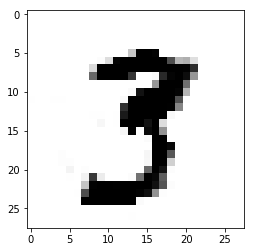

Estimativa: [[ 40.01285553]]
Iteração: 76600 at 2017-10-11 09:42:29.709017


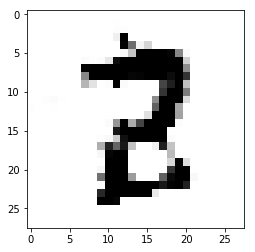

Estimativa: [[-37.21743011]]
Iteração: 76700 at 2017-10-11 09:42:34.160629


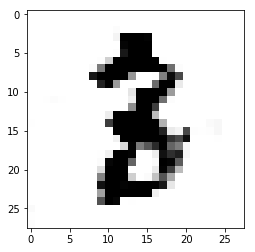

Estimativa: [[-11.40679359]]
Iteração: 76800 at 2017-10-11 09:42:38.535490


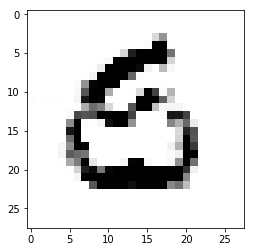

Estimativa: [[-20.07192421]]
Iteração: 76900 at 2017-10-11 09:42:43.049411


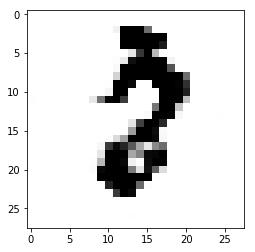

Estimativa: [[-34.30371094]]
Iteração: 77000 at 2017-10-11 09:42:47.453301


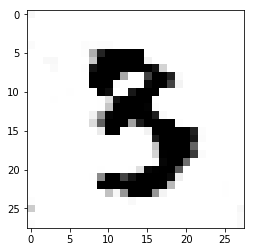

Estimativa: [[ 3.36967015]]
Iteração: 77100 at 2017-10-11 09:42:51.955269


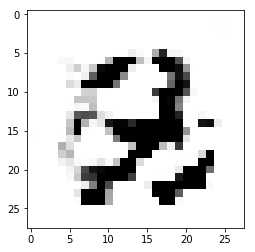

Estimativa: [[-44.58866882]]
Iteração: 77200 at 2017-10-11 09:42:56.356923


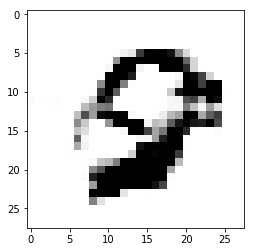

Estimativa: [[ 38.93690491]]
Iteração: 77300 at 2017-10-11 09:43:00.865656


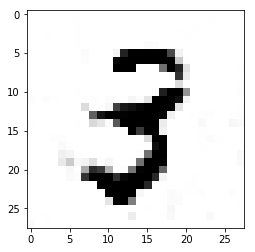

Estimativa: [[-36.68153763]]
Iteração: 77400 at 2017-10-11 09:43:05.315513


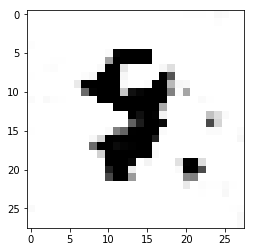

Estimativa: [[-24.1796627]]
Iteração: 77500 at 2017-10-11 09:43:09.712653


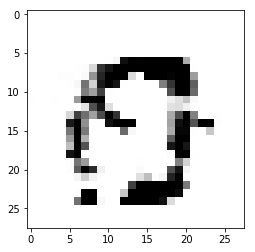

Estimativa: [[-17.33789635]]
Iteração: 77600 at 2017-10-11 09:43:14.111625


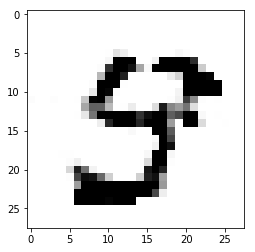

Estimativa: [[ 21.97951508]]
Iteração: 77700 at 2017-10-11 09:43:18.508385


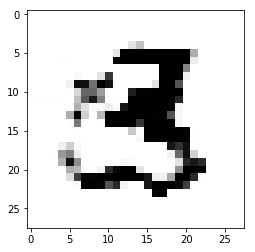

Estimativa: [[ 34.52931213]]
Iteração: 77800 at 2017-10-11 09:43:22.963320


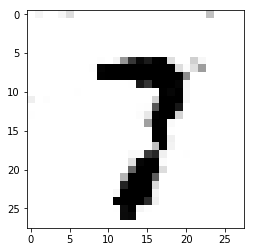

Estimativa: [[-3.83258939]]
Iteração: 77900 at 2017-10-11 09:43:27.469323


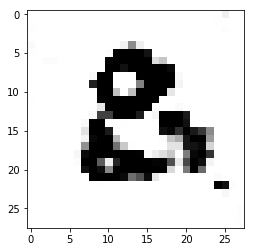

Estimativa: [[-13.60435867]]
Iteração: 78000 at 2017-10-11 09:43:31.907049


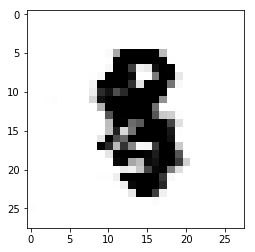

Estimativa: [[ 26.23681068]]
Iteração: 78100 at 2017-10-11 09:43:36.339907


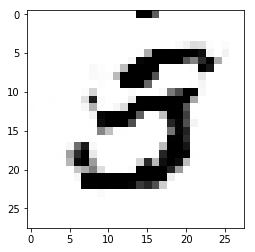

Estimativa: [[ 4.46374798]]
Iteração: 78200 at 2017-10-11 09:43:40.801750


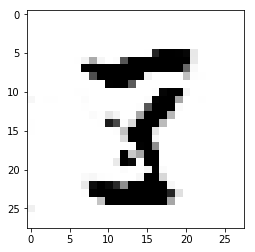

Estimativa: [[-55.70674896]]
Iteração: 78300 at 2017-10-11 09:43:45.289533


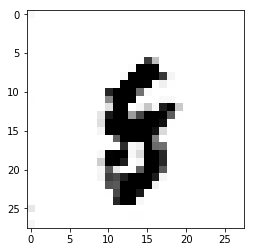

Estimativa: [[-16.09361649]]
Iteração: 78400 at 2017-10-11 09:43:49.794876


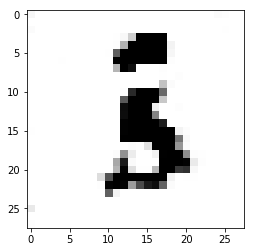

Estimativa: [[-4.48561239]]
Iteração: 78500 at 2017-10-11 09:43:54.230053


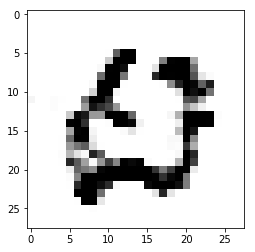

Estimativa: [[-49.63252258]]
Iteração: 78600 at 2017-10-11 09:43:58.707516


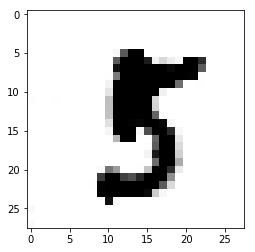

Estimativa: [[ 15.76263523]]
Iteração: 78700 at 2017-10-11 09:44:03.218047


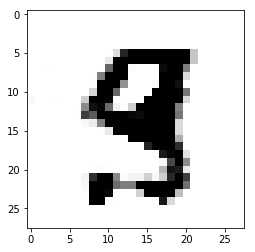

Estimativa: [[-11.7272625]]
Iteração: 78800 at 2017-10-11 09:44:07.648478


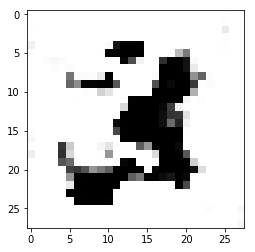

Estimativa: [[-15.87549305]]
Iteração: 78900 at 2017-10-11 09:44:12.162249


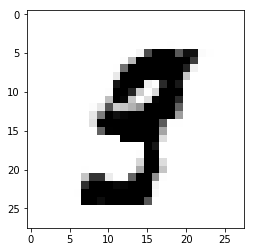

Estimativa: [[ 29.93166161]]
Iteração: 79000 at 2017-10-11 09:44:16.724095


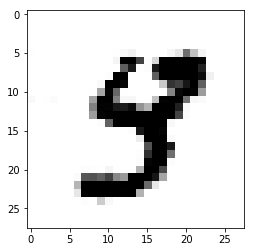

Estimativa: [[-24.54579544]]
Iteração: 79100 at 2017-10-11 09:44:21.321844


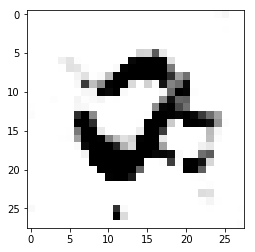

Estimativa: [[ 44.71974182]]
Iteração: 79200 at 2017-10-11 09:44:25.811320


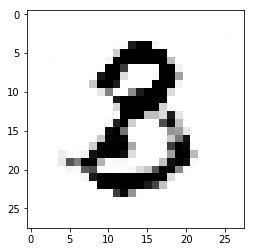

Estimativa: [[ 29.66121292]]
Iteração: 79300 at 2017-10-11 09:44:30.281190


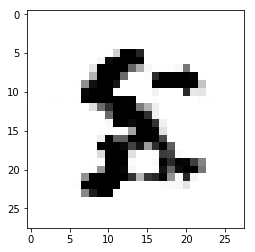

Estimativa: [[-3.52394533]]
Iteração: 79400 at 2017-10-11 09:44:34.738330


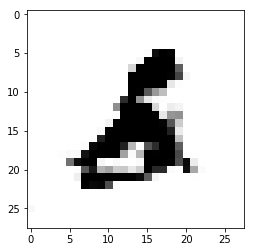

Estimativa: [[ 1.6796782]]
Iteração: 79500 at 2017-10-11 09:44:39.189572


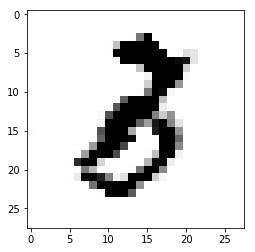

Estimativa: [[ 20.19949913]]
Iteração: 79600 at 2017-10-11 09:44:43.672319


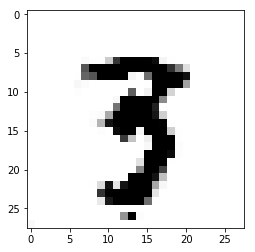

Estimativa: [[ 9.96578979]]
Iteração: 79700 at 2017-10-11 09:44:48.172211


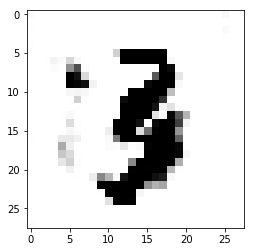

Estimativa: [[-41.21636581]]
Iteração: 79800 at 2017-10-11 09:44:52.674344


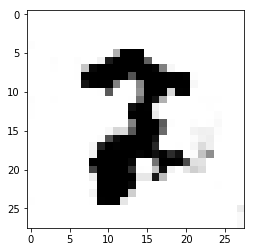

Estimativa: [[ 38.02443695]]
Iteração: 79900 at 2017-10-11 09:44:57.286749


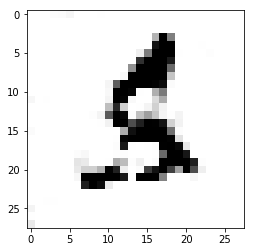

Estimativa: [[-57.4987793]]
Iteração: 80000 at 2017-10-11 09:45:01.821559


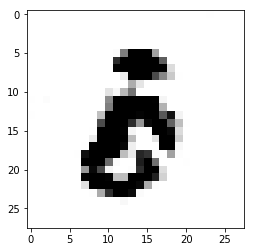

Estimativa: [[-12.4131422]]
Iteração: 80100 at 2017-10-11 09:45:06.364295


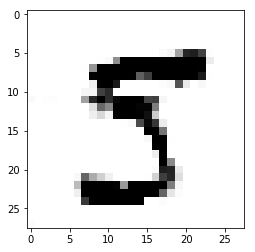

Estimativa: [[-1.06753588]]
Iteração: 80200 at 2017-10-11 09:45:10.838904


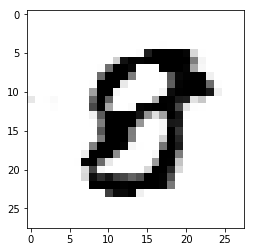

Estimativa: [[-5.32710648]]
Iteração: 80300 at 2017-10-11 09:45:15.319558


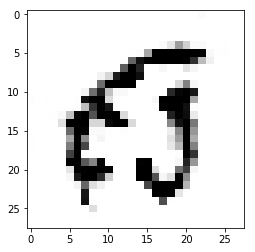

Estimativa: [[ 6.14561749]]
Iteração: 80400 at 2017-10-11 09:45:19.821341


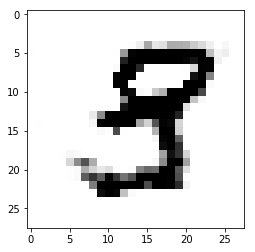

Estimativa: [[ 31.90240288]]
Iteração: 80500 at 2017-10-11 09:45:24.309322


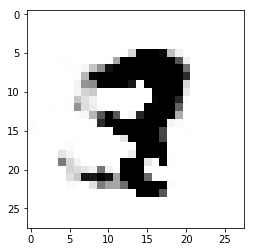

Estimativa: [[-3.66282678]]
Iteração: 80600 at 2017-10-11 09:45:28.791115


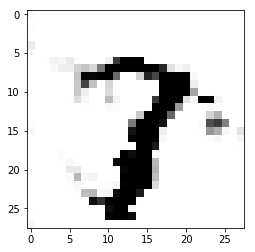

Estimativa: [[-38.04827881]]
Iteração: 80700 at 2017-10-11 09:45:33.326930


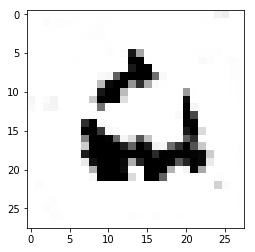

Estimativa: [[ 47.121418]]
Iteração: 80800 at 2017-10-11 09:45:37.907669


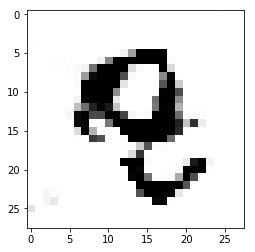

Estimativa: [[ 37.78054428]]
Iteração: 80900 at 2017-10-11 09:45:42.386887


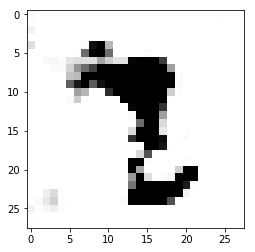

Estimativa: [[ 31.51927948]]
Iteração: 81000 at 2017-10-11 09:45:46.889185


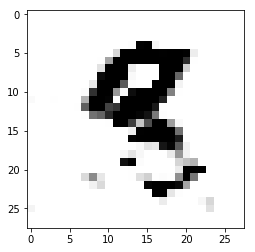

Estimativa: [[-1.37445807]]
Iteração: 81100 at 2017-10-11 09:45:51.468356


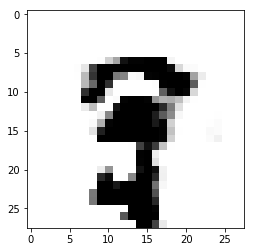

Estimativa: [[ 30.91025734]]
Iteração: 81200 at 2017-10-11 09:45:56.005120


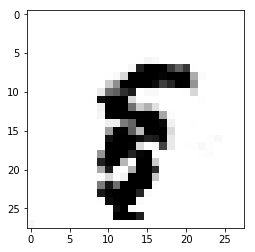

Estimativa: [[ 1.5018189]]
Iteração: 81300 at 2017-10-11 09:46:00.646949


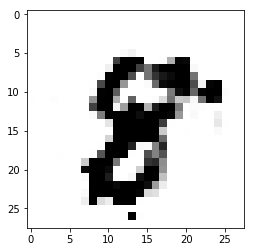

Estimativa: [[ 46.28346252]]
Iteração: 81400 at 2017-10-11 09:46:05.149686


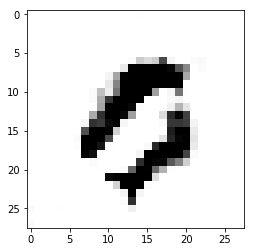

Estimativa: [[-11.79273701]]
Iteração: 81500 at 2017-10-11 09:46:09.699905


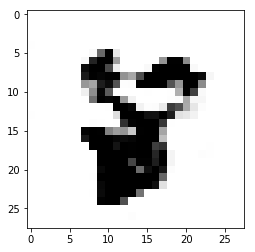

Estimativa: [[-33.53814697]]
Iteração: 81600 at 2017-10-11 09:46:14.322141


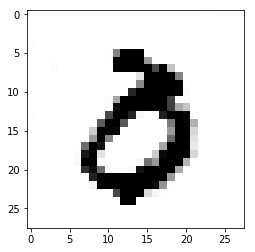

Estimativa: [[ 37.50125504]]
Iteração: 81700 at 2017-10-11 09:46:18.980092


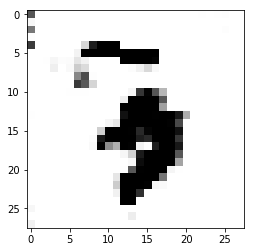

Estimativa: [[ 12.931633]]
Iteração: 81800 at 2017-10-11 09:46:23.492944


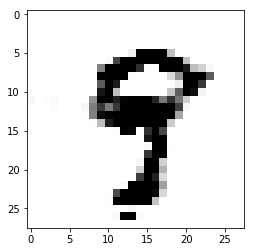

Estimativa: [[ 28.3667717]]
Iteração: 81900 at 2017-10-11 09:46:28.981782


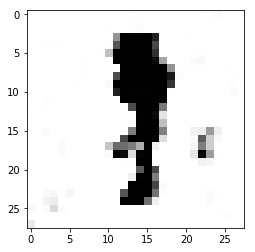

Estimativa: [[ 139.97871399]]
Iteração: 82000 at 2017-10-11 09:46:33.627827


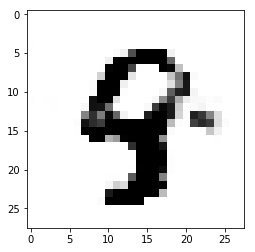

Estimativa: [[ 30.28581429]]
Iteração: 82100 at 2017-10-11 09:46:38.158482


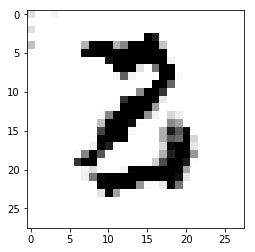

Estimativa: [[ 7.5086503]]
Iteração: 82200 at 2017-10-11 09:46:42.782921


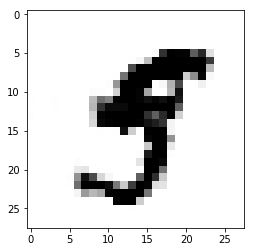

Estimativa: [[ 18.86657906]]
Iteração: 82300 at 2017-10-11 09:46:47.352159


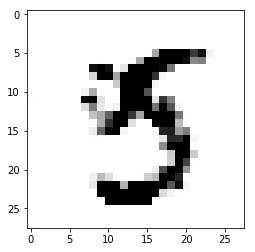

Estimativa: [[-32.32739258]]
Iteração: 82400 at 2017-10-11 09:46:51.939258


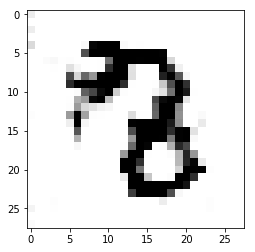

Estimativa: [[-13.62624931]]
Iteração: 82500 at 2017-10-11 09:46:56.621045


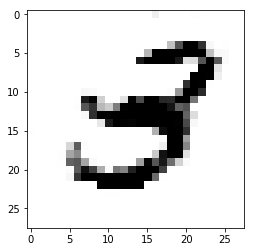

Estimativa: [[ 21.32636833]]
Iteração: 82600 at 2017-10-11 09:47:01.270797


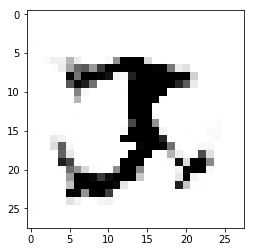

Estimativa: [[ 33.13042068]]
Iteração: 82700 at 2017-10-11 09:47:05.898028


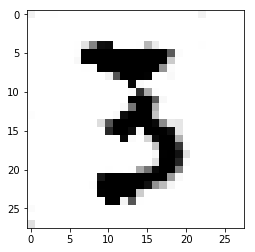

Estimativa: [[ 18.4553051]]
Iteração: 82800 at 2017-10-11 09:47:10.429464


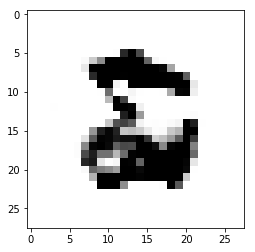

Estimativa: [[ 23.30886459]]
Iteração: 82900 at 2017-10-11 09:47:14.991387


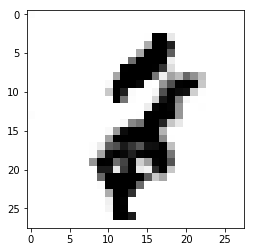

Estimativa: [[-3.18070149]]
Iteração: 83000 at 2017-10-11 09:47:19.553968


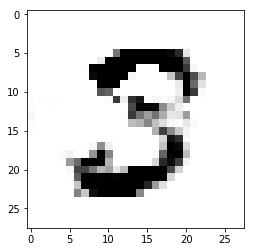

Estimativa: [[-1.0870496]]
Iteração: 83100 at 2017-10-11 09:47:24.206675


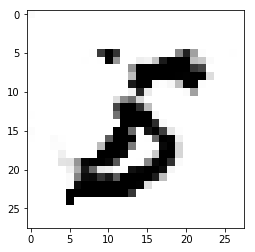

Estimativa: [[-29.32840157]]
Iteração: 83200 at 2017-10-11 09:47:28.847885


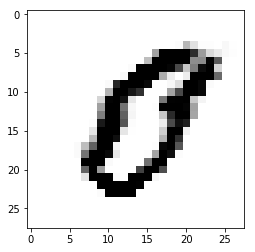

Estimativa: [[ 22.84642601]]
Iteração: 83300 at 2017-10-11 09:47:33.637161


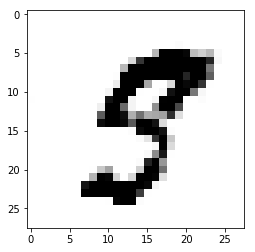

Estimativa: [[ 22.86478043]]
Iteração: 83400 at 2017-10-11 09:47:38.229444


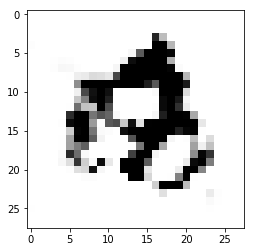

Estimativa: [[-44.32907867]]
Iteração: 83500 at 2017-10-11 09:47:42.881292


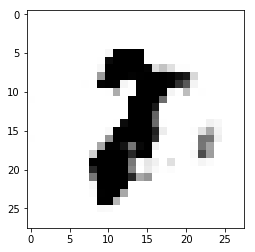

Estimativa: [[ 13.25814247]]
Iteração: 83600 at 2017-10-11 09:47:47.478570


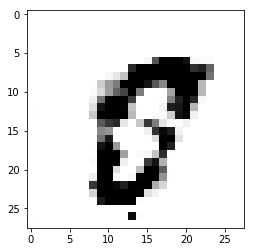

Estimativa: [[ 18.4218483]]
Iteração: 83700 at 2017-10-11 09:47:52.059036


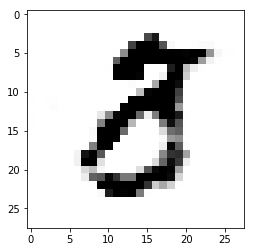

Estimativa: [[ 26.03226662]]
Iteração: 83800 at 2017-10-11 09:47:56.660097


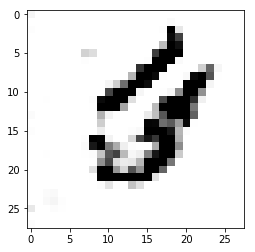

Estimativa: [[-97.89608765]]
Iteração: 83900 at 2017-10-11 09:48:01.344273


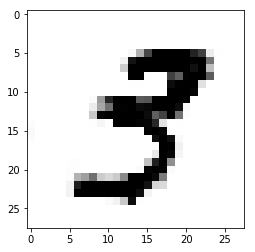

Estimativa: [[ 29.73567009]]
Iteração: 84000 at 2017-10-11 09:48:06.057681


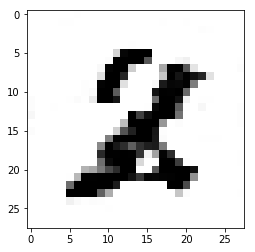

Estimativa: [[ 114.28381348]]
Iteração: 84100 at 2017-10-11 09:48:10.674098


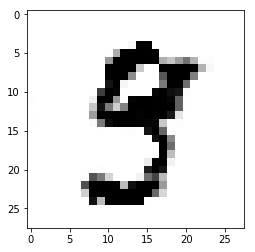

Estimativa: [[ 21.83333969]]
Iteração: 84200 at 2017-10-11 09:48:15.319038


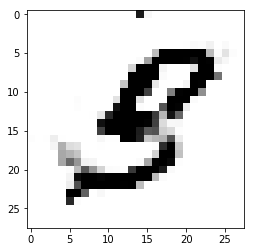

Estimativa: [[ 49.713871]]
Iteração: 84300 at 2017-10-11 09:48:19.923362


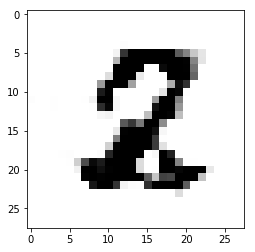

Estimativa: [[-16.65929985]]
Iteração: 84400 at 2017-10-11 09:48:24.649005


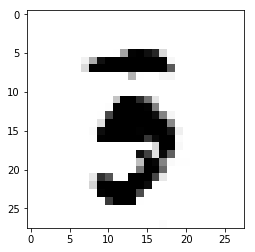

Estimativa: [[ 27.26673508]]
Iteração: 84500 at 2017-10-11 09:48:29.328716


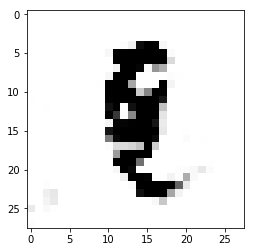

Estimativa: [[-35.61079025]]
Iteração: 84600 at 2017-10-11 09:48:33.994589


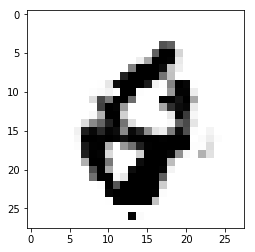

Estimativa: [[-25.03944588]]
Iteração: 84700 at 2017-10-11 09:48:38.615192


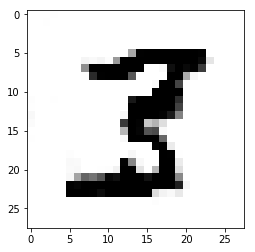

Estimativa: [[ 28.43964386]]
Iteração: 84800 at 2017-10-11 09:48:43.285984


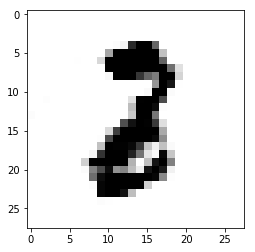

Estimativa: [[ 33.19704819]]
Iteração: 84900 at 2017-10-11 09:48:47.976713


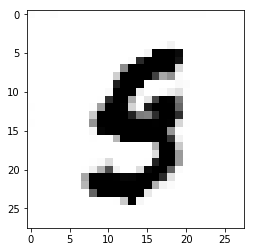

Estimativa: [[ 3.23558784]]
Iteração: 85000 at 2017-10-11 09:48:52.629310


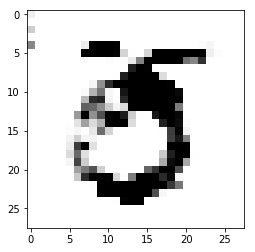

Estimativa: [[ 45.3964653]]
Iteração: 85100 at 2017-10-11 09:48:57.386200


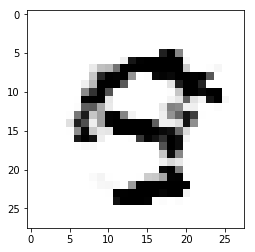

Estimativa: [[-17.46306801]]
Iteração: 85200 at 2017-10-11 09:49:02.025437


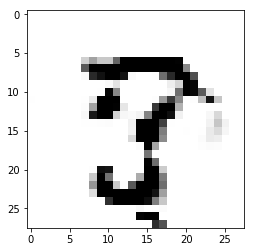

Estimativa: [[ 20.83780479]]
Iteração: 85300 at 2017-10-11 09:49:06.706901


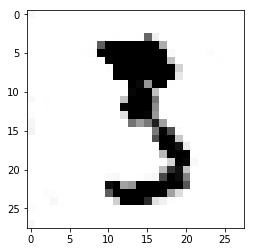

Estimativa: [[ 19.73539925]]
Iteração: 85400 at 2017-10-11 09:49:11.438590


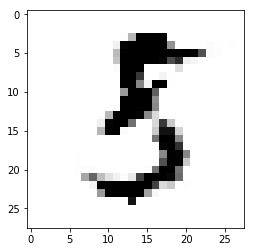

Estimativa: [[-35.31616974]]
Iteração: 85500 at 2017-10-11 09:49:16.146591


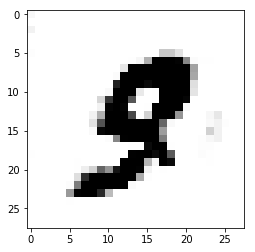

Estimativa: [[ 27.92423439]]
Iteração: 85600 at 2017-10-11 09:49:20.947723


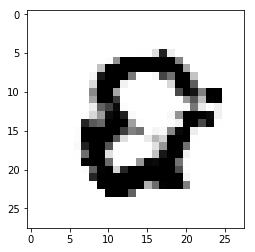

Estimativa: [[ 59.12865448]]
Iteração: 85700 at 2017-10-11 09:49:25.692293


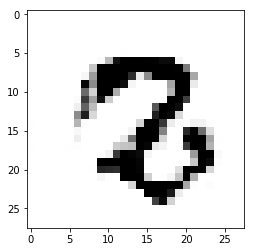

Estimativa: [[ 24.83268547]]
Iteração: 85800 at 2017-10-11 09:49:30.362627


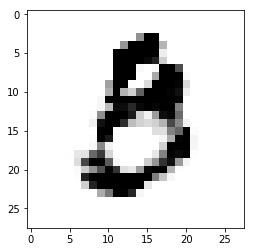

Estimativa: [[-27.5794754]]
Iteração: 85900 at 2017-10-11 09:49:35.001313


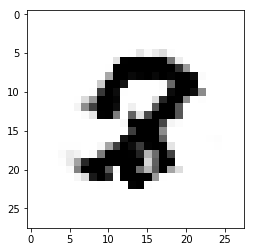

Estimativa: [[ 15.14649487]]
Iteração: 86000 at 2017-10-11 09:49:39.654480


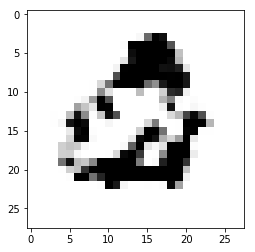

Estimativa: [[ 22.57728195]]
Iteração: 86100 at 2017-10-11 09:49:44.399005


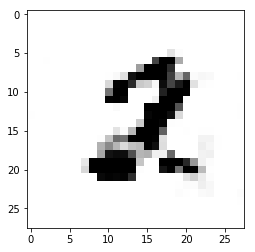

Estimativa: [[-38.01584625]]
Iteração: 86200 at 2017-10-11 09:49:49.078912


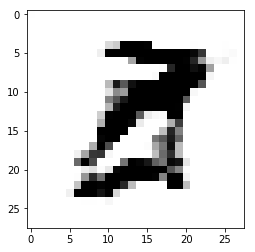

Estimativa: [[ 10.63538933]]
Iteração: 86300 at 2017-10-11 09:49:53.866723


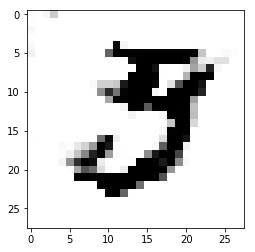

Estimativa: [[ 17.94175148]]
Iteração: 86400 at 2017-10-11 09:49:58.507768


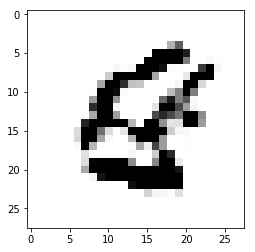

Estimativa: [[-23.65894127]]
Iteração: 86500 at 2017-10-11 09:50:03.162051


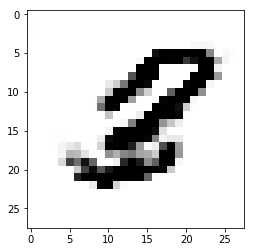

Estimativa: [[ 55.90989304]]
Iteração: 86600 at 2017-10-11 09:50:07.953189


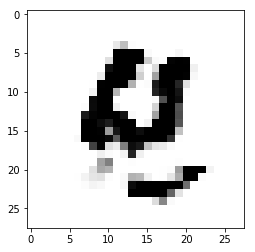

Estimativa: [[ 13.59308624]]
Iteração: 86700 at 2017-10-11 09:50:12.639658


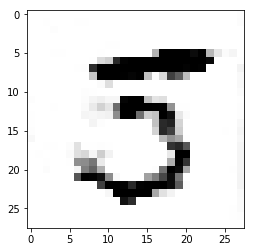

Estimativa: [[ 86.4055481]]
Iteração: 86800 at 2017-10-11 09:50:17.352102


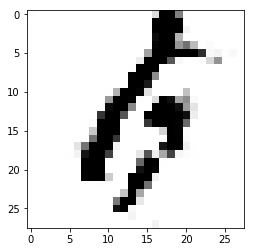

Estimativa: [[ 95.02074432]]
Iteração: 86900 at 2017-10-11 09:50:22.127672


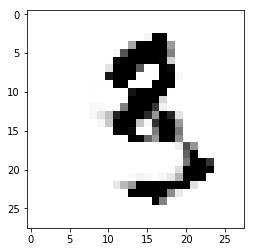

Estimativa: [[ 53.37733841]]
Iteração: 87000 at 2017-10-11 09:50:26.859987


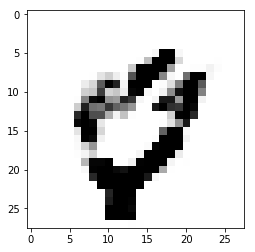

Estimativa: [[ 65.17582703]]
Iteração: 87100 at 2017-10-11 09:50:31.545875


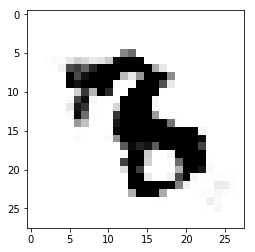

Estimativa: [[ 9.04800606]]
Iteração: 87200 at 2017-10-11 09:50:36.242861


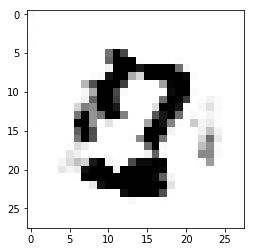

Estimativa: [[-4.15824795]]
Iteração: 87300 at 2017-10-11 09:50:41.092879


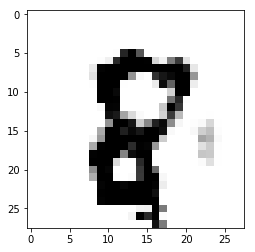

Estimativa: [[ 57.51378632]]
Iteração: 87400 at 2017-10-11 09:50:45.770675


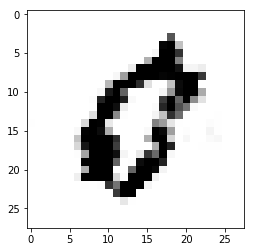

Estimativa: [[-10.31236267]]
Iteração: 87500 at 2017-10-11 09:50:50.509815


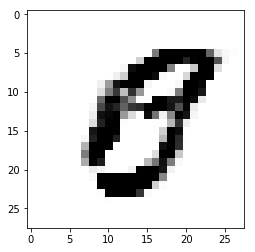

Estimativa: [[ 15.71239471]]
Iteração: 87600 at 2017-10-11 09:50:55.179274


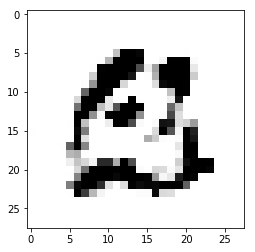

Estimativa: [[ 34.73378372]]
Iteração: 87700 at 2017-10-11 09:51:00.045121


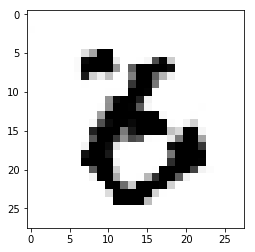

Estimativa: [[ 40.65500641]]
Iteração: 87800 at 2017-10-11 09:51:04.757274


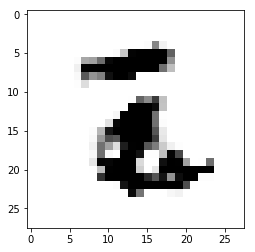

Estimativa: [[ 10.65229416]]
Iteração: 87900 at 2017-10-11 09:51:09.498786


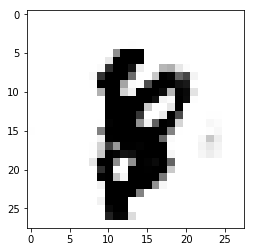

Estimativa: [[ 36.64219284]]
Iteração: 88000 at 2017-10-11 09:51:14.204405


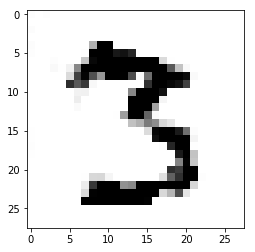

Estimativa: [[ 11.73356724]]
Iteração: 88100 at 2017-10-11 09:51:18.991975


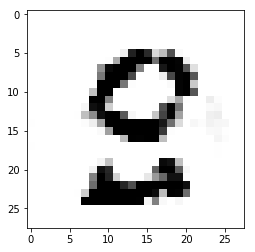

Estimativa: [[-18.59733009]]
Iteração: 88200 at 2017-10-11 09:51:23.708389


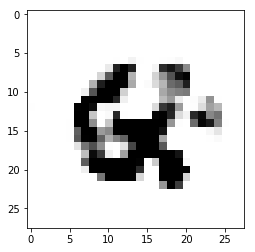

Estimativa: [[ 76.83480835]]
Iteração: 88300 at 2017-10-11 09:51:28.483458


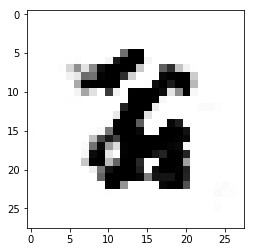

Estimativa: [[ 42.57211304]]
Iteração: 88400 at 2017-10-11 09:51:33.193110


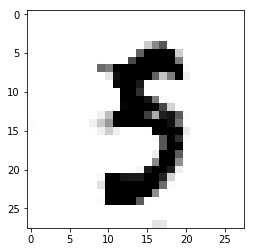

Estimativa: [[ 0.70401442]]
Iteração: 88500 at 2017-10-11 09:51:37.946189


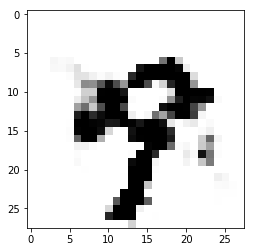

Estimativa: [[ 37.16398621]]
Iteração: 88600 at 2017-10-11 09:51:42.800495


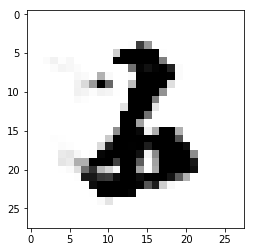

Estimativa: [[-69.53601074]]
Iteração: 88700 at 2017-10-11 09:51:47.547545


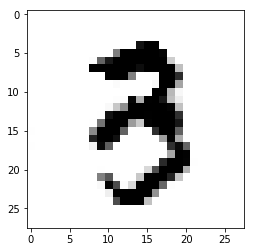

Estimativa: [[ 8.72051716]]
Iteração: 88800 at 2017-10-11 09:51:52.420682


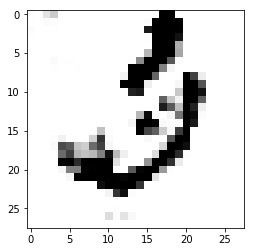

Estimativa: [[-3.48413515]]
Iteração: 88900 at 2017-10-11 09:51:57.175970


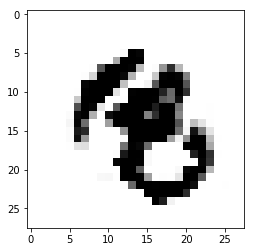

Estimativa: [[ 33.66103745]]
Iteração: 89000 at 2017-10-11 09:52:01.948117


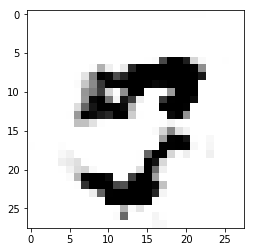

Estimativa: [[ 28.16061592]]
Iteração: 89100 at 2017-10-11 09:52:06.726615


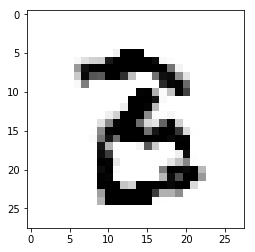

Estimativa: [[ 18.62533188]]
Iteração: 89200 at 2017-10-11 09:52:11.559564


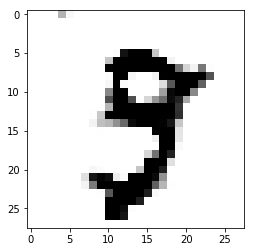

Estimativa: [[ 57.63920593]]
Iteração: 89300 at 2017-10-11 09:52:16.340367


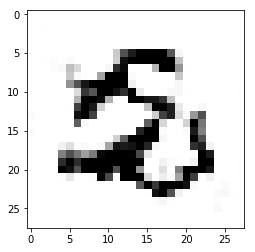

Estimativa: [[-41.48065186]]
Iteração: 89400 at 2017-10-11 09:52:21.086549


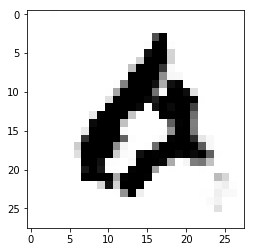

Estimativa: [[-13.31970882]]
Iteração: 89500 at 2017-10-11 09:52:25.828899


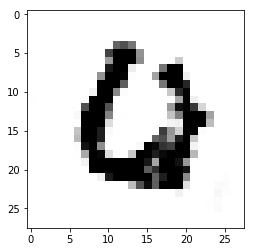

Estimativa: [[ 30.61234093]]
Iteração: 89600 at 2017-10-11 09:52:30.563836


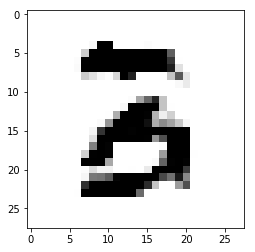

Estimativa: [[-0.19668856]]
Iteração: 89700 at 2017-10-11 09:52:35.403681


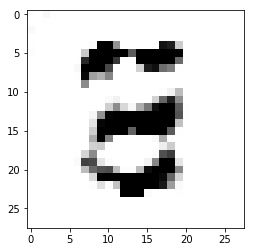

Estimativa: [[ 41.06738663]]
Iteração: 89800 at 2017-10-11 09:52:40.141566


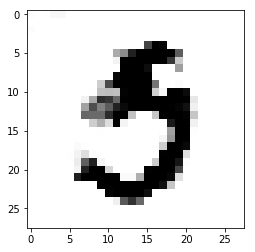

Estimativa: [[-17.30775452]]
Iteração: 89900 at 2017-10-11 09:52:45.047159


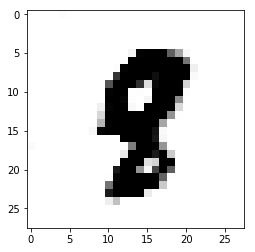

Estimativa: [[ 32.13889313]]
Iteração: 90000 at 2017-10-11 09:52:49.818360


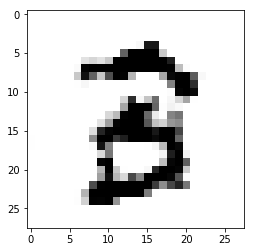

Estimativa: [[-54.68132019]]
Iteração: 90100 at 2017-10-11 09:52:54.586357


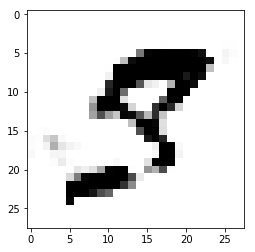

Estimativa: [[ 20.52796173]]
Iteração: 90200 at 2017-10-11 09:52:59.388593


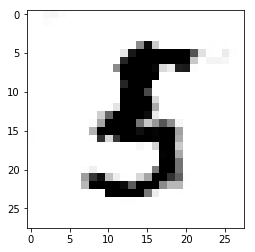

Estimativa: [[-11.30710983]]
Iteração: 90300 at 2017-10-11 09:53:04.302872


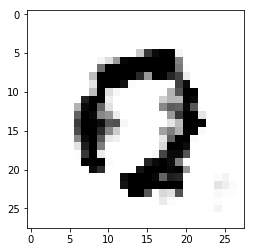

Estimativa: [[-42.8031311]]
Iteração: 90400 at 2017-10-11 09:53:09.114588


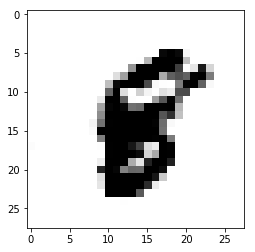

Estimativa: [[ 8.58088493]]
Iteração: 90500 at 2017-10-11 09:53:13.921979


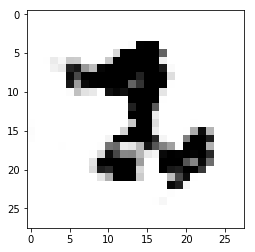

Estimativa: [[ 63.96926498]]
Iteração: 90600 at 2017-10-11 09:53:18.707735


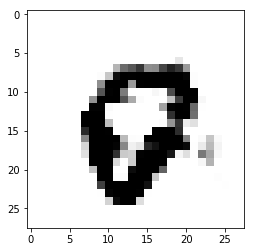

Estimativa: [[ 37.92425537]]
Iteração: 90700 at 2017-10-11 09:53:23.489458


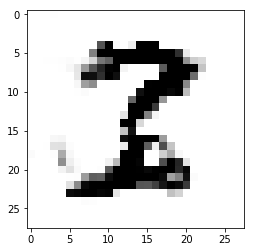

Estimativa: [[-27.30804253]]
Iteração: 90800 at 2017-10-11 09:53:28.287694


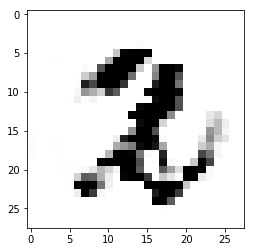

Estimativa: [[ 34.54488754]]
Iteração: 90900 at 2017-10-11 09:53:33.100274


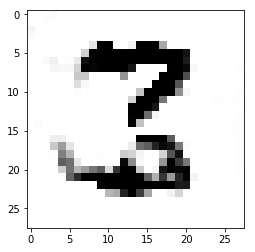

Estimativa: [[-36.7146492]]
Iteração: 91000 at 2017-10-11 09:53:37.943312


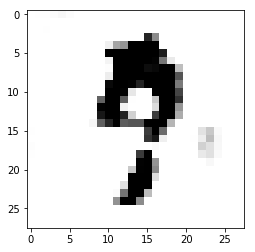

Estimativa: [[ 41.8050499]]
Iteração: 91100 at 2017-10-11 09:53:42.748633


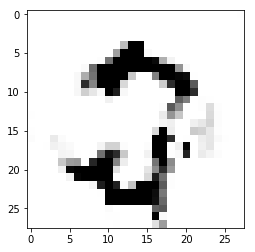

Estimativa: [[-17.33418083]]
Iteração: 91200 at 2017-10-11 09:53:47.549051


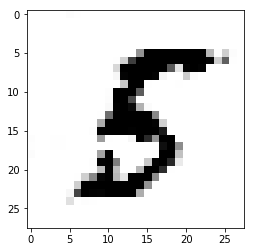

Estimativa: [[-28.81279564]]
Iteração: 91300 at 2017-10-11 09:53:52.396288


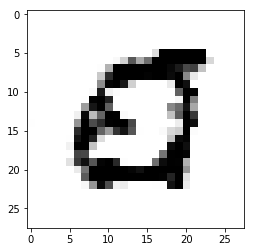

Estimativa: [[ 91.77513885]]
Iteração: 91400 at 2017-10-11 09:53:57.309081


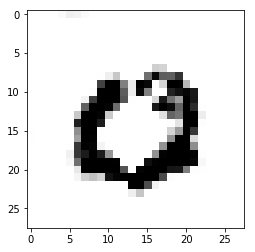

Estimativa: [[ 49.10335159]]
Iteração: 91500 at 2017-10-11 09:54:02.103502


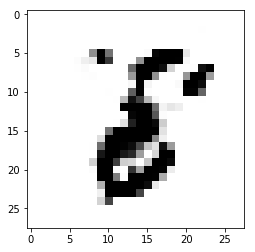

Estimativa: [[-73.47350311]]
Iteração: 91600 at 2017-10-11 09:54:06.947455


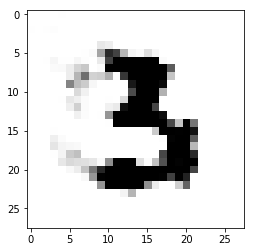

Estimativa: [[-21.44521141]]
Iteração: 91700 at 2017-10-11 09:54:11.927863


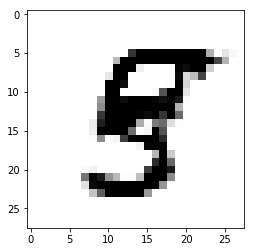

Estimativa: [[ 20.95946693]]
Iteração: 91800 at 2017-10-11 09:54:16.879708


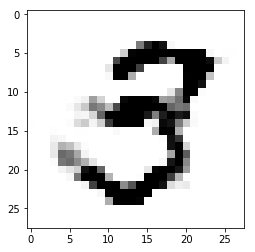

Estimativa: [[ 23.97296143]]
Iteração: 91900 at 2017-10-11 09:54:21.794393


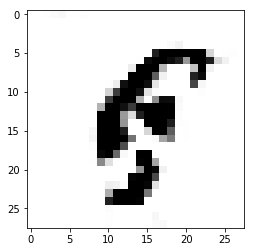

Estimativa: [[-47.76915741]]
Iteração: 92000 at 2017-10-11 09:54:26.663162


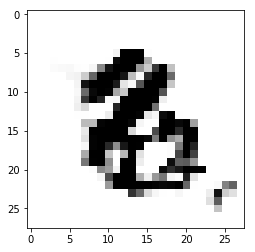

Estimativa: [[-3.91458178]]
Iteração: 92100 at 2017-10-11 09:54:31.624681


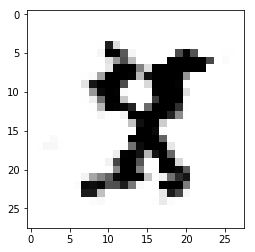

Estimativa: [[ 6.93065262]]
Iteração: 92200 at 2017-10-11 09:54:36.459807


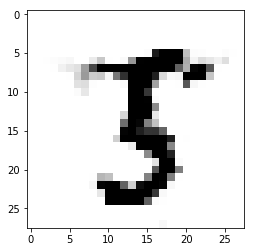

Estimativa: [[ 44.30657578]]
Iteração: 92300 at 2017-10-11 09:54:41.323484


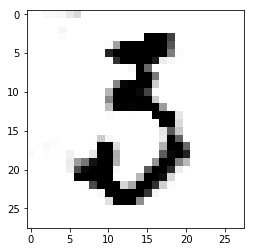

Estimativa: [[ 22.52504349]]
Iteração: 92400 at 2017-10-11 09:54:47.258562


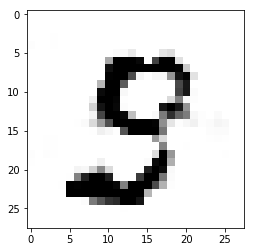

Estimativa: [[ 39.8682251]]
Iteração: 92500 at 2017-10-11 09:54:52.223244


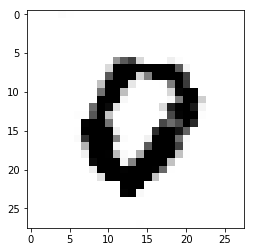

Estimativa: [[-38.52957153]]
Iteração: 92600 at 2017-10-11 09:54:57.215492


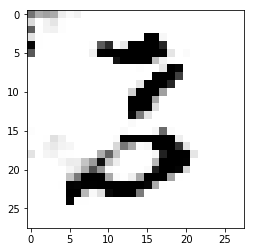

Estimativa: [[ 43.71865463]]
Iteração: 92700 at 2017-10-11 09:55:02.171699


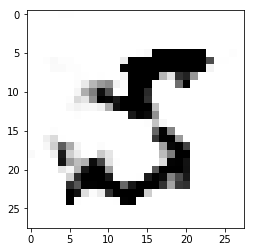

Estimativa: [[-64.31959534]]
Iteração: 92800 at 2017-10-11 09:55:07.061911


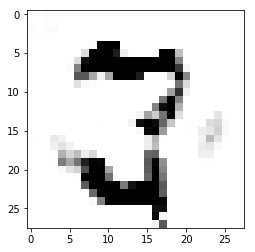

Estimativa: [[ 62.91856003]]
Iteração: 92900 at 2017-10-11 09:55:11.971449


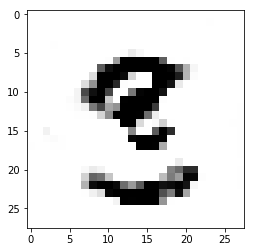

Estimativa: [[ 15.4258461]]
Iteração: 93000 at 2017-10-11 09:55:16.851761


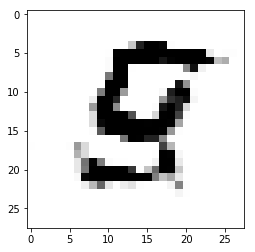

Estimativa: [[-6.25119162]]
Iteração: 93100 at 2017-10-11 09:55:21.729655


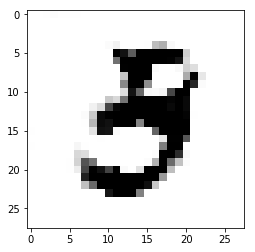

Estimativa: [[ 1.47820652]]
Iteração: 93200 at 2017-10-11 09:55:26.834680


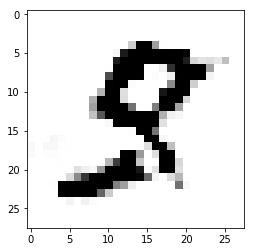

Estimativa: [[ 37.11278915]]
Iteração: 93300 at 2017-10-11 09:55:31.836294


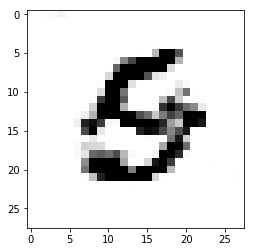

Estimativa: [[ 19.08705902]]
Iteração: 93400 at 2017-10-11 09:55:36.743750


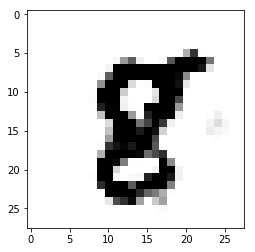

Estimativa: [[ 74.97987366]]
Iteração: 93500 at 2017-10-11 09:55:41.631939


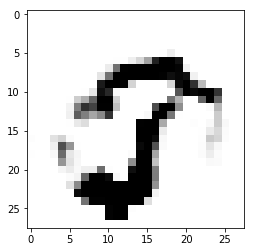

Estimativa: [[ 32.49081039]]
Iteração: 93600 at 2017-10-11 09:55:46.523272


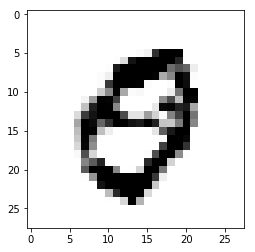

Estimativa: [[-5.94917393]]
Iteração: 93700 at 2017-10-11 09:55:51.535113


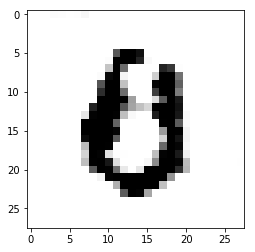

Estimativa: [[ 12.67338085]]
Iteração: 93800 at 2017-10-11 09:55:56.431010


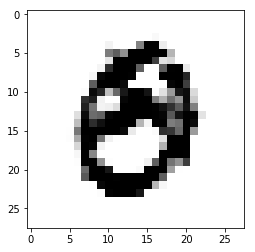

Estimativa: [[-30.39170456]]
Iteração: 93900 at 2017-10-11 09:56:01.468148


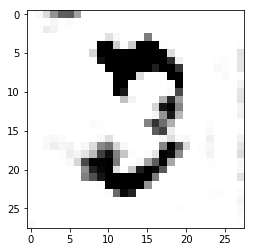

Estimativa: [[ 51.43873596]]
Iteração: 94000 at 2017-10-11 09:56:06.484247


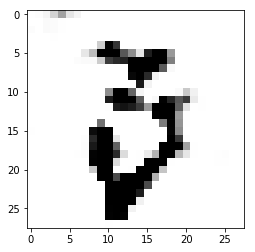

Estimativa: [[ 37.04528427]]
Iteração: 94100 at 2017-10-11 09:56:11.433230


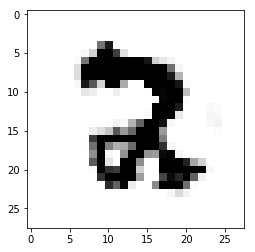

Estimativa: [[-25.15751457]]
Iteração: 94200 at 2017-10-11 09:56:16.320096


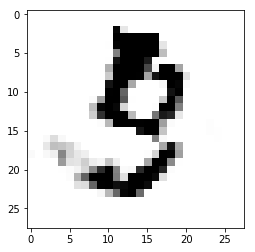

Estimativa: [[ 16.15126228]]
Iteração: 94300 at 2017-10-11 09:56:21.364342


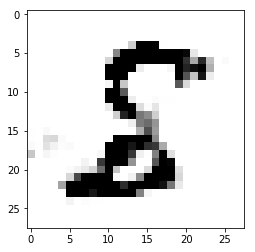

Estimativa: [[ 39.53118515]]
Iteração: 94400 at 2017-10-11 09:56:26.268476


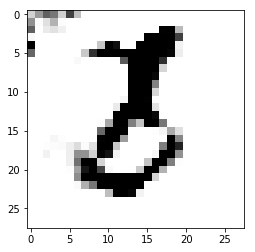

Estimativa: [[ 15.99602509]]
Iteração: 94500 at 2017-10-11 09:56:31.171780


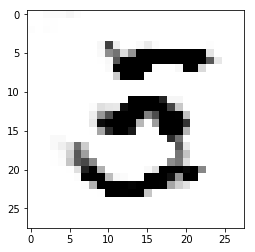

Estimativa: [[ 19.85519791]]
Iteração: 94600 at 2017-10-11 09:56:36.069289


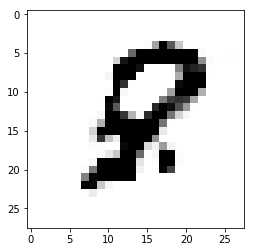

Estimativa: [[-3.30318117]]
Iteração: 94700 at 2017-10-11 09:56:40.990900


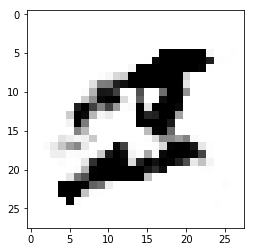

Estimativa: [[-3.84300947]]
Iteração: 94800 at 2017-10-11 09:56:45.872062


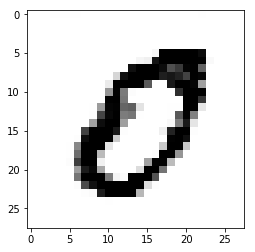

Estimativa: [[ 39.2906189]]
Iteração: 94900 at 2017-10-11 09:56:50.844783


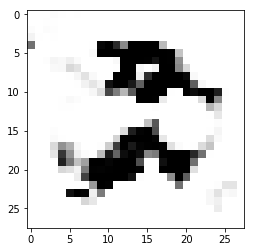

Estimativa: [[-65.33381653]]
Iteração: 95000 at 2017-10-11 09:56:55.881690


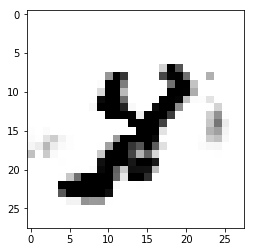

Estimativa: [[ 84.90538025]]
Iteração: 95100 at 2017-10-11 09:57:00.842818


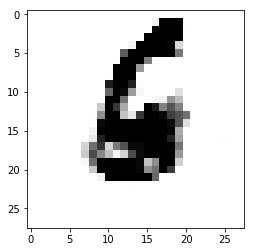

Estimativa: [[ 81.47483063]]
Iteração: 95200 at 2017-10-11 09:57:05.869945


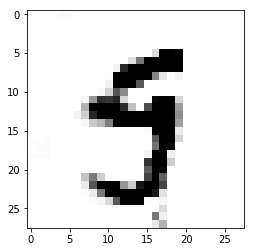

Estimativa: [[-4.21750069]]
Iteração: 95300 at 2017-10-11 09:57:10.890539


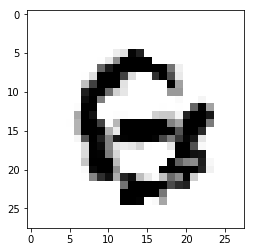

Estimativa: [[-29.42641449]]
Iteração: 95400 at 2017-10-11 09:57:16.016980


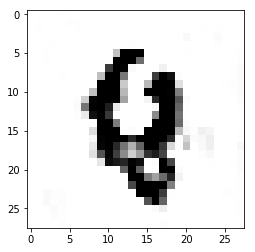

Estimativa: [[ 82.07073975]]
Iteração: 95500 at 2017-10-11 09:57:20.967613


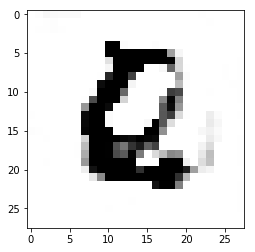

Estimativa: [[ 8.69080734]]
Iteração: 95600 at 2017-10-11 09:57:25.958038


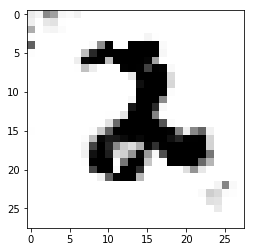

Estimativa: [[ 17.63933754]]
Iteração: 95700 at 2017-10-11 09:57:30.918801


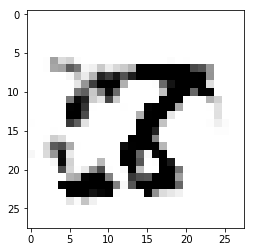

Estimativa: [[ 6.42363548]]
Iteração: 95800 at 2017-10-11 09:57:35.905536


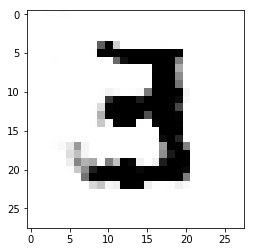

Estimativa: [[ 17.10434341]]
Iteração: 95900 at 2017-10-11 09:57:40.898745


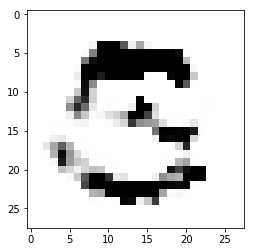

Estimativa: [[ 63.24075317]]
Iteração: 96000 at 2017-10-11 09:57:46.004951


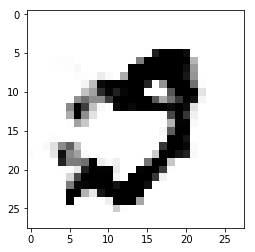

Estimativa: [[ 45.61117172]]
Iteração: 96100 at 2017-10-11 09:57:50.952311


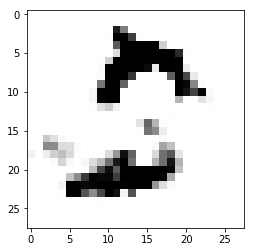

Estimativa: [[ 12.06707573]]
Iteração: 96200 at 2017-10-11 09:57:55.999247


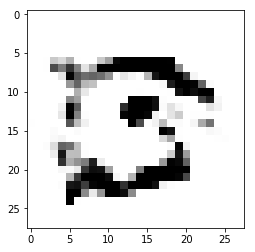

Estimativa: [[ 26.98261261]]
Iteração: 96300 at 2017-10-11 09:58:00.954894


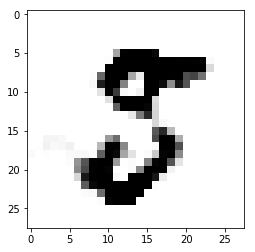

Estimativa: [[-9.43417835]]
Iteração: 96400 at 2017-10-11 09:58:05.973543


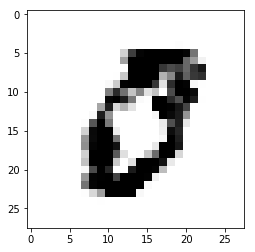

Estimativa: [[-27.15834236]]
Iteração: 96500 at 2017-10-11 09:58:10.983870


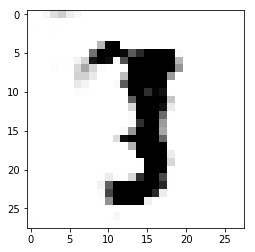

Estimativa: [[-9.88512993]]
Iteração: 96600 at 2017-10-11 09:58:15.957042


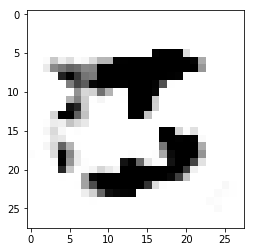

Estimativa: [[ 39.78889847]]
Iteração: 96700 at 2017-10-11 09:58:20.964368


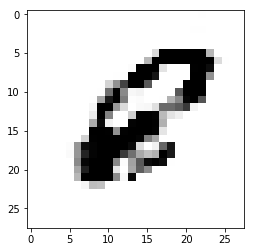

Estimativa: [[ 117.04466248]]
Iteração: 96800 at 2017-10-11 09:58:25.958752


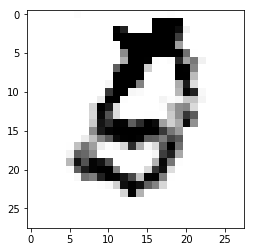

Estimativa: [[ 52.70214081]]
Iteração: 96900 at 2017-10-11 09:58:30.999891


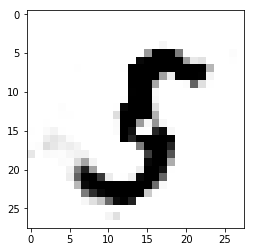

Estimativa: [[-5.4323926]]
Iteração: 97000 at 2017-10-11 09:58:36.002198


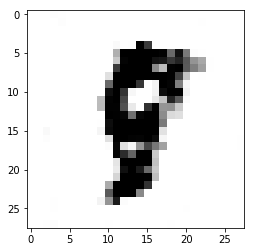

Estimativa: [[ 78.37459564]]
Iteração: 97100 at 2017-10-11 09:58:41.101793


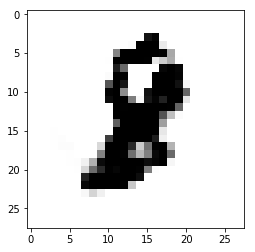

Estimativa: [[ 20.1427803]]
Iteração: 97200 at 2017-10-11 09:58:46.155498


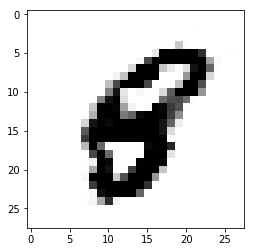

Estimativa: [[ 4.52426052]]
Iteração: 97300 at 2017-10-11 09:58:51.125992


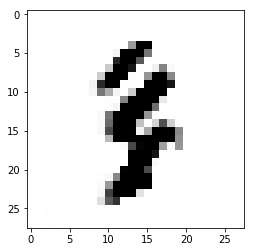

Estimativa: [[ 110.40700531]]
Iteração: 97400 at 2017-10-11 09:58:56.135833


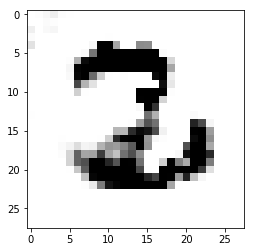

Estimativa: [[ 35.11599731]]
Iteração: 97500 at 2017-10-11 09:59:01.159075


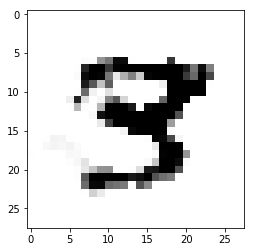

Estimativa: [[-16.94899178]]
Iteração: 97600 at 2017-10-11 09:59:06.335149


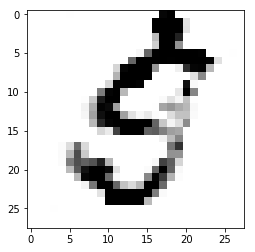

Estimativa: [[ 128.27047729]]
Iteração: 97700 at 2017-10-11 09:59:11.320188


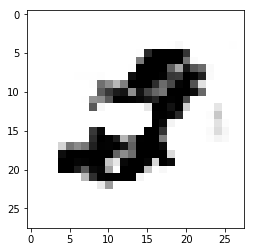

Estimativa: [[-14.79683018]]
Iteração: 97800 at 2017-10-11 09:59:16.368665


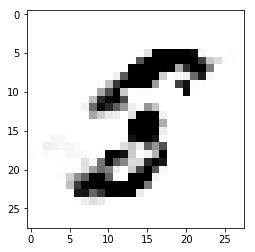

Estimativa: [[-26.55799103]]
Iteração: 97900 at 2017-10-11 09:59:21.386269


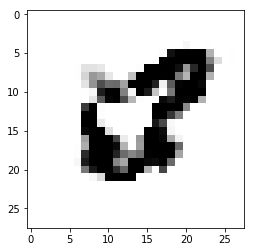

Estimativa: [[ 33.57415009]]
Iteração: 98000 at 2017-10-11 09:59:26.412124


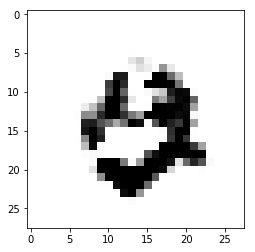

Estimativa: [[-16.10754395]]
Iteração: 98100 at 2017-10-11 09:59:31.423849


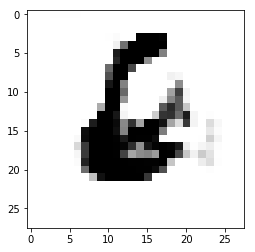

Estimativa: [[-40.3216095]]
Iteração: 98200 at 2017-10-11 09:59:36.490603


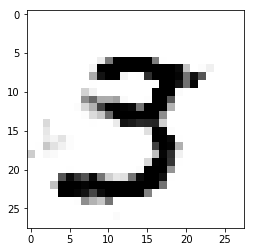

Estimativa: [[ 27.40883064]]
Iteração: 98300 at 2017-10-11 09:59:41.537993


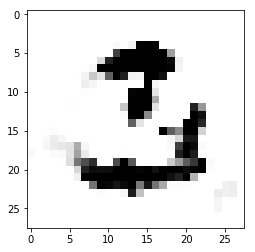

Estimativa: [[-13.27438641]]
Iteração: 98400 at 2017-10-11 09:59:46.708966


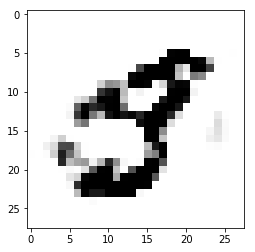

Estimativa: [[-7.81726694]]
Iteração: 98500 at 2017-10-11 09:59:51.742966


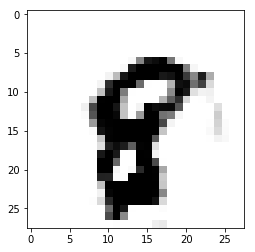

Estimativa: [[ 45.27212906]]
Iteração: 98600 at 2017-10-11 09:59:56.847147


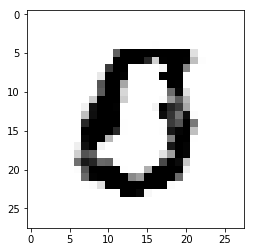

Estimativa: [[ 35.57940292]]
Iteração: 98700 at 2017-10-11 10:00:01.986105


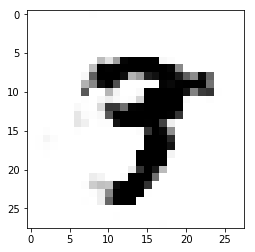

Estimativa: [[ 16.73166084]]
Iteração: 98800 at 2017-10-11 10:00:07.046942


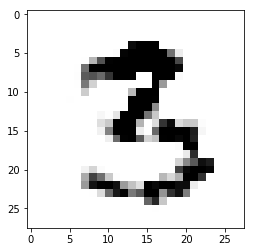

Estimativa: [[ 12.67523766]]
Iteração: 98900 at 2017-10-11 10:00:12.088739


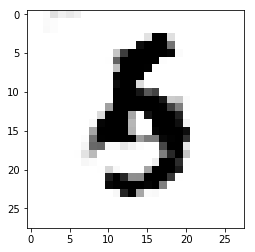

Estimativa: [[-35.76171875]]
Iteração: 99000 at 2017-10-11 10:00:17.109947


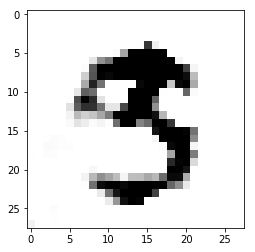

Estimativa: [[ 5.92986822]]
Iteração: 99100 at 2017-10-11 10:00:22.212687


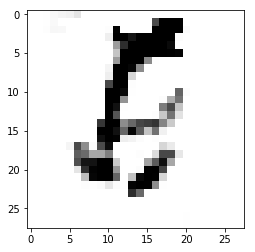

Estimativa: [[-48.12761688]]
Iteração: 99200 at 2017-10-11 10:00:27.267131


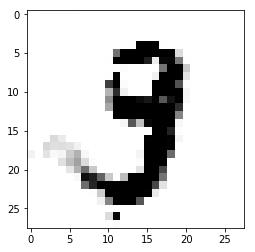

Estimativa: [[ 88.8596344]]
Iteração: 99300 at 2017-10-11 10:00:32.364049


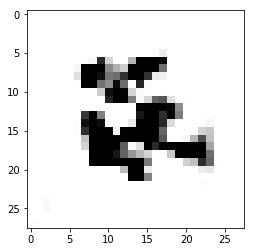

Estimativa: [[-65.84559631]]
Iteração: 99400 at 2017-10-11 10:00:37.555232


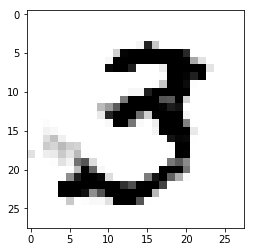

Estimativa: [[ 14.23157215]]
Iteração: 99500 at 2017-10-11 10:00:42.591775


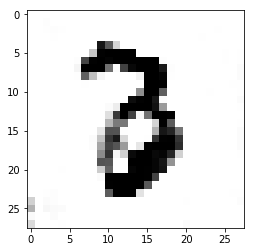

Estimativa: [[ 131.25778198]]
Iteração: 99600 at 2017-10-11 10:00:47.697266


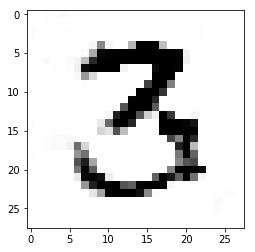

Estimativa: [[ 86.38157654]]
Iteração: 99700 at 2017-10-11 10:00:52.840689


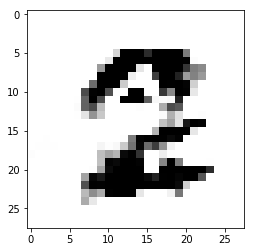

Estimativa: [[ 4.35733843]]
Iteração: 99800 at 2017-10-11 10:00:58.034591


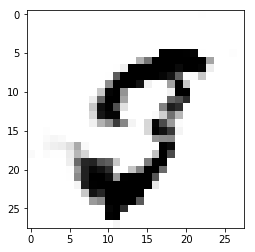

Estimativa: [[ 25.15714455]]
Iteração: 99900 at 2017-10-11 10:01:03.227916


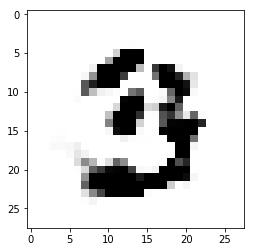

Estimativa: [[-7.84543657]]


In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pré-treino do modelo discriminativo
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Treinar os modelos discriminativo e generativo juntos
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Treinando o modelo discriminativo nos dados reais e fake
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Treinando o modelo generativo
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Atualiza o TensorBoard com Estatísticas
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # A cada 100 iterações mostra uma imagem gerada
        print("Iteração:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimativa:", estimate)

## Dificuldades no Treinamento

Os GANs são notoriamente difíceis de treinar. Sem hiperparâmetros certos, arquitetura de rede e procedimento de treinamento, o discriminador pode dominar o gerador ou vice-versa.

Em um modo de falha comum, o discriminador supera o gerador, classificando as imagens geradas como falsas com certeza absoluta. Quando o discriminador responde com absoluta certeza, não deixa nenhum gradiente para o gerador descer. Isto ocorre, em parte, porque construímos o nosso discriminador para produzir um output não padronizado, em vez de passar a sua saída através de uma função sigmoide que empurraria a avaliação para 0 ou 1.

Em outro modo de falha comum conhecido como ** colapso do modo **, o gerador descobre e explora alguma fraqueza no discriminador. Você pode reconhecer o colapso do modo em seu GAN se ele gera muitas imagens muito semelhantes, independentemente da variação na entrada do gerador _z_. O colapso do modo às vezes pode ser corrigido por "fortalecer" o discriminador de alguma maneira - por exemplo, ajustando sua taxa de treinamento ou reconfigurando suas camadas.

# Fim